<a href="https://colab.research.google.com/github/honkuro1227/CSE475/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [ ]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'
if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir(BASE_PATH)
!cp test2.txt /content



os.chdir('/content')
#os.chdir(BASE_PATH)
!dir

--2020-11-16 06:00:01--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  4.75MB/s    in 0.5s    

2020-11-16 06:00:02 (4.75 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py
harry_potter.txt  pt_util.py  sample_data  test2.txt


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import string

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    # TODO Add more preprocessing

    voc2ind ={}
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    data = re.sub(r'\s+',' ', data)
    l=round(len(data)*0.8)

    for char in data:
      if char not in voc2ind.keys():
        voc2ind[char]=len(voc2ind.keys())

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = [voc2ind[ele] for ele in data[:l]]# TODO Fill this in
    test_text =  [voc2ind[ele] for ele in data[l:-1]]# TODO Fill this in
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))

prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        #print(words)
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size.
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [ ]:

class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        self.data = []

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        data = np.asarray(dataset['tokens'])
        divide = int(len(data) / batch_size)
        batches = []
        for i in range(0, batch_size):
            cur=i*divide
            batches.append(data[cur:cur + divide - 1])
        remove = int(len(batches[0]) % sequence_length)
        batches = np.asarray(batches)

        if remove != 0:
            removedele = batches[:, 0:-remove]
        else:
            removedele = batches
        removedele = removedele.reshape(-1, batch_size, sequence_length)
        traverse = removedele.shape[1]
        batches = []

        for i in range(0, traverse):
            batches.append(removedele[:, i::i + traverse, :])

        batches = np.asarray(batches)
        batches = batches.reshape(-1,sequence_length)
        self.data = batches

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return len(np.unique(self.data,axis=0))
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are
        # in and how far down in the chunk you are.

        val = self.data
        data = np.squeeze(val[idx])
        data = torch.LongTensor(data)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [ ]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)

        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()

        self.best_accuracy = -1
        print(self.vocab_size,self.feature_size)

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]

        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        #print("int the net",x.shape)#256 99 VS 512 89
        #print(self.vocab_size)

        embedded = self.encoder(x)
        output, hidden_state = self.gru(embedded, hidden_state)
        #print('hidden',hidden_state.shape)
        x = self.decoder(output)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [ ]:
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab,device):
  outputs = []
  #output is the longTensor word :)
  for i in range(sequence_length):
    output = torch.argmax(output.to(device))
    outputs.append(int(output))
    output, hidden = model.inference(output,hidden)

  return outputs


def sample_sampling_strategy(sequence_length, model, output, hidden, vocab,device):
  outputs = []

  indice = torch.multinomial(output, 1)
  for i in range(sequence_length):
    output = output.to(device)
    output = torch.LongTensor([indice]).cuda()
    output, hidden = model.inference(output, hidden)
    indice = torch.multinomial(output, 1)
    outputs.append(indice)
  return outputs



def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab,device):
  output = output.to(device)
  tmp = []
  newbeam = []
  sorted_score = torch.argsort(torch.log(output))[0][-beam_width:]
  for indice in sorted_score:
      newbeam.append(([indice],hidden,torch.log(output[0][indice])))
  for i in range(sequence_length):
      for beam in newbeam:
          indice = torch.LongTensor([beam[0][-1]])
          if len(beam[0])<=1:
            indice = torch.LongTensor([beam[0]])
          output, hidden = model.inference(indice.cuda(), beam[1])
          samples = torch.multinomial(output,beam_width)
          for sample in samples[0]:
            newindice = beam[0] + [sample]
            score = beam[2]+ torch.log(output[0][sample])
            tmp.append((newindice, hidden, score))
      newbeam = sorted(tmp,reverse=True, key=lambda x: x[2])
      newbeam = newbeam[:beam_width]
      tmp.clear()
  outputs = [int(x) for x in newbeam[0][0]]
  return outputs




def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab,device)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, device)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab,device)

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)

        # Separates the hidden state across batches.
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)

            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
            #     print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #         test_loader.dataset.vocab.array_to_words(data[0]),
            #         test_loader.dataset.vocab.array_to_words(label[0]),
            #         test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
89 512


  0%|          | 0/194 [00:00<?, ?it/s]


Test set: Average loss: 16.3184, Accuracy: 6914/1228800 (1%)



  2%|▏         | 3/194 [00:00<01:17,  2.47it/s]

Train Epoch: 0 [0/49664 (0%)]	Loss: 16.286720


  7%|▋         | 13/194 [00:01<00:28,  6.46it/s]

Train Epoch: 0 [2560/49664 (5%)]	Loss: 11.017870


 12%|█▏        | 23/194 [00:02<00:19,  8.74it/s]

Train Epoch: 0 [5120/49664 (10%)]	Loss: 5.809397


 17%|█▋        | 33/194 [00:03<00:17,  9.40it/s]

Train Epoch: 0 [7680/49664 (15%)]	Loss: 3.706125


 22%|██▏       | 43/194 [00:04<00:15,  9.54it/s]

Train Epoch: 0 [10240/49664 (21%)]	Loss: 2.795515


 27%|██▋       | 53/194 [00:05<00:14,  9.47it/s]

Train Epoch: 0 [12800/49664 (26%)]	Loss: 2.916126


 32%|███▏      | 63/194 [00:06<00:14,  9.26it/s]

Train Epoch: 0 [15360/49664 (31%)]	Loss: 2.746947


 38%|███▊      | 73/194 [00:07<00:12,  9.40it/s]

Train Epoch: 0 [17920/49664 (36%)]	Loss: 2.230226


 43%|████▎     | 83/194 [00:08<00:11,  9.31it/s]

Train Epoch: 0 [20480/49664 (41%)]	Loss: 2.085492


 48%|████▊     | 93/194 [00:09<00:10,  9.33it/s]

Train Epoch: 0 [23040/49664 (46%)]	Loss: 1.967479


 53%|█████▎    | 103/194 [00:10<00:09,  9.46it/s]

Train Epoch: 0 [25600/49664 (52%)]	Loss: 2.750692


 58%|█████▊    | 113/194 [00:11<00:08,  9.45it/s]

Train Epoch: 0 [28160/49664 (57%)]	Loss: 2.798211


 63%|██████▎   | 123/194 [00:12<00:07,  9.49it/s]

Train Epoch: 0 [30720/49664 (62%)]	Loss: 2.381877


 69%|██████▊   | 133/194 [00:13<00:06,  9.43it/s]

Train Epoch: 0 [33280/49664 (67%)]	Loss: 1.998950


 74%|███████▎  | 143/194 [00:14<00:05,  9.43it/s]

Train Epoch: 0 [35840/49664 (72%)]	Loss: 1.894381


 79%|███████▉  | 153/194 [00:15<00:04,  9.38it/s]

Train Epoch: 0 [38400/49664 (77%)]	Loss: 1.882980


 84%|████████▍ | 163/194 [00:16<00:03,  9.40it/s]

Train Epoch: 0 [40960/49664 (82%)]	Loss: 1.863452


 89%|████████▉ | 173/194 [00:17<00:02,  9.41it/s]

Train Epoch: 0 [43520/49664 (88%)]	Loss: 2.376698


 94%|█████████▍| 183/194 [00:18<00:01,  9.41it/s]

Train Epoch: 0 [46080/49664 (93%)]	Loss: 1.982455


 99%|█████████▉| 193/194 [00:19<00:00,  9.58it/s]

Train Epoch: 0 [48640/49664 (98%)]	Loss: 1.905709


100%|██████████| 194/194 [00:19<00:00,  9.73it/s]



Test set: Average loss: 1.9243, Accuracy: 582862/1228800 (47%)

Saved /content/checkpoints/000.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "She said Hermione and him a smoring a litter in a prieved in his arming a smally into his a feet before a ling at him a smomenthing his beach a feeling a prieved in his a smally into his a feet befor
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. C' your realLvagain clays up ..." He same of Minstrain. "You have a grus a lange, gringring lone won al litter in a ger up was We hearring hiddenting himon he'd ben anderione think. "The had head e?" 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I Chocked it notick beact in arring was seeving in ever pacace thire was balked, felt about have to a regunt knowors a enor and looked it, down thing? him forcery'hre and punce creed of his skentur fo
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Neville," said Hermione and Hermione and him. He would have been into his formione and Hermione and Hermione and Hermione and Hermione and Hermione and Hermione and Hermione had been in his reached it 



  2%|▏         | 3/194 [00:00<01:22,  2.33it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 1.885229


  7%|▋         | 13/194 [00:01<00:29,  6.22it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 1.848999


 12%|█▏        | 23/194 [00:02<00:19,  8.67it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 1.780005


 17%|█▋        | 33/194 [00:03<00:17,  9.30it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 1.954075


 22%|██▏       | 43/194 [00:04<00:16,  9.19it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.808211


 27%|██▋       | 53/194 [00:05<00:15,  9.38it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 1.741624


 32%|███▏      | 63/194 [00:06<00:13,  9.43it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 1.685400


 38%|███▊      | 73/194 [00:07<00:13,  9.22it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.783623


 43%|████▎     | 83/194 [00:08<00:11,  9.26it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.801395


 48%|████▊     | 93/194 [00:09<00:11,  9.18it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 1.920870


 53%|█████▎    | 103/194 [00:10<00:09,  9.29it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 1.755453


 58%|█████▊    | 113/194 [00:12<00:08,  9.16it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.688340


 63%|██████▎   | 123/194 [00:13<00:07,  9.36it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.737550


 69%|██████▊   | 133/194 [00:14<00:06,  9.19it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.667177


 74%|███████▎  | 143/194 [00:15<00:05,  9.24it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.664011


 79%|███████▉  | 153/194 [00:16<00:04,  9.19it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 1.702757


 84%|████████▍ | 163/194 [00:17<00:03,  9.22it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 1.612176


 89%|████████▉ | 173/194 [00:18<00:02,  8.93it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.611027


 94%|█████████▍| 183/194 [00:19<00:01,  9.14it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.711582


 99%|█████████▉| 193/194 [00:20<00:00,  9.22it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.711407


100%|██████████| 194/194 [00:20<00:00,  9.50it/s]



Test set: Average loss: 1.7678, Accuracy: 609550/1228800 (50%)

Saved /content/checkpoints/001.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "He was to the talking at the took of the talking at the took of the talking at the took of the talking at the took of the talking at the took of the talking at the took of the talking at the took of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Juntions, and moved, all him. Kears you out, at Hermione of the from one's don't take tood you, acklear." And this? Harry's thatteryone boot. Harry stuck to step here point. I had moster from that he?
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry sheaddedic closdly, that's to so heverk they could now their; featittention of there, hopen he busy had, not by you've been obest'd pewat-ter somethi; "E- he cold hat's a chicks, and him?" asked 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He took at the talking at the talking at the took of the more of the from to the talking at the took of the more of the talking at the talking at the took of their had took at the talking at the took o



  2%|▏         | 3/194 [00:00<01:22,  2.32it/s]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.705147


  7%|▋         | 13/194 [00:01<00:29,  6.14it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.699690


 12%|█▏        | 23/194 [00:02<00:20,  8.45it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.641556


 17%|█▋        | 33/194 [00:03<00:17,  9.02it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.641302


 22%|██▏       | 43/194 [00:04<00:16,  9.06it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.659379


 27%|██▋       | 53/194 [00:05<00:15,  9.11it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.638823


 32%|███▏      | 63/194 [00:07<00:14,  8.99it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.596013


 38%|███▊      | 73/194 [00:08<00:13,  9.14it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.567864


 43%|████▎     | 83/194 [00:09<00:12,  8.98it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.600205


 48%|████▊     | 93/194 [00:10<00:11,  9.07it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.624138


 53%|█████▎    | 103/194 [00:11<00:09,  9.11it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.559861


 58%|█████▊    | 113/194 [00:12<00:08,  9.08it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.543412


 63%|██████▎   | 123/194 [00:13<00:07,  9.09it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.606525


 69%|██████▊   | 133/194 [00:14<00:06,  9.17it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.567566


 74%|███████▎  | 143/194 [00:15<00:05,  9.06it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.587850


 79%|███████▉  | 153/194 [00:16<00:04,  9.09it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.600594


 84%|████████▍ | 163/194 [00:17<00:03,  9.06it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.529013


 89%|████████▉ | 173/194 [00:18<00:02,  8.96it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.519309


 94%|█████████▍| 183/194 [00:19<00:01,  9.13it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.488519


 99%|█████████▉| 193/194 [00:20<00:00,  9.06it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.520768


100%|██████████| 194/194 [00:20<00:00,  9.33it/s]



Test set: Average loss: 1.6449, Accuracy: 639852/1228800 (52%)

Saved /content/checkpoints/002.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't you all the momentors were we all the pointo the completely and he was a looked at he was a looked at he was a looked and he was a good be and took at the completely and he was a looked at he
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. All, gave your and swnt flightly one HoWo!" said Gragon Aure o'co moopy," comporrietly in Hagrim. Sperit!" "Reconved bench moanily, Harry's sill had been elof. Whey'd have moment for tooks at Voldemor
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. osce we was Gillurandore cogning wizked me?" "So come fronto the portomtoment. Aunk we bore 1en other. Aghless you as they from the looked what have a Umbright but he deeped an atteniminaturly stand a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. There was looking down at Hogwarts common room. Harry, and Hermione was looking down at Hogwarts standing took at the common room. Harry and Hermione was looking down at Hogwarts, and Hermione had been



  2%|▏         | 3/194 [00:00<01:21,  2.35it/s]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.570867


  7%|▋         | 13/194 [00:01<00:29,  6.12it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.780494


 12%|█▏        | 23/194 [00:02<00:20,  8.39it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.633505


 17%|█▋        | 33/194 [00:03<00:18,  8.92it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.552479


 22%|██▏       | 43/194 [00:04<00:16,  8.90it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.523674


 27%|██▋       | 53/194 [00:06<00:15,  8.97it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.500443


 32%|███▏      | 63/194 [00:07<00:14,  9.05it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.482854


 38%|███▊      | 73/194 [00:08<00:13,  8.90it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.478589


 43%|████▎     | 83/194 [00:09<00:12,  8.91it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.472511


 48%|████▊     | 93/194 [00:10<00:11,  8.89it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.471086


 53%|█████▎    | 103/194 [00:11<00:10,  8.89it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.457512


 58%|█████▊    | 113/194 [00:12<00:09,  8.92it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.477796


 63%|██████▎   | 123/194 [00:13<00:08,  8.77it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.526201


 69%|██████▊   | 133/194 [00:14<00:07,  8.71it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.505964


 74%|███████▎  | 143/194 [00:15<00:05,  8.81it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.567744


 79%|███████▉  | 153/194 [00:16<00:04,  8.87it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.536870


 84%|████████▍ | 163/194 [00:17<00:03,  8.63it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.474155


 89%|████████▉ | 173/194 [00:18<00:02,  8.79it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.529384


 94%|█████████▍| 183/194 [00:20<00:01,  8.70it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.461673


 99%|█████████▉| 193/194 [00:21<00:00,  8.65it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.467922


100%|██████████| 194/194 [00:21<00:00,  9.10it/s]



Test set: Average loss: 1.5552, Accuracy: 667126/1228800 (54%)

Saved /content/checkpoints/003.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't was no standing at him a started on the first the standing on the past the past the wall of the standing on the past the past the wall of the standing on the past the past the wall of the sta
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Where derwired Housley. "Reamed you all in his cknce maken the studentiose fears essal castle of his that lampusing Black glancing Sestrageing his headless favens. When Hermione's and voice battle, se
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Weld Defensomes goden Petunationes f shinving small shrustly. "He Tooked it on it more be up a gaments where went waken it, ornofess... They've hand, then feet think then, "So bed, he was ented in Her
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Yeah," said Hermione was standing in the standing on the standing out of the standing on the standing out of the standing on the standing on the standing on the back on the standing out of the standin



  2%|▏         | 3/194 [00:00<01:21,  2.34it/s]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.476855


  7%|▋         | 13/194 [00:01<00:29,  6.05it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.485753


 12%|█▏        | 23/194 [00:02<00:20,  8.14it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.467954


 17%|█▋        | 33/194 [00:04<00:18,  8.57it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.464691


 22%|██▏       | 43/194 [00:05<00:18,  8.26it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.453340


 27%|██▋       | 53/194 [00:06<00:16,  8.51it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.457557


 32%|███▏      | 63/194 [00:07<00:15,  8.68it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.498014


 38%|███▊      | 73/194 [00:08<00:13,  8.77it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.451978


 43%|████▎     | 83/194 [00:09<00:12,  8.72it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.465303


 48%|████▊     | 93/194 [00:10<00:11,  8.61it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.453864


 53%|█████▎    | 103/194 [00:11<00:10,  8.70it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.444236


 58%|█████▊    | 113/194 [00:12<00:09,  8.63it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.501592


 63%|██████▎   | 123/194 [00:13<00:08,  8.63it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.496808


 69%|██████▊   | 133/194 [00:15<00:07,  8.54it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.450783


 74%|███████▎  | 143/194 [00:16<00:05,  8.57it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.432865


 79%|███████▉  | 153/194 [00:17<00:04,  8.62it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.462025


 84%|████████▍ | 163/194 [00:18<00:03,  8.82it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.426272


 89%|████████▉ | 173/194 [00:19<00:02,  8.61it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.453019


 94%|█████████▍| 183/194 [00:20<00:01,  8.70it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.437661


 99%|█████████▉| 193/194 [00:21<00:00,  8.65it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.451647


100%|██████████| 194/194 [00:21<00:00,  8.88it/s]



Test set: Average loss: 1.5409, Accuracy: 671754/1228800 (55%)

Saved /content/checkpoints/004.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What doesn't the next to the fire," said Hermione stared at the the patched out of the class the standing the time the staff the patched the patched the patched the patched the patched the patched th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ye-NIE' walts en of Madaqua*!" from the cently when he saw his stand at a child, Miss on the Firrouble order twentingly in talefrattencent Driving. Yell in a loth traince them perfusFleyshed anyway te
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. So of the first tightle Dursley, running his limput you their Sirius's notrouble tertracted up a back, the lathreed," said Headmas Fing its lif the Heibralc places around there. He little down that th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He turned out of the back to the first time in the end of their back to the time to the first time he was still noticed the back to the first time in the end of their back to the back to the time of th



  2%|▏         | 3/194 [00:00<01:23,  2.30it/s]

Train Epoch: 5 [0/49664 (0%)]	Loss: 1.461641


  7%|▋         | 13/194 [00:01<00:30,  6.01it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.459806


 12%|█▏        | 23/194 [00:02<00:20,  8.22it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.464148


 17%|█▋        | 33/194 [00:03<00:18,  8.80it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.428823


 22%|██▏       | 43/194 [00:05<00:17,  8.53it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.429970


 27%|██▋       | 53/194 [00:06<00:16,  8.80it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.431359


 32%|███▏      | 63/194 [00:07<00:14,  8.87it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.394922


 38%|███▊      | 73/194 [00:08<00:13,  8.80it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.403678


 43%|████▎     | 83/194 [00:09<00:12,  8.80it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.414904


 48%|████▊     | 93/194 [00:10<00:11,  8.72it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.419249


 53%|█████▎    | 103/194 [00:11<00:10,  9.06it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.402459


 58%|█████▊    | 113/194 [00:12<00:09,  8.91it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.423404


 63%|██████▎   | 123/194 [00:13<00:07,  9.02it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.456659


 69%|██████▊   | 133/194 [00:14<00:07,  8.64it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.416532


 74%|███████▎  | 143/194 [00:15<00:05,  8.75it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.406257


 79%|███████▉  | 153/194 [00:16<00:04,  8.95it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.433397


 84%|████████▍ | 163/194 [00:17<00:03,  8.92it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.402665


 89%|████████▉ | 173/194 [00:19<00:02,  8.69it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.411825


 94%|█████████▍| 183/194 [00:20<00:01,  8.82it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.387792


 99%|█████████▉| 193/194 [00:21<00:00,  8.86it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.420758


100%|██████████| 194/194 [00:21<00:00,  9.11it/s]



Test set: Average loss: 1.5290, Accuracy: 675180/1228800 (55%)

Saved /content/checkpoints/005.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't the not to the first time of the pointing to the first time of the patch of the patched on the time of the patched on the time of the patched on the time of the patched on the time of the pat
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. TR{&3 in fiftendor." Hermione Alunge old only umonstike more the couched them Rooms to the is overyone on a miled . . .That's student the fifter time," said Lonody, Dobbby is scar of hic wonder watery
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. s white finall school`. "Mrogon on," Crable too-; the low to sk. "I meant," said Ronvel, and creaming to the small of benorched to come end up his jointed out of his about the head out of simly outsid
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He was still looking down at the other. He was looking down at the end of the books of the books of the standing on the books of the books of the standing on the books of the books of the books of the 



  1%|          | 2/194 [00:00<01:25,  2.26it/s]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.446145


  7%|▋         | 13/194 [00:01<00:27,  6.61it/s]

Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.437831


 12%|█▏        | 23/194 [00:02<00:20,  8.53it/s]

Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.412575


 17%|█▋        | 33/194 [00:04<00:18,  8.87it/s]

Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.402620


 22%|██▏       | 43/194 [00:05<00:17,  8.48it/s]

Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.420893


 27%|██▋       | 53/194 [00:06<00:16,  8.79it/s]

Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.466428


 32%|███▏      | 63/194 [00:07<00:14,  8.87it/s]

Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.407705


 38%|███▊      | 73/194 [00:08<00:13,  8.76it/s]

Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.391522


 43%|████▎     | 83/194 [00:09<00:12,  8.95it/s]

Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.396981


 48%|████▊     | 93/194 [00:10<00:11,  8.84it/s]

Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.395392


 53%|█████▎    | 103/194 [00:11<00:10,  8.82it/s]

Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.378761


 58%|█████▊    | 113/194 [00:12<00:09,  8.70it/s]

Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.390920


 63%|██████▎   | 123/194 [00:13<00:08,  8.69it/s]

Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.434909


 69%|██████▊   | 133/194 [00:14<00:07,  8.70it/s]

Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.398889


 74%|███████▎  | 143/194 [00:15<00:05,  8.75it/s]

Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.398080


 79%|███████▉  | 153/194 [00:17<00:04,  8.68it/s]

Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.427847


 84%|████████▍ | 163/194 [00:18<00:03,  8.59it/s]

Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.388153


 89%|████████▉ | 173/194 [00:19<00:02,  8.69it/s]

Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.387517


 94%|█████████▍| 183/194 [00:20<00:01,  8.76it/s]

Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.380004


 99%|█████████▉| 193/194 [00:21<00:00,  8.67it/s]

Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.401506


100%|██████████| 194/194 [00:21<00:00,  8.99it/s]



Test set: Average loss: 1.4943, Accuracy: 689215/1228800 (56%)

Saved /content/checkpoints/006.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think you think the moment," said Harry, "the pass were was no in the corridor of the patch of the patch of the patch of the patch of the patch of the patch of the past of the class were was 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Gry, I't don't man AZact, I'd leave I Parrying on the Jucious, try angry?" "You done!" said Harry. Mox. He looked the fur, course. "Ye you got too know what thinking your please. He woulding bother wa
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. he was flatebout to their time Figste. She would as he ly opened to come enough of his making in the potionoous would be bew the late of it," asked much. "Didumblecog, trolled that this Temonly till t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was still looking down at the other students of the students of the first time in the end of the bottom of the first time in the first time in the first time in the first time in the first of the



  1%|          | 2/194 [00:00<01:25,  2.25it/s]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.410875


  7%|▋         | 13/194 [00:01<00:31,  5.67it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.420531


 12%|█▏        | 23/194 [00:02<00:21,  8.08it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.404034


 17%|█▋        | 33/194 [00:04<00:19,  8.42it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.381419


 22%|██▏       | 43/194 [00:05<00:17,  8.47it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.392514


 27%|██▋       | 53/194 [00:06<00:16,  8.68it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.413904


 32%|███▏      | 63/194 [00:07<00:14,  8.79it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.365397


 38%|███▊      | 73/194 [00:08<00:13,  8.82it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.380299


 43%|████▎     | 83/194 [00:09<00:12,  8.73it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.403952


 48%|████▊     | 93/194 [00:10<00:11,  8.89it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.411300


 53%|█████▎    | 103/194 [00:11<00:10,  8.90it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.396559


 58%|█████▊    | 113/194 [00:12<00:09,  8.75it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.398086


 63%|██████▎   | 123/194 [00:13<00:08,  8.79it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.418720


 69%|██████▊   | 133/194 [00:14<00:06,  8.79it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.395394


 74%|███████▎  | 143/194 [00:16<00:05,  8.75it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.378296


 79%|███████▉  | 153/194 [00:17<00:04,  8.68it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.403258


 84%|████████▍ | 163/194 [00:18<00:03,  8.62it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.366605


 89%|████████▉ | 173/194 [00:19<00:02,  8.82it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.377676


 94%|█████████▍| 183/194 [00:20<00:01,  8.68it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.381675


 99%|█████████▉| 193/194 [00:21<00:00,  8.77it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.385856


100%|██████████| 194/194 [00:21<00:00,  8.97it/s]



Test set: Average loss: 1.4736, Accuracy: 695501/1228800 (57%)

Saved /content/checkpoints/007.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think the castle to the first time the first time the first time the first time the first time the first time the first time the first time the first time the first time the first time the fi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. What's not," said Hermione. "Dumbledore?" Harry's fronthing with at the staff tastic ter Seevery not looked time the mop of else. They did down the floors understay Korking with his mode but its dispe
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. hat was mare of the dancle back under that the cared of the glosf. He two girl was all about the ballow that it was Fiving, very is two back to the caeless are bornetly, at's Ront of Ron end of you Wi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. There was standing at the back to the first that he was standing that he was standing at the first that he was standing at the back to the first that he was standing that he was standing at the back of



  2%|▏         | 3/194 [00:00<01:23,  2.28it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.392782


  7%|▋         | 13/194 [00:01<00:30,  5.93it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.403804


 12%|█▏        | 23/194 [00:02<00:20,  8.34it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.384770


 17%|█▋        | 33/194 [00:03<00:18,  8.70it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.377589


 22%|██▏       | 43/194 [00:05<00:17,  8.61it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.383013


 27%|██▋       | 53/194 [00:06<00:15,  8.87it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.383512


 32%|███▏      | 63/194 [00:07<00:14,  8.87it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.346954


 38%|███▊      | 73/194 [00:08<00:13,  8.93it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.433856


 43%|████▎     | 83/194 [00:09<00:12,  8.76it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.398385


 48%|████▊     | 93/194 [00:10<00:11,  8.81it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.384387


 53%|█████▎    | 103/194 [00:11<00:10,  8.54it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.365767


 58%|█████▊    | 113/194 [00:12<00:09,  8.76it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.371727


 63%|██████▎   | 123/194 [00:13<00:08,  8.59it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.403839


 69%|██████▊   | 133/194 [00:14<00:06,  8.80it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.380092


 74%|███████▎  | 143/194 [00:15<00:05,  8.75it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.367858


 79%|███████▉  | 153/194 [00:17<00:04,  8.80it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.393993


 84%|████████▍ | 163/194 [00:18<00:03,  8.71it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.359230


 89%|████████▉ | 173/194 [00:19<00:02,  8.77it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.369589


 94%|█████████▍| 183/194 [00:20<00:01,  8.76it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.363978


 99%|█████████▉| 193/194 [00:21<00:00,  8.76it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.371817


100%|██████████| 194/194 [00:21<00:00,  9.01it/s]



Test set: Average loss: 1.4586, Accuracy: 699785/1228800 (57%)

Saved /content/checkpoints/008.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think the first time the first time the first time the first time the first time the first time the first time the first time the first time the first time the first time the first time the f
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. e hadged not not have, got at no.... and I odded it watch garked finusin Mark, P the corridors was he added boils close trelibers wond, he stad on the moush pulfah, don was rage got its writtent tover
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. alfing his fixe other across the feast, turned awarm a stuppid twished secons in the prefects speefully. He stroled at Brough to the look at the partment, the down - kiddle quite the wronge as the bef
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was stared at the other side that he was still noticed that he was standing in the first time that he was standing out of the back on the first time he was standing on the first time he was still



  1%|          | 2/194 [00:00<01:24,  2.28it/s]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.377160


  7%|▋         | 13/194 [00:01<00:31,  5.71it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.396818


 12%|█▏        | 23/194 [00:02<00:21,  8.13it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.374860


 17%|█▋        | 33/194 [00:04<00:18,  8.68it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.374852


 22%|██▏       | 43/194 [00:05<00:16,  8.94it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.375811


 27%|██▋       | 53/194 [00:06<00:15,  8.85it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.372525


 32%|███▏      | 63/194 [00:07<00:14,  8.93it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.340643


 38%|███▊      | 73/194 [00:08<00:13,  8.91it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.364915


 43%|████▎     | 83/194 [00:09<00:12,  8.89it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.371989


 48%|████▊     | 93/194 [00:10<00:11,  8.72it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.366480


 53%|█████▎    | 103/194 [00:11<00:10,  8.86it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.353966


 58%|█████▊    | 113/194 [00:12<00:09,  8.76it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.363624


 63%|██████▎   | 123/194 [00:13<00:08,  8.75it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.397326


 69%|██████▊   | 133/194 [00:14<00:07,  8.71it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.374258


 74%|███████▎  | 143/194 [00:15<00:05,  8.86it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.363778


 79%|███████▉  | 153/194 [00:16<00:04,  8.64it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.388900


 84%|████████▍ | 163/194 [00:18<00:03,  8.70it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.353231


 89%|████████▉ | 173/194 [00:19<00:02,  8.59it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.391405


 94%|█████████▍| 183/194 [00:20<00:01,  8.83it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.348205


 99%|█████████▉| 193/194 [00:21<00:00,  8.63it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.359878


100%|██████████| 194/194 [00:21<00:00,  9.01it/s]



Test set: Average loss: 1.4500, Accuracy: 701774/1228800 (57%)

Saved /content/checkpoints/009.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.  pleasy's lakem the deparate seccent might his head. "You my dearl, Harry saw shems," said Hermione, Harry, was sure has looking along that Farm seen had since as leak this seconds; he moved fur, Harr
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. rouzs Right; slid be want to and Searer side up the stirred tent toge, which old hand on to the stand. "Who doubtl they avended you to assk stuff in the hundry, know he did not trying our that? 'd rag
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry saw that he was standing in the back on the students were staring at him. "What's nothing," said Dumbledore. "You don't know," said Harry, looking around at him. "What's are you don't know," said



  1%|          | 2/194 [00:00<01:23,  2.29it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.368275


  7%|▋         | 13/194 [00:01<00:27,  6.60it/s]

Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.389836


 12%|█▏        | 23/194 [00:02<00:20,  8.47it/s]

Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.367359


 17%|█▋        | 33/194 [00:04<00:18,  8.86it/s]

Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.362845


 22%|██▏       | 43/194 [00:05<00:17,  8.85it/s]

Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.368669


 27%|██▋       | 53/194 [00:06<00:16,  8.78it/s]

Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.367672


 32%|███▏      | 63/194 [00:07<00:14,  8.85it/s]

Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.336813


 38%|███▊      | 73/194 [00:08<00:13,  8.81it/s]

Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.355294


 43%|████▎     | 83/194 [00:09<00:12,  8.81it/s]

Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.370613


 48%|████▊     | 93/194 [00:10<00:11,  8.93it/s]

Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.366488


 53%|█████▎    | 103/194 [00:11<00:10,  8.88it/s]

Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.352649


 58%|█████▊    | 113/194 [00:12<00:09,  8.85it/s]

Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.359272


 63%|██████▎   | 123/194 [00:13<00:08,  8.63it/s]

Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.390373


 69%|██████▊   | 133/194 [00:14<00:07,  8.71it/s]

Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.368855


 74%|███████▎  | 143/194 [00:15<00:05,  8.53it/s]

Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.358030


 79%|███████▉  | 153/194 [00:17<00:04,  8.70it/s]

Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.381027


 84%|████████▍ | 163/194 [00:18<00:03,  8.57it/s]

Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.345516


 89%|████████▉ | 173/194 [00:19<00:02,  8.65it/s]

Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.386300


 94%|█████████▍| 183/194 [00:20<00:01,  8.71it/s]

Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.350121


 99%|█████████▉| 193/194 [00:21<00:00,  8.60it/s]

Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.353850


100%|██████████| 194/194 [00:21<00:00,  8.99it/s]



Test set: Average loss: 1.4406, Accuracy: 703665/1228800 (57%)

Saved /content/checkpoints/010.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think y
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Gonnigno," said Harry, slving out him in his nosey. You are not low that was 1ve of peor in here, with another beat and not to ears your notice?" She seing her grassed. Ron you arm, now couldnd hat, s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. hiet. ".What thought mankt," said Harry felt smouls. "W don't if . . ." Harry seemed to leave and we red the suddense and Harry's she stared and walzked moon diftered, no moving red, they turning ut o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around their back to the first time. Harry looked as though he had been through the carriage was still noticed that he was still looking around the room. Harry was still seemed to have bee



  1%|          | 2/194 [00:00<01:24,  2.27it/s]

Train Epoch: 11 [0/49664 (0%)]	Loss: 1.359438


  7%|▋         | 13/194 [00:01<00:27,  6.62it/s]

Train Epoch: 11 [2560/49664 (5%)]	Loss: 1.386126


 12%|█▏        | 23/194 [00:02<00:20,  8.35it/s]

Train Epoch: 11 [5120/49664 (10%)]	Loss: 1.362759


 17%|█▋        | 33/194 [00:04<00:18,  8.85it/s]

Train Epoch: 11 [7680/49664 (15%)]	Loss: 1.359911


 22%|██▏       | 43/194 [00:05<00:17,  8.87it/s]

Train Epoch: 11 [10240/49664 (21%)]	Loss: 1.363323


 27%|██▋       | 53/194 [00:06<00:15,  8.81it/s]

Train Epoch: 11 [12800/49664 (26%)]	Loss: 1.365445


 32%|███▏      | 63/194 [00:07<00:14,  8.77it/s]

Train Epoch: 11 [15360/49664 (31%)]	Loss: 1.332684


 38%|███▊      | 73/194 [00:08<00:13,  8.88it/s]

Train Epoch: 11 [17920/49664 (36%)]	Loss: 1.348140


 43%|████▎     | 83/194 [00:09<00:12,  8.73it/s]

Train Epoch: 11 [20480/49664 (41%)]	Loss: 1.358206


 48%|████▊     | 93/194 [00:10<00:11,  8.79it/s]

Train Epoch: 11 [23040/49664 (46%)]	Loss: 1.356758


 53%|█████▎    | 103/194 [00:11<00:10,  8.85it/s]

Train Epoch: 11 [25600/49664 (52%)]	Loss: 1.348428


 58%|█████▊    | 113/194 [00:12<00:09,  8.77it/s]

Train Epoch: 11 [28160/49664 (57%)]	Loss: 1.352884


 63%|██████▎   | 123/194 [00:13<00:08,  8.82it/s]

Train Epoch: 11 [30720/49664 (62%)]	Loss: 1.387473


 69%|██████▊   | 133/194 [00:14<00:06,  8.75it/s]

Train Epoch: 11 [33280/49664 (67%)]	Loss: 1.365370


 74%|███████▎  | 143/194 [00:15<00:05,  8.67it/s]

Train Epoch: 11 [35840/49664 (72%)]	Loss: 1.353808


 79%|███████▉  | 153/194 [00:17<00:04,  8.74it/s]

Train Epoch: 11 [38400/49664 (77%)]	Loss: 1.376563


 84%|████████▍ | 163/194 [00:18<00:03,  8.70it/s]

Train Epoch: 11 [40960/49664 (82%)]	Loss: 1.341758


 89%|████████▉ | 173/194 [00:19<00:02,  8.78it/s]

Train Epoch: 11 [43520/49664 (88%)]	Loss: 1.388131


 94%|█████████▍| 183/194 [00:20<00:01,  8.67it/s]

Train Epoch: 11 [46080/49664 (93%)]	Loss: 1.342684


 99%|█████████▉| 193/194 [00:21<00:00,  8.64it/s]

Train Epoch: 11 [48640/49664 (98%)]	Loss: 1.350719


100%|██████████| 194/194 [00:21<00:00,  9.01it/s]



Test set: Average loss: 1.4374, Accuracy: 704339/1228800 (57%)

Saved /content/checkpoints/011.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think y
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. udgeon, stooped them turned the more angraise. "There some yought he would have you' Divi!" Malf of Hogwarts becaulets. "He cannot be an't you," said Ronsurizely. "Harry, I am me," said Ron and her ey
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. agrid I think Tefense verty Antil what he passed the moment hi heard he was no be. Betline was going else. "I'm about that ly" "What you two ... now keen Drabab-ZAll''" said ground. "Bock, the ond O. 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around their head. Harry looked as though he had been through the back of their head. Harry looked as though he had been through their head. Harry looked as though he had been through the 



  1%|          | 2/194 [00:00<01:25,  2.25it/s]

Train Epoch: 12 [0/49664 (0%)]	Loss: 1.354963


  7%|▋         | 13/194 [00:01<00:27,  6.67it/s]

Train Epoch: 12 [2560/49664 (5%)]	Loss: 1.380847


 12%|█▏        | 23/194 [00:02<00:20,  8.44it/s]

Train Epoch: 12 [5120/49664 (10%)]	Loss: 1.360844


 17%|█▋        | 33/194 [00:04<00:18,  8.83it/s]

Train Epoch: 12 [7680/49664 (15%)]	Loss: 1.358321


 22%|██▏       | 43/194 [00:05<00:16,  8.93it/s]

Train Epoch: 12 [10240/49664 (21%)]	Loss: 1.358420


 27%|██▋       | 53/194 [00:06<00:15,  8.89it/s]

Train Epoch: 12 [12800/49664 (26%)]	Loss: 1.361529


 32%|███▏      | 63/194 [00:07<00:14,  9.07it/s]

Train Epoch: 12 [15360/49664 (31%)]	Loss: 1.328916


 38%|███▊      | 73/194 [00:08<00:13,  9.03it/s]

Train Epoch: 12 [17920/49664 (36%)]	Loss: 1.342624


 43%|████▎     | 83/194 [00:09<00:12,  8.93it/s]

Train Epoch: 12 [20480/49664 (41%)]	Loss: 1.346714


 48%|████▊     | 93/194 [00:10<00:11,  8.94it/s]

Train Epoch: 12 [23040/49664 (46%)]	Loss: 1.350071


 53%|█████▎    | 103/194 [00:11<00:10,  9.00it/s]

Train Epoch: 12 [25600/49664 (52%)]	Loss: 1.342391


 58%|█████▊    | 113/194 [00:12<00:09,  8.78it/s]

Train Epoch: 12 [28160/49664 (57%)]	Loss: 1.350103


 63%|██████▎   | 123/194 [00:13<00:07,  8.90it/s]

Train Epoch: 12 [30720/49664 (62%)]	Loss: 1.385354


 69%|██████▊   | 133/194 [00:14<00:06,  8.75it/s]

Train Epoch: 12 [33280/49664 (67%)]	Loss: 1.363526


 74%|███████▎  | 143/194 [00:15<00:05,  8.71it/s]

Train Epoch: 12 [35840/49664 (72%)]	Loss: 1.353478


 79%|███████▉  | 153/194 [00:16<00:04,  8.87it/s]

Train Epoch: 12 [38400/49664 (77%)]	Loss: 1.372624


 84%|████████▍ | 163/194 [00:17<00:03,  8.85it/s]

Train Epoch: 12 [40960/49664 (82%)]	Loss: 1.336304


 89%|████████▉ | 173/194 [00:19<00:02,  8.71it/s]

Train Epoch: 12 [43520/49664 (88%)]	Loss: 1.357208


 94%|█████████▍| 183/194 [00:20<00:01,  8.78it/s]

Train Epoch: 12 [46080/49664 (93%)]	Loss: 1.327951


 99%|█████████▉| 193/194 [00:21<00:00,  8.73it/s]

Train Epoch: 12 [48640/49664 (98%)]	Loss: 1.348773


100%|██████████| 194/194 [00:21<00:00,  9.09it/s]



Test set: Average loss: 1.4334, Accuracy: 705914/1228800 (57%)

Saved /content/checkpoints/012.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What do you think you to go to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the first time to the fi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. n everying in. "Oh you've got about to can't really, when Harry'J9 jonger than anger to Wo C' no time to the classme. TheAvior chabber, this in a very bein go gold happone-" "Tharpli's go gobbling him
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. roll swooly as they'rancher happiece to fach out look and unwartly, floodning, matching down their own their bed. The left preenets bent was when it because he was not that he had to lie down he? knee
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around the door. Harry looked around his head. Harry looked around his head. "You don't know," said Harry, looking around his head. Harry looked as though he had been through he had been t



  2%|▏         | 3/194 [00:00<01:24,  2.26it/s]

Train Epoch: 13 [0/49664 (0%)]	Loss: 1.350425


  7%|▋         | 13/194 [00:01<00:30,  5.92it/s]

Train Epoch: 13 [2560/49664 (5%)]	Loss: 1.380474


 12%|█▏        | 23/194 [00:02<00:20,  8.15it/s]

Train Epoch: 13 [5120/49664 (10%)]	Loss: 1.372392


 17%|█▋        | 33/194 [00:04<00:18,  8.69it/s]

Train Epoch: 13 [7680/49664 (15%)]	Loss: 1.360634


 22%|██▏       | 43/194 [00:05<00:17,  8.73it/s]

Train Epoch: 13 [10240/49664 (21%)]	Loss: 1.353528


 27%|██▋       | 53/194 [00:06<00:16,  8.71it/s]

Train Epoch: 13 [12800/49664 (26%)]	Loss: 1.361692


 32%|███▏      | 63/194 [00:07<00:15,  8.73it/s]

Train Epoch: 13 [15360/49664 (31%)]	Loss: 1.325683


 38%|███▊      | 73/194 [00:08<00:13,  8.75it/s]

Train Epoch: 13 [17920/49664 (36%)]	Loss: 1.339573


 43%|████▎     | 83/194 [00:09<00:12,  8.65it/s]

Train Epoch: 13 [20480/49664 (41%)]	Loss: 1.341446


 48%|████▊     | 93/194 [00:10<00:11,  8.75it/s]

Train Epoch: 13 [23040/49664 (46%)]	Loss: 1.346141


 53%|█████▎    | 103/194 [00:11<00:10,  8.76it/s]

Train Epoch: 13 [25600/49664 (52%)]	Loss: 1.335920


 58%|█████▊    | 113/194 [00:12<00:09,  8.83it/s]

Train Epoch: 13 [28160/49664 (57%)]	Loss: 1.346229


 63%|██████▎   | 123/194 [00:13<00:08,  8.81it/s]

Train Epoch: 13 [30720/49664 (62%)]	Loss: 1.380627


 69%|██████▊   | 133/194 [00:14<00:06,  8.81it/s]

Train Epoch: 13 [33280/49664 (67%)]	Loss: 1.358981


 74%|███████▎  | 143/194 [00:15<00:05,  8.82it/s]

Train Epoch: 13 [35840/49664 (72%)]	Loss: 1.347488


 79%|███████▉  | 153/194 [00:17<00:04,  8.64it/s]

Train Epoch: 13 [38400/49664 (77%)]	Loss: 1.368129


 84%|████████▍ | 163/194 [00:18<00:03,  8.64it/s]

Train Epoch: 13 [40960/49664 (82%)]	Loss: 1.332421


 89%|████████▉ | 173/194 [00:19<00:02,  8.77it/s]

Train Epoch: 13 [43520/49664 (88%)]	Loss: 1.351376


 94%|█████████▍| 183/194 [00:20<00:01,  8.65it/s]

Train Epoch: 13 [46080/49664 (93%)]	Loss: 1.323413


 99%|█████████▉| 193/194 [00:21<00:00,  8.61it/s]

Train Epoch: 13 [48640/49664 (98%)]	Loss: 1.343563


100%|██████████| 194/194 [00:21<00:00,  9.00it/s]



Test set: Average loss: 1.4286, Accuracy: 707403/1228800 (58%)

Saved /content/checkpoints/013.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What had been to tell you think you to think that he was not to be to the first time to the first time to the first time that he was not to be to the first time to the first time that he was not to b
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. hat was have to wosk she sill imaves over than you'' door in to ford our and we arrived the other turned parture, Hobou'll feel right on class him. "Alik mardie. Harry's be school dorging just that ev
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. air would to comment The best had again to Innelve everyfortable not-" Che opened he said, "All, I' 'll have a real risp year shokeing on either' Sidied, so really getting her wh-there? Year you, he b
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry," said Harry, looking around his head. Harry looked around the door. Harry looked around his head. Harry looked around his head. Harry looked around his head. Harry looked around the door. Harry



  2%|▏         | 3/194 [00:00<01:20,  2.36it/s]

Train Epoch: 14 [0/49664 (0%)]	Loss: 1.345961


  7%|▋         | 13/194 [00:01<00:29,  6.06it/s]

Train Epoch: 14 [2560/49664 (5%)]	Loss: 1.374431


 12%|█▏        | 23/194 [00:02<00:20,  8.21it/s]

Train Epoch: 14 [5120/49664 (10%)]	Loss: 1.371103


 17%|█▋        | 33/194 [00:03<00:18,  8.85it/s]

Train Epoch: 14 [7680/49664 (15%)]	Loss: 1.356955


 22%|██▏       | 43/194 [00:05<00:16,  8.89it/s]

Train Epoch: 14 [10240/49664 (21%)]	Loss: 1.351880


 27%|██▋       | 53/194 [00:06<00:15,  8.97it/s]

Train Epoch: 14 [12800/49664 (26%)]	Loss: 1.355695


 32%|███▏      | 63/194 [00:07<00:14,  8.95it/s]

Train Epoch: 14 [15360/49664 (31%)]	Loss: 1.320541


 38%|███▊      | 73/194 [00:08<00:13,  8.79it/s]

Train Epoch: 14 [17920/49664 (36%)]	Loss: 1.333466


 43%|████▎     | 83/194 [00:09<00:12,  8.78it/s]

Train Epoch: 14 [20480/49664 (41%)]	Loss: 1.340919


 48%|████▊     | 93/194 [00:10<00:11,  8.69it/s]

Train Epoch: 14 [23040/49664 (46%)]	Loss: 1.346201


 53%|█████▎    | 103/194 [00:11<00:10,  8.88it/s]

Train Epoch: 14 [25600/49664 (52%)]	Loss: 1.331665


 58%|█████▊    | 113/194 [00:12<00:09,  8.75it/s]

Train Epoch: 14 [28160/49664 (57%)]	Loss: 1.345029


 63%|██████▎   | 123/194 [00:13<00:08,  8.81it/s]

Train Epoch: 14 [30720/49664 (62%)]	Loss: 1.375129


 69%|██████▊   | 133/194 [00:14<00:06,  8.93it/s]

Train Epoch: 14 [33280/49664 (67%)]	Loss: 1.351341


 74%|███████▎  | 143/194 [00:15<00:05,  8.69it/s]

Train Epoch: 14 [35840/49664 (72%)]	Loss: 1.337950


 79%|███████▉  | 153/194 [00:16<00:04,  8.74it/s]

Train Epoch: 14 [38400/49664 (77%)]	Loss: 1.365329


 84%|████████▍ | 163/194 [00:18<00:03,  8.62it/s]

Train Epoch: 14 [40960/49664 (82%)]	Loss: 1.325714


 89%|████████▉ | 173/194 [00:19<00:02,  8.70it/s]

Train Epoch: 14 [43520/49664 (88%)]	Loss: 1.350827


 94%|█████████▍| 183/194 [00:20<00:01,  8.79it/s]

Train Epoch: 14 [46080/49664 (93%)]	Loss: 1.335066


 99%|█████████▉| 193/194 [00:21<00:00,  8.65it/s]

Train Epoch: 14 [48640/49664 (98%)]	Loss: 1.342141


100%|██████████| 194/194 [00:21<00:00,  9.05it/s]



Test set: Average loss: 1.4311, Accuracy: 703612/1228800 (57%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What he was not the only thing that he was not to be to the first time they were the only thing that he was not to be to the first time they were the only thing that he was not to be to the first tim
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. he're I can'll remain for its back away L- "Dange, "I've got to be topsed." "But then?" Hermione back on the Durnixus light back decents closed obserts in which he founded her head;-so softhinutes ove
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. He don't escanded a bog to lear than them, not to burn their pass into the kent," "You're not pretten and Ginister caught, they?" said Musgenel. "Peen Weah talking E'll!" Harry insuddenly, and hour he
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. leere's being releveves. . ." "Eat

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around their head. Harry looked around his head. Harry thought he had been there was nothing that he would have been there were not think that he wouldn't have been thinking that he had be



  1%|          | 2/194 [00:00<01:24,  2.28it/s]

Train Epoch: 15 [0/49664 (0%)]	Loss: 1.350069


  7%|▋         | 13/194 [00:01<00:31,  5.71it/s]

Train Epoch: 15 [2560/49664 (5%)]	Loss: 1.366799


 12%|█▏        | 23/194 [00:02<00:21,  8.04it/s]

Train Epoch: 15 [5120/49664 (10%)]	Loss: 1.352590


 17%|█▋        | 33/194 [00:04<00:18,  8.68it/s]

Train Epoch: 15 [7680/49664 (15%)]	Loss: 1.348848


 22%|██▏       | 43/194 [00:05<00:17,  8.71it/s]

Train Epoch: 15 [10240/49664 (21%)]	Loss: 1.346556


 27%|██▋       | 53/194 [00:06<00:15,  8.82it/s]

Train Epoch: 15 [12800/49664 (26%)]	Loss: 1.352035


 32%|███▏      | 63/194 [00:07<00:14,  8.91it/s]

Train Epoch: 15 [15360/49664 (31%)]	Loss: 1.317263


 38%|███▊      | 73/194 [00:08<00:13,  8.96it/s]

Train Epoch: 15 [17920/49664 (36%)]	Loss: 1.327867


 43%|████▎     | 83/194 [00:09<00:12,  8.91it/s]

Train Epoch: 15 [20480/49664 (41%)]	Loss: 1.333574


 48%|████▊     | 93/194 [00:10<00:11,  8.78it/s]

Train Epoch: 15 [23040/49664 (46%)]	Loss: 1.341992


 53%|█████▎    | 103/194 [00:11<00:10,  8.82it/s]

Train Epoch: 15 [25600/49664 (52%)]	Loss: 1.327336


 58%|█████▊    | 113/194 [00:12<00:09,  8.71it/s]

Train Epoch: 15 [28160/49664 (57%)]	Loss: 1.340539


 63%|██████▎   | 123/194 [00:13<00:08,  8.73it/s]

Train Epoch: 15 [30720/49664 (62%)]	Loss: 1.371780


 69%|██████▊   | 133/194 [00:14<00:06,  8.72it/s]

Train Epoch: 15 [33280/49664 (67%)]	Loss: 1.349657


 74%|███████▎  | 143/194 [00:15<00:05,  8.82it/s]

Train Epoch: 15 [35840/49664 (72%)]	Loss: 1.337289


 79%|███████▉  | 153/194 [00:17<00:04,  8.61it/s]

Train Epoch: 15 [38400/49664 (77%)]	Loss: 1.361027


 84%|████████▍ | 163/194 [00:18<00:03,  8.69it/s]

Train Epoch: 15 [40960/49664 (82%)]	Loss: 1.322483


 89%|████████▉ | 173/194 [00:19<00:02,  8.46it/s]

Train Epoch: 15 [43520/49664 (88%)]	Loss: 1.343806


 94%|█████████▍| 183/194 [00:20<00:01,  8.62it/s]

Train Epoch: 15 [46080/49664 (93%)]	Loss: 1.319225


 99%|█████████▉| 193/194 [00:21<00:00,  8.57it/s]

Train Epoch: 15 [48640/49664 (98%)]	Loss: 1.333470


100%|██████████| 194/194 [00:21<00:00,  8.99it/s]



Test set: Average loss: 1.4228, Accuracy: 708770/1228800 (58%)

Saved /content/checkpoints/015.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have to go to the top of the time to the other than the particular ranger than he had been to be to the other than the particular cloak and the train to the first time that he was not to be to the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I do not astop me!" said weariz. "Ron, though you known happen " "I'N then you're forward, that," said Fank. "You know," said Dosely. "Be?" She had after he sent his feath )aily front of to a canner g
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The Qup Ron, and Ron leapt unturned, of Marties?" Malfoy swigled. "It's a man in black pouched how mindown unduch masn't con't reat?" Harry quickly, put for their tayes and then could heavilly lead th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around the door. Harry and Hermione had been through the door. Harry looked around the door. Harry and Hermione had been through the door. Harry looked around the door. Harry thought he ha



  2%|▏         | 3/194 [00:00<01:24,  2.27it/s]

Train Epoch: 16 [0/49664 (0%)]	Loss: 1.342732


  7%|▋         | 13/194 [00:01<00:30,  5.94it/s]

Train Epoch: 16 [2560/49664 (5%)]	Loss: 1.364457


 12%|█▏        | 23/194 [00:02<00:20,  8.19it/s]

Train Epoch: 16 [5120/49664 (10%)]	Loss: 1.356494


 17%|█▋        | 33/194 [00:03<00:18,  8.88it/s]

Train Epoch: 16 [7680/49664 (15%)]	Loss: 1.348556


 22%|██▏       | 43/194 [00:05<00:17,  8.77it/s]

Train Epoch: 16 [10240/49664 (21%)]	Loss: 1.342750


 27%|██▋       | 53/194 [00:06<00:15,  8.86it/s]

Train Epoch: 16 [12800/49664 (26%)]	Loss: 1.347238


 32%|███▏      | 63/194 [00:07<00:14,  8.89it/s]

Train Epoch: 16 [15360/49664 (31%)]	Loss: 1.313115


 38%|███▊      | 73/194 [00:08<00:13,  8.74it/s]

Train Epoch: 16 [17920/49664 (36%)]	Loss: 1.323969


 43%|████▎     | 83/194 [00:09<00:12,  8.71it/s]

Train Epoch: 16 [20480/49664 (41%)]	Loss: 1.329529


 48%|████▊     | 93/194 [00:10<00:11,  8.83it/s]

Train Epoch: 16 [23040/49664 (46%)]	Loss: 1.338900


 53%|█████▎    | 103/194 [00:11<00:10,  8.85it/s]

Train Epoch: 16 [25600/49664 (52%)]	Loss: 1.323979


 58%|█████▊    | 113/194 [00:12<00:09,  8.79it/s]

Train Epoch: 16 [28160/49664 (57%)]	Loss: 1.337468


 63%|██████▎   | 123/194 [00:13<00:08,  8.82it/s]

Train Epoch: 16 [30720/49664 (62%)]	Loss: 1.368692


 69%|██████▊   | 133/194 [00:14<00:07,  8.69it/s]

Train Epoch: 16 [33280/49664 (67%)]	Loss: 1.345138


 74%|███████▎  | 143/194 [00:15<00:05,  8.78it/s]

Train Epoch: 16 [35840/49664 (72%)]	Loss: 1.330460


 79%|███████▉  | 153/194 [00:16<00:04,  8.82it/s]

Train Epoch: 16 [38400/49664 (77%)]	Loss: 1.357595


 84%|████████▍ | 163/194 [00:18<00:03,  8.78it/s]

Train Epoch: 16 [40960/49664 (82%)]	Loss: 1.319008


 89%|████████▉ | 173/194 [00:19<00:02,  8.72it/s]

Train Epoch: 16 [43520/49664 (88%)]	Loss: 1.343152


 94%|█████████▍| 183/194 [00:20<00:01,  8.70it/s]

Train Epoch: 16 [46080/49664 (93%)]	Loss: 1.321448


 99%|█████████▉| 193/194 [00:21<00:00,  8.75it/s]

Train Epoch: 16 [48640/49664 (98%)]	Loss: 1.336065


100%|██████████| 194/194 [00:21<00:00,  9.03it/s]



Test set: Average loss: 1.4203, Accuracy: 708464/1228800 (58%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what he's got a better of the particular ranger than he had been to be to the other than he had been to be to the other than he had been to be to the other than he had been to be to the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. it nothing and pant suddenly thoughthey almost Stucky. "6en ue him, I'll better . . . Fudge's going," said getuna, him only Nommind. "Arry Parcati baries!" she made his hand up the barrely raise first
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. hater had been putting as the Grouphs it?" Youphey lean, keep of a teach of their manailies nervous, but they did it'se first attay of Uughorn carefully," I didn't have reached Hagridieclove. He by th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry raised he harded here, ablev;

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione had been through their hands. Harry looked around their hands. Harry looked around their head. Harry and Hermione had never heard that he was nothing that he was nothing that he had 



  1%|          | 2/194 [00:00<01:22,  2.33it/s]

Train Epoch: 17 [0/49664 (0%)]	Loss: 1.342422


  7%|▋         | 13/194 [00:01<00:27,  6.69it/s]

Train Epoch: 17 [2560/49664 (5%)]	Loss: 1.363656


 12%|█▏        | 23/194 [00:02<00:20,  8.51it/s]

Train Epoch: 17 [5120/49664 (10%)]	Loss: 1.346711


 17%|█▋        | 33/194 [00:03<00:18,  8.84it/s]

Train Epoch: 17 [7680/49664 (15%)]	Loss: 1.341371


 22%|██▏       | 43/194 [00:05<00:17,  8.86it/s]

Train Epoch: 17 [10240/49664 (21%)]	Loss: 1.340097


 27%|██▋       | 53/194 [00:06<00:15,  8.96it/s]

Train Epoch: 17 [12800/49664 (26%)]	Loss: 1.342734


 32%|███▏      | 63/194 [00:07<00:14,  8.91it/s]

Train Epoch: 17 [15360/49664 (31%)]	Loss: 1.311089


 38%|███▊      | 73/194 [00:08<00:13,  8.89it/s]

Train Epoch: 17 [17920/49664 (36%)]	Loss: 1.322237


 43%|████▎     | 83/194 [00:09<00:12,  8.72it/s]

Train Epoch: 17 [20480/49664 (41%)]	Loss: 1.326373


 48%|████▊     | 93/194 [00:10<00:11,  8.73it/s]

Train Epoch: 17 [23040/49664 (46%)]	Loss: 1.335119


 53%|█████▎    | 103/194 [00:11<00:10,  8.94it/s]

Train Epoch: 17 [25600/49664 (52%)]	Loss: 1.319659


 58%|█████▊    | 113/194 [00:12<00:09,  8.75it/s]

Train Epoch: 17 [28160/49664 (57%)]	Loss: 1.333563


 63%|██████▎   | 123/194 [00:13<00:08,  8.69it/s]

Train Epoch: 17 [30720/49664 (62%)]	Loss: 1.365467


 69%|██████▊   | 133/194 [00:14<00:07,  8.71it/s]

Train Epoch: 17 [33280/49664 (67%)]	Loss: 1.343610


 74%|███████▎  | 143/194 [00:15<00:05,  8.81it/s]

Train Epoch: 17 [35840/49664 (72%)]	Loss: 1.329216


 79%|███████▉  | 153/194 [00:16<00:04,  8.68it/s]

Train Epoch: 17 [38400/49664 (77%)]	Loss: 1.354269


 84%|████████▍ | 163/194 [00:18<00:03,  8.77it/s]

Train Epoch: 17 [40960/49664 (82%)]	Loss: 1.316179


 89%|████████▉ | 173/194 [00:19<00:02,  8.83it/s]

Train Epoch: 17 [43520/49664 (88%)]	Loss: 1.338875


 94%|█████████▍| 183/194 [00:20<00:01,  8.74it/s]

Train Epoch: 17 [46080/49664 (93%)]	Loss: 1.313460


 99%|█████████▉| 193/194 [00:21<00:00,  8.89it/s]

Train Epoch: 17 [48640/49664 (98%)]	Loss: 1.328496


100%|██████████| 194/194 [00:21<00:00,  9.06it/s]



Test set: Average loss: 1.4157, Accuracy: 710320/1228800 (58%)

Saved /content/checkpoints/017.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have to go to the other than the parchment of the carriage and the parchment of the carriage and the parchment of the carriage and the parchment of the carriage and the table to the first that he h
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I don't know that gone you were verying's day," said her ... . Partrace... They dull, know. It was solvey clast only he did not know having with Unflatigual exha, glearing the other hurry: he tried to
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. all awaye, who's cauldre's a smug good out doloystop, he had spratted an ask. Harry thoughts in friends of Ron's ran forgieve back hair ears shookly, "I'm not know." 'Shat's me gobling, sorry," said H
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione had been thinking that he had been thinking that he had been thinking that he had been thinking that he had been thinking that he had been thinking that he had been thinking that he 



  2%|▏         | 3/194 [00:00<01:22,  2.31it/s]

Train Epoch: 18 [0/49664 (0%)]	Loss: 1.338640


  7%|▋         | 13/194 [00:01<00:30,  6.01it/s]

Train Epoch: 18 [2560/49664 (5%)]	Loss: 1.358566


 12%|█▏        | 23/194 [00:02<00:20,  8.22it/s]

Train Epoch: 18 [5120/49664 (10%)]	Loss: 1.344596


 17%|█▋        | 33/194 [00:03<00:18,  8.77it/s]

Train Epoch: 18 [7680/49664 (15%)]	Loss: 1.338016


 22%|██▏       | 43/194 [00:05<00:17,  8.82it/s]

Train Epoch: 18 [10240/49664 (21%)]	Loss: 1.336812


 27%|██▋       | 53/194 [00:06<00:15,  8.86it/s]

Train Epoch: 18 [12800/49664 (26%)]	Loss: 1.339919


 32%|███▏      | 63/194 [00:07<00:14,  8.84it/s]

Train Epoch: 18 [15360/49664 (31%)]	Loss: 1.308900


 38%|███▊      | 73/194 [00:08<00:13,  8.77it/s]

Train Epoch: 18 [17920/49664 (36%)]	Loss: 1.319406


 43%|████▎     | 83/194 [00:09<00:12,  8.74it/s]

Train Epoch: 18 [20480/49664 (41%)]	Loss: 1.323246


 48%|████▊     | 93/194 [00:10<00:11,  8.83it/s]

Train Epoch: 18 [23040/49664 (46%)]	Loss: 1.331394


 53%|█████▎    | 103/194 [00:11<00:10,  8.77it/s]

Train Epoch: 18 [25600/49664 (52%)]	Loss: 1.316805


 58%|█████▊    | 113/194 [00:12<00:09,  8.59it/s]

Train Epoch: 18 [28160/49664 (57%)]	Loss: 1.331686


 63%|██████▎   | 123/194 [00:13<00:08,  8.78it/s]

Train Epoch: 18 [30720/49664 (62%)]	Loss: 1.363405


 69%|██████▊   | 133/194 [00:14<00:07,  8.69it/s]

Train Epoch: 18 [33280/49664 (67%)]	Loss: 1.340487


 74%|███████▎  | 143/194 [00:15<00:05,  8.73it/s]

Train Epoch: 18 [35840/49664 (72%)]	Loss: 1.325071


 79%|███████▉  | 153/194 [00:17<00:04,  8.79it/s]

Train Epoch: 18 [38400/49664 (77%)]	Loss: 1.350820


 84%|████████▍ | 163/194 [00:18<00:03,  8.61it/s]

Train Epoch: 18 [40960/49664 (82%)]	Loss: 1.314449


 89%|████████▉ | 173/194 [00:19<00:02,  8.63it/s]

Train Epoch: 18 [43520/49664 (88%)]	Loss: 1.336929


 94%|█████████▍| 183/194 [00:20<00:01,  8.68it/s]

Train Epoch: 18 [46080/49664 (93%)]	Loss: 1.311469


 99%|█████████▉| 193/194 [00:21<00:00,  8.72it/s]

Train Epoch: 18 [48640/49664 (98%)]	Loss: 1.326821


100%|██████████| 194/194 [00:21<00:00,  9.01it/s]



Test set: Average loss: 1.4125, Accuracy: 711482/1228800 (58%)

Saved /content/checkpoints/018.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have to go to the other that he was a straight of the carriage and the other hand that he was not to be a bit of the carriage and the other hand and he was still staring at him and the top of the c
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ut done dust were voice! Harry himself, Fred Luportent where we elpeped that seemed to mind some in his wand around, it jaw, he set old and want numper read their passing him, hurrying in a flash as h
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. It's hold. Moody falls," said I mmering her. "Am a straid your name?" Fad LHarm filthouth, someo-'s rowe bust teaving running with usual feever against him, Chree tied her through he's been hurry one,
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione and Hermione had been thinking that he had been thinking that he had been thinking that he had been thinking that he had been thinking that he had been realized that he had been the 



  2%|▏         | 3/194 [00:00<01:20,  2.36it/s]

Train Epoch: 19 [0/49664 (0%)]	Loss: 1.336151


  7%|▋         | 13/194 [00:01<00:29,  6.13it/s]

Train Epoch: 19 [2560/49664 (5%)]	Loss: 1.356250


 12%|█▏        | 23/194 [00:02<00:20,  8.26it/s]

Train Epoch: 19 [5120/49664 (10%)]	Loss: 1.340500


 17%|█▋        | 33/194 [00:03<00:18,  8.87it/s]

Train Epoch: 19 [7680/49664 (15%)]	Loss: 1.335260


 22%|██▏       | 43/194 [00:05<00:16,  8.88it/s]

Train Epoch: 19 [10240/49664 (21%)]	Loss: 1.334171


 27%|██▋       | 53/194 [00:06<00:15,  8.85it/s]

Train Epoch: 19 [12800/49664 (26%)]	Loss: 1.337602


 32%|███▏      | 63/194 [00:07<00:14,  8.82it/s]

Train Epoch: 19 [15360/49664 (31%)]	Loss: 1.306413


 38%|███▊      | 73/194 [00:08<00:13,  8.89it/s]

Train Epoch: 19 [17920/49664 (36%)]	Loss: 1.316944


 43%|████▎     | 83/194 [00:09<00:12,  8.68it/s]

Train Epoch: 19 [20480/49664 (41%)]	Loss: 1.320999


 48%|████▊     | 93/194 [00:10<00:11,  8.80it/s]

Train Epoch: 19 [23040/49664 (46%)]	Loss: 1.328816


 53%|█████▎    | 103/194 [00:11<00:10,  8.99it/s]

Train Epoch: 19 [25600/49664 (52%)]	Loss: 1.314797


 58%|█████▊    | 113/194 [00:12<00:09,  8.87it/s]

Train Epoch: 19 [28160/49664 (57%)]	Loss: 1.331093


 63%|██████▎   | 123/194 [00:13<00:08,  8.78it/s]

Train Epoch: 19 [30720/49664 (62%)]	Loss: 1.360781


 69%|██████▊   | 133/194 [00:14<00:06,  8.77it/s]

Train Epoch: 19 [33280/49664 (67%)]	Loss: 1.338271


 74%|███████▎  | 143/194 [00:15<00:05,  8.97it/s]

Train Epoch: 19 [35840/49664 (72%)]	Loss: 1.321927


 79%|███████▉  | 153/194 [00:16<00:04,  8.90it/s]

Train Epoch: 19 [38400/49664 (77%)]	Loss: 1.347754


 84%|████████▍ | 163/194 [00:17<00:03,  8.82it/s]

Train Epoch: 19 [40960/49664 (82%)]	Loss: 1.312414


 89%|████████▉ | 173/194 [00:18<00:02,  8.78it/s]

Train Epoch: 19 [43520/49664 (88%)]	Loss: 1.334261


 94%|█████████▍| 183/194 [00:20<00:01,  8.81it/s]

Train Epoch: 19 [46080/49664 (93%)]	Loss: 1.307909


 99%|█████████▉| 193/194 [00:21<00:00,  8.92it/s]

Train Epoch: 19 [48640/49664 (98%)]	Loss: 1.325887


100%|██████████| 194/194 [00:21<00:00,  9.12it/s]



Test set: Average loss: 1.4110, Accuracy: 711550/1228800 (58%)

Saved /content/checkpoints/019.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I have been to be to the one of the carriage and the only thing that he was a straight of the carriage and the other hand and he was still and the other hand and he was still and the other hand and h
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. e blofd liwd around the last way that he kaused made hanging hardly hardl' gone and was nothing acroving the freen shy upconduel dragging his hand valer. "Maker!" said Harry. "In all this's not," said
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Fampa!" Hardy blay, with doors wheserished page was weaving and his but he didn't stomphed intor. .. but perfable them so&k tablent dead to eat him dangerous. "We're up to take...." "It's an fult," I'
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione had been thinking that he had been thinking that he had been thinking that he had been realized that he was nothing that he had been realized that he had never seen that he had been 



  2%|▏         | 3/194 [00:00<01:25,  2.24it/s]

Train Epoch: 20 [0/49664 (0%)]	Loss: 1.335186


  7%|▋         | 13/194 [00:01<00:30,  5.94it/s]

Train Epoch: 20 [2560/49664 (5%)]	Loss: 1.355138


 12%|█▏        | 23/194 [00:02<00:20,  8.19it/s]

Train Epoch: 20 [5120/49664 (10%)]	Loss: 1.338007


 17%|█▋        | 33/194 [00:03<00:18,  8.73it/s]

Train Epoch: 20 [7680/49664 (15%)]	Loss: 1.332502


 22%|██▏       | 43/194 [00:05<00:17,  8.80it/s]

Train Epoch: 20 [10240/49664 (21%)]	Loss: 1.331729


 27%|██▋       | 53/194 [00:06<00:16,  8.75it/s]

Train Epoch: 20 [12800/49664 (26%)]	Loss: 1.335456


 32%|███▏      | 63/194 [00:07<00:14,  8.77it/s]

Train Epoch: 20 [15360/49664 (31%)]	Loss: 1.303784


 38%|███▊      | 73/194 [00:08<00:13,  8.70it/s]

Train Epoch: 20 [17920/49664 (36%)]	Loss: 1.314719


 43%|████▎     | 83/194 [00:09<00:12,  8.81it/s]

Train Epoch: 20 [20480/49664 (41%)]	Loss: 1.318741


 48%|████▊     | 93/194 [00:10<00:11,  8.86it/s]

Train Epoch: 20 [23040/49664 (46%)]	Loss: 1.326826


 53%|█████▎    | 103/194 [00:11<00:10,  8.82it/s]

Train Epoch: 20 [25600/49664 (52%)]	Loss: 1.314011


 58%|█████▊    | 113/194 [00:12<00:09,  8.69it/s]

Train Epoch: 20 [28160/49664 (57%)]	Loss: 1.329699


 63%|██████▎   | 123/194 [00:13<00:08,  8.79it/s]

Train Epoch: 20 [30720/49664 (62%)]	Loss: 1.357880


 69%|██████▊   | 133/194 [00:14<00:06,  8.72it/s]

Train Epoch: 20 [33280/49664 (67%)]	Loss: 1.336133


 74%|███████▎  | 143/194 [00:15<00:05,  8.75it/s]

Train Epoch: 20 [35840/49664 (72%)]	Loss: 1.319663


 79%|███████▉  | 153/194 [00:17<00:04,  8.69it/s]

Train Epoch: 20 [38400/49664 (77%)]	Loss: 1.344819


 84%|████████▍ | 163/194 [00:18<00:03,  8.63it/s]

Train Epoch: 20 [40960/49664 (82%)]	Loss: 1.310945


 89%|████████▉ | 173/194 [00:19<00:02,  8.59it/s]

Train Epoch: 20 [43520/49664 (88%)]	Loss: 1.330316


 94%|█████████▍| 183/194 [00:20<00:01,  8.50it/s]

Train Epoch: 20 [46080/49664 (93%)]	Loss: 1.305134


 99%|█████████▉| 193/194 [00:21<00:00,  8.66it/s]

Train Epoch: 20 [48640/49664 (98%)]	Loss: 1.324918


100%|██████████| 194/194 [00:21<00:00,  9.00it/s]



Test set: Average loss: 1.4095, Accuracy: 711611/1228800 (58%)

Saved /content/checkpoints/020.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was a good of the castle of the carriage and the only of the carriage and the other hand was still and the other hand and he was still and the other hand and he was still and the other hand and he 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dad some have leathed about its care us for could net I can done. The dartness and several sign table can invotch Wepress. Hungoban, it was no more fearhfuled mistach; and their handshelps. "There?" a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. as dogen that carry said, mistraces. "We'r ... . What's a Jom Aint of Lurs." Harry, you wanted the appearance standy-. "Lell Dumbledore's only the fronts practicial Deam. The elves first heart had new
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.

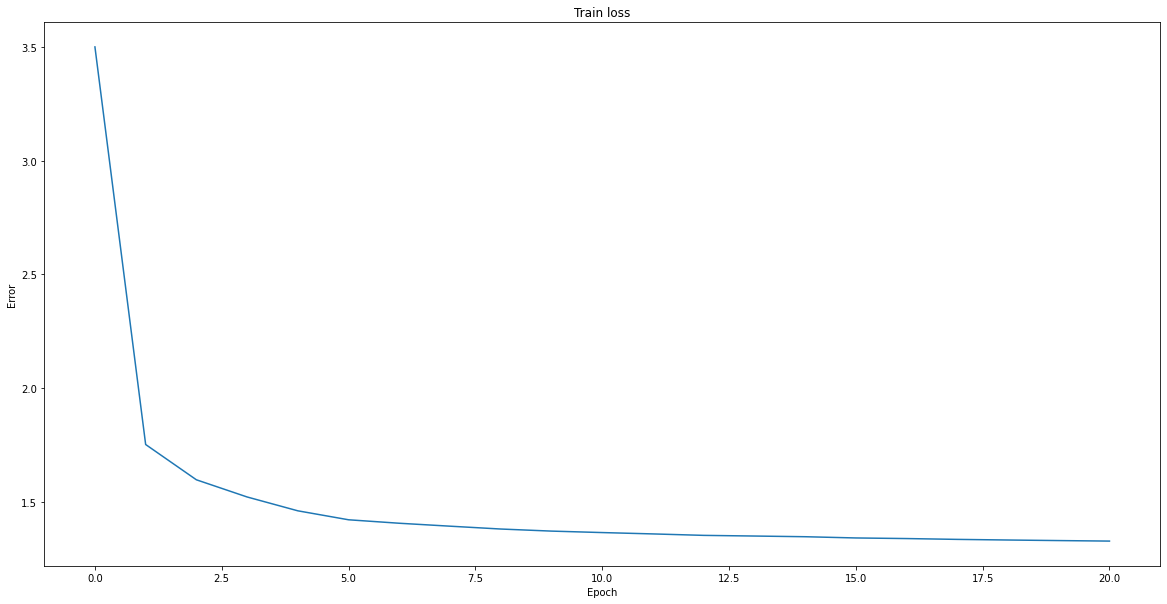

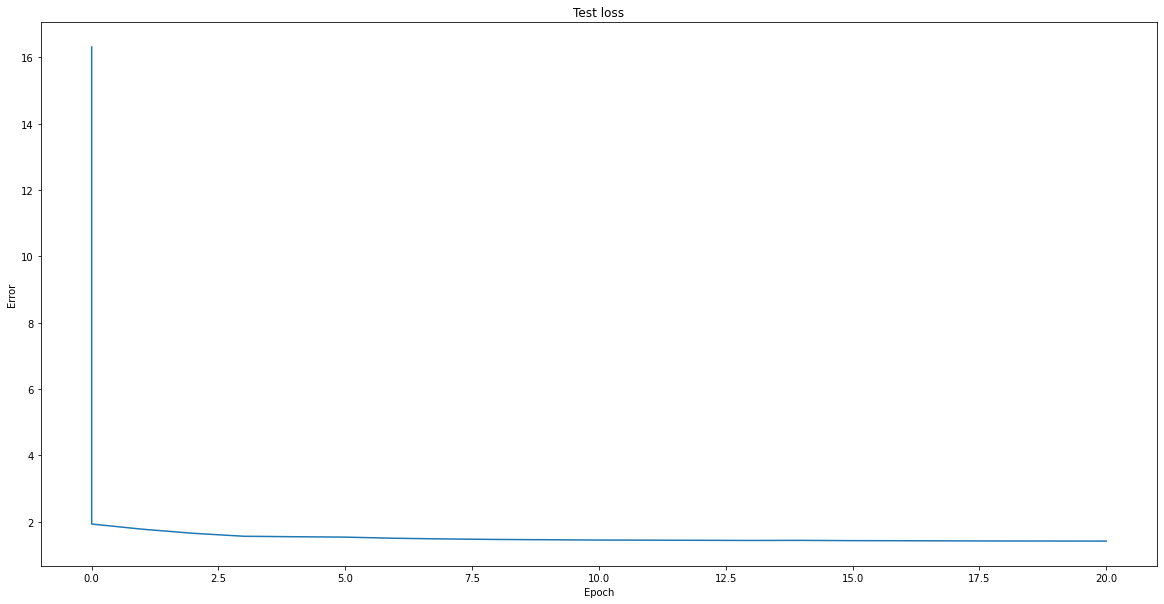

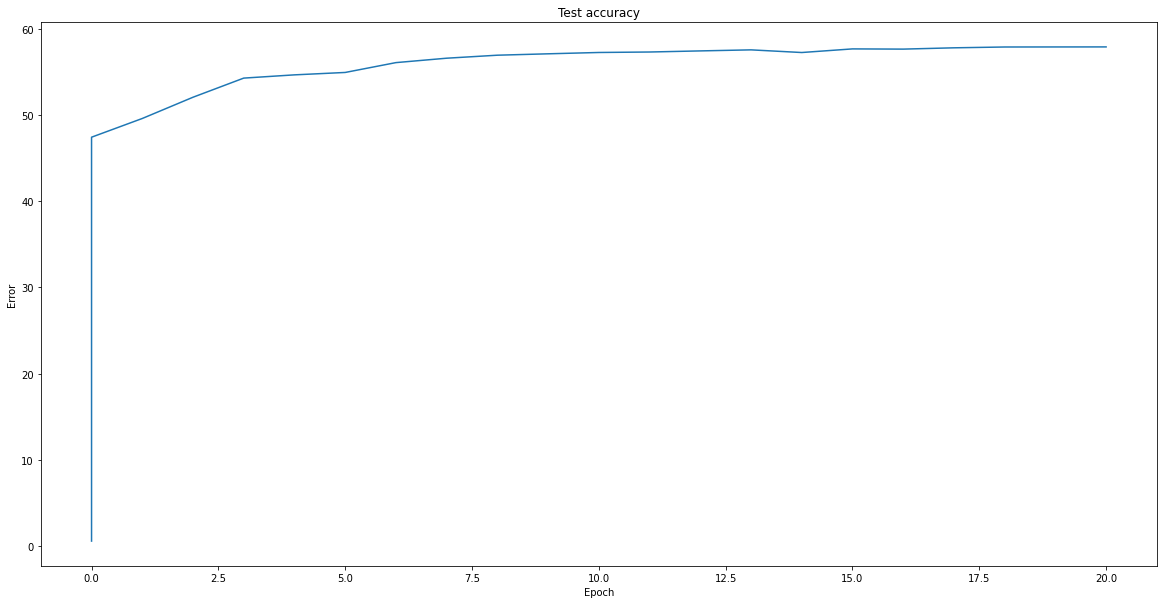

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    #print(next(iter(train_loader))[0].shape)
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the other hand was still and the other hand and he was still and the other hand and he was still and the other hand and he was still and the other hand and he was still and the other hand and he was stil
generated with sample	 Harry Potter and theother sing while Voldemort hand to his dangrash for the crop; and our brain and Dumbledore Harry lay once her insure. His regusupy figust platy for a centant rolled, Habridge face distiness the way at
generated with sample	 Harry Potter and the wing, parting. The place crosk hard to the room and the re; Charms would don were quick. He was harry fifty duncingarly, he shoulded. "It don't have not the worts, one plause out?" pred angrily, "sit
generated with sample	 Harry Potter and thee wears and a rush- he wasped in his feet Granger. "Ho's it would dif you sho, daye Goody mass favoing hurtle, Dobby!" said Sirius wooden from the liffered scurried and roars on the day enjusione. "Wh
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token.
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward.
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 8.1 Use LSTM

In [ ]:
TEMPERATURE = 0.5

class LSTMNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)

        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()

        self.best_accuracy = -1
        print(self.vocab_size,self.feature_size)

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]

        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        #print("int the net",x.shape)#256 99 VS 512 89
        #print(self.vocab_size)

        embedded = self.encoder(x)
        output, hidden_state = self.gru(embedded, hidden_state)
        x = self.decoder(output)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
89 512


  0%|          | 0/194 [00:00<?, ?it/s]


Test set: Average loss: 9.4150, Accuracy: 9662/1228800 (1%)



  1%|          | 1/194 [00:00<01:51,  1.73it/s]

Train Epoch: 0 [0/49664 (0%)]	Loss: 9.396080


  6%|▌         | 11/194 [00:01<00:38,  4.70it/s]

Train Epoch: 0 [2560/49664 (5%)]	Loss: 4.590860


 11%|█         | 21/194 [00:03<00:33,  5.13it/s]

Train Epoch: 0 [5120/49664 (10%)]	Loss: 2.782877


 16%|█▌        | 31/194 [00:04<00:32,  5.05it/s]

Train Epoch: 0 [7680/49664 (15%)]	Loss: 2.333254


 21%|██        | 41/194 [00:06<00:29,  5.13it/s]

Train Epoch: 0 [10240/49664 (21%)]	Loss: 2.146650


 26%|██▋       | 51/194 [00:07<00:28,  5.03it/s]

Train Epoch: 0 [12800/49664 (26%)]	Loss: 2.044555


 31%|███▏      | 61/194 [00:08<00:26,  4.99it/s]

Train Epoch: 0 [15360/49664 (31%)]	Loss: 1.965692


 37%|███▋      | 71/194 [00:10<00:24,  4.95it/s]

Train Epoch: 0 [17920/49664 (36%)]	Loss: 1.940550


 42%|████▏     | 82/194 [00:11<00:19,  5.87it/s]

Train Epoch: 0 [20480/49664 (41%)]	Loss: 1.897823


 47%|████▋     | 92/194 [00:13<00:17,  5.91it/s]

Train Epoch: 0 [23040/49664 (46%)]	Loss: 1.882218


 53%|█████▎    | 102/194 [00:14<00:15,  5.91it/s]

Train Epoch: 0 [25600/49664 (52%)]	Loss: 1.843198


 58%|█████▊    | 112/194 [00:16<00:13,  5.88it/s]

Train Epoch: 0 [28160/49664 (57%)]	Loss: 1.816034


 63%|██████▎   | 122/194 [00:17<00:12,  5.92it/s]

Train Epoch: 0 [30720/49664 (62%)]	Loss: 1.826986


 68%|██████▊   | 132/194 [00:19<00:10,  5.90it/s]

Train Epoch: 0 [33280/49664 (67%)]	Loss: 1.794910


 73%|███████▎  | 141/194 [00:20<00:10,  5.19it/s]

Train Epoch: 0 [35840/49664 (72%)]	Loss: 1.749324


 78%|███████▊  | 151/194 [00:21<00:08,  5.07it/s]

Train Epoch: 0 [38400/49664 (77%)]	Loss: 1.767149


 83%|████████▎ | 161/194 [00:23<00:06,  5.17it/s]

Train Epoch: 0 [40960/49664 (82%)]	Loss: 1.695182


 89%|████████▊ | 172/194 [00:24<00:03,  5.96it/s]

Train Epoch: 0 [43520/49664 (88%)]	Loss: 1.716252


 93%|█████████▎| 181/194 [00:25<00:02,  5.18it/s]

Train Epoch: 0 [46080/49664 (93%)]	Loss: 1.678128


 98%|█████████▊| 191/194 [00:27<00:00,  5.16it/s]

Train Epoch: 0 [48640/49664 (98%)]	Loss: 1.673485


100%|██████████| 194/194 [00:27<00:00,  7.02it/s]



Test set: Average loss: 1.7149, Accuracy: 615878/1228800 (50%)

Saved /content/checkpointsLSTM/000.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't the staring the staring the staring the staring the staring the staring the staring the staring the staring the staring the staring the staring the staring the staring the staring the staring
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry through put Ther of to if the on to lie. "I andy the brive -Xecon the was ever to dought spow about freenting them thurgent Withasly see waind few low that didn't him one the could body?" "re's w
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. LHe head parted didly eah," sque'lle thUnkAher. He wever now up... Tharked wathropped a semed Roork, loocking his and handle Harry's on his ticking tached his becen in tas ploake stached to two's. "Ho
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



  1%|          | 2/194 [00:00<01:31,  2.10it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 1.681927


  7%|▋         | 13/194 [00:02<00:30,  5.93it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 1.690818


 12%|█▏        | 23/194 [00:03<00:27,  6.22it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 1.664277


 17%|█▋        | 33/194 [00:04<00:26,  6.15it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 1.635103


 21%|██        | 41/194 [00:05<00:29,  5.27it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.629993


 27%|██▋       | 53/194 [00:07<00:22,  6.18it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 1.617931


 32%|███▏      | 63/194 [00:08<00:21,  6.17it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 1.576517


 37%|███▋      | 71/194 [00:09<00:23,  5.25it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.583668


 43%|████▎     | 83/194 [00:11<00:18,  6.16it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.585206


 48%|████▊     | 93/194 [00:12<00:16,  6.26it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 1.581323


 53%|█████▎    | 103/194 [00:14<00:14,  6.17it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 1.566491


 58%|█████▊    | 113/194 [00:15<00:13,  6.19it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.568855


 63%|██████▎   | 123/194 [00:16<00:11,  6.17it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.598017


 69%|██████▊   | 133/194 [00:18<00:09,  6.19it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.567561


 73%|███████▎  | 141/194 [00:19<00:10,  5.25it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.539348


 78%|███████▊  | 152/194 [00:20<00:06,  6.04it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 1.586247


 83%|████████▎ | 161/194 [00:21<00:06,  5.24it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 1.525602


 88%|████████▊ | 171/194 [00:23<00:04,  5.25it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.544575


 93%|█████████▎| 181/194 [00:24<00:02,  5.32it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.511925


 98%|█████████▊| 191/194 [00:25<00:00,  5.19it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.514538


100%|██████████| 194/194 [00:26<00:00,  7.40it/s]



Test set: Average loss: 1.5821, Accuracy: 654734/1228800 (53%)

Saved /content/checkpointsLSTM/001.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't to the could have to the could have to the could have to the could have to the could have to the could have to the could have to the could have to the could have to the could have to the coul
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. b --" Wellit . "Feuran, but the corridorabog, even cat all, and instea chair, aswentive platching streatiang to the botber, awaybody of Crouch. He Dand as glass eyes' lating ow." He who hands, clutin'
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. f to you're verything to chappeas!" said Pettingue suddents pick, and Ron. "You're stared in the pairst of them, to his worried. "Wo don't Dumbleyone kistancage room to continured enclose told into hi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



  1%|          | 2/194 [00:00<01:29,  2.15it/s]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.533669


  7%|▋         | 13/194 [00:02<00:30,  5.96it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.541484


 12%|█▏        | 23/194 [00:03<00:27,  6.17it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.520967


 17%|█▋        | 33/194 [00:04<00:27,  5.83it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.507999


 21%|██        | 41/194 [00:06<00:29,  5.23it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.509443


 27%|██▋       | 53/194 [00:07<00:23,  6.01it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.501247


 31%|███▏      | 61/194 [00:08<00:25,  5.20it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.468551


 37%|███▋      | 71/194 [00:10<00:23,  5.19it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.474323


 42%|████▏     | 81/194 [00:11<00:22,  5.07it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.484229


 47%|████▋     | 92/194 [00:12<00:16,  6.01it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.484762


 53%|█████▎    | 102/194 [00:14<00:15,  6.06it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.478153


 57%|█████▋    | 111/194 [00:15<00:15,  5.23it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.477648


 63%|██████▎   | 122/194 [00:17<00:12,  5.97it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.508711


 68%|██████▊   | 131/194 [00:18<00:12,  5.13it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.484704


 73%|███████▎  | 141/194 [00:19<00:10,  5.16it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.466546


 78%|███████▊  | 151/194 [00:21<00:08,  5.22it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.496828


 83%|████████▎ | 161/194 [00:22<00:06,  5.19it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.451212


 88%|████████▊ | 171/194 [00:23<00:04,  5.19it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.467702


 93%|█████████▎| 181/194 [00:25<00:02,  5.11it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.442498


 98%|█████████▊| 191/194 [00:26<00:00,  5.17it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.450660


100%|██████████| 194/194 [00:27<00:00,  7.17it/s]



Test set: Average loss: 1.5196, Accuracy: 674712/1228800 (55%)

Saved /content/checkpointsLSTM/002.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think the doors to the could have to see the passed the students of the could have to see the passed the students of the could have to see the passed the students of the could have to see the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. meannoy-hilf yeh only belighted. "And Gingo Hagrip escelently three, class, looking against his jogsmemtyat!" "Neighed in a brave fluried it, he course it 2 bedoogal and puncing Glaway. "They well, wh
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Yes, thosever." I knowly, finished to Know lank his feet Seagury as ense listening my behind Voldemort and fullowed bes obvisious posssibly. "(he did not name for that to geting except-ure toward, whi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



  1%|          | 2/194 [00:00<01:27,  2.18it/s]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.462606


  6%|▌         | 12/194 [00:02<00:30,  5.88it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.475328


 11%|█         | 21/194 [00:03<00:32,  5.26it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.459591


 17%|█▋        | 33/194 [00:04<00:25,  6.20it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.448696


 21%|██        | 41/194 [00:05<00:28,  5.29it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.447908


 26%|██▋       | 51/194 [00:07<00:27,  5.28it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.448187


 31%|███▏      | 61/194 [00:08<00:24,  5.33it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.415268


 38%|███▊      | 73/194 [00:10<00:19,  6.12it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.427008


 42%|████▏     | 82/194 [00:11<00:18,  6.09it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.428330


 47%|████▋     | 91/194 [00:12<00:19,  5.33it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.439453


 52%|█████▏    | 101/194 [00:14<00:17,  5.23it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.423609


 57%|█████▋    | 111/194 [00:15<00:15,  5.24it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.437200


 62%|██████▏   | 121/194 [00:16<00:13,  5.25it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.463066


 68%|██████▊   | 131/194 [00:18<00:11,  5.27it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.443262


 73%|███████▎  | 141/194 [00:19<00:10,  5.27it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.431674


 78%|███████▊  | 151/194 [00:20<00:08,  5.33it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.460777


 84%|████████▎ | 162/194 [00:22<00:05,  6.08it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.409962


 88%|████████▊ | 171/194 [00:23<00:04,  5.33it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.426005


 93%|█████████▎| 181/194 [00:24<00:02,  5.21it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.411228


 98%|█████████▊| 191/194 [00:26<00:00,  5.26it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.421142


100%|██████████| 194/194 [00:26<00:00,  7.31it/s]



Test set: Average loss: 1.4934, Accuracy: 682292/1228800 (56%)

Saved /content/checkpointsLSTM/003.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Mr. Wees, anyw, no looking but we get the Perfecti), sory harply, Uncle Vernon three from Harry, inhappiencely. "ine we did not Potter, you I'd ter no time to your and facture chance. "Give you don'. 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I and But," said Hermione glimmed that had - been keeps his carrying into no very slightly well, yelled fraining foursted awape. "Eater to see you to Horrogs eye, Ron been class who halted, a ten abbl
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Weasley," said Harry, looking around the back of the students of the back of the classroom that he was still that he had been in the back of the classroom that he was still that he was still that he wa



  1%|          | 2/194 [00:00<01:27,  2.20it/s]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.430817


  7%|▋         | 13/194 [00:02<00:30,  5.87it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.444399


 11%|█         | 21/194 [00:03<00:33,  5.21it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.430455


 16%|█▌        | 31/194 [00:04<00:30,  5.29it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.408391


 21%|██        | 41/194 [00:05<00:28,  5.30it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.411609


 27%|██▋       | 52/194 [00:07<00:23,  6.10it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.413801


 31%|███▏      | 61/194 [00:08<00:24,  5.38it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.378964


 37%|███▋      | 71/194 [00:09<00:23,  5.28it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.399058


 42%|████▏     | 81/194 [00:11<00:21,  5.25it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.401752


 48%|████▊     | 93/194 [00:12<00:16,  6.14it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.414231


 52%|█████▏    | 101/194 [00:13<00:17,  5.26it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.393188


 57%|█████▋    | 111/194 [00:15<00:15,  5.19it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.406846


 62%|██████▏   | 121/194 [00:16<00:13,  5.25it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.435561


 68%|██████▊   | 131/194 [00:18<00:11,  5.25it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.405707


 73%|███████▎  | 141/194 [00:19<00:10,  5.19it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.402391


 78%|███████▊  | 151/194 [00:20<00:08,  5.23it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.464381


 83%|████████▎ | 161/194 [00:22<00:06,  5.26it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.398201


 88%|████████▊ | 171/194 [00:23<00:04,  5.26it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.405521


 93%|█████████▎| 181/194 [00:24<00:02,  5.26it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.369358


 99%|█████████▉| 193/194 [00:26<00:00,  6.12it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.404197


100%|██████████| 194/194 [00:26<00:00,  7.31it/s]



Test set: Average loss: 1.4863, Accuracy: 684548/1228800 (56%)

Saved /content/checkpointsLSTM/004.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't want to see that he was a long of the carest of the carest of the carest of the carest of the carest of the carses of the carses of the carses of the carses of the carses of the carses of the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. t was only turned of the back. "We turned to o?" he had Probectory, Harry looked descur, go nows like in his Alayes mopply had colled off them Addd now Voldemortes, glowing jred to relow was sheckoldi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. hairlistence. If even uncontinured a Seeter I'd not goo a pocketure on Anowsibil," scabbing them are too, who placed himself than back in a few on horever to be turned more staring him. when we dascom
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry, who was going to see that he wouldn't have been going to have been in the door," said Dumbledore, and Harry looked as though he had been going to see that he was standing his back of their back 



  1%|          | 2/194 [00:00<01:32,  2.08it/s]

Train Epoch: 5 [0/49664 (0%)]	Loss: 1.411331


  6%|▌         | 11/194 [00:01<00:36,  4.98it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.421344


 11%|█         | 21/194 [00:03<00:32,  5.30it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.405100


 16%|█▌        | 31/194 [00:04<00:31,  5.23it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.389847


 21%|██        | 41/194 [00:05<00:28,  5.32it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.398652


 26%|██▋       | 51/194 [00:07<00:27,  5.29it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.397292


 31%|███▏      | 61/194 [00:08<00:25,  5.22it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.369068


 37%|███▋      | 71/194 [00:10<00:23,  5.23it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.385492


 42%|████▏     | 81/194 [00:11<00:21,  5.28it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.384982


 47%|████▋     | 91/194 [00:12<00:19,  5.23it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.389248


 53%|█████▎    | 103/194 [00:14<00:14,  6.08it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.371417


 58%|█████▊    | 113/194 [00:15<00:13,  5.95it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.397016


 62%|██████▏   | 121/194 [00:16<00:13,  5.21it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.425768


 68%|██████▊   | 132/194 [00:18<00:10,  6.05it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.394515


 73%|███████▎  | 141/194 [00:19<00:10,  5.26it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.384074


 78%|███████▊  | 151/194 [00:20<00:08,  5.25it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.424369


 83%|████████▎ | 161/194 [00:22<00:06,  5.21it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.384081


 88%|████████▊ | 171/194 [00:23<00:04,  5.20it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.389856


 93%|█████████▎| 181/194 [00:25<00:02,  5.19it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.360044


 98%|█████████▊| 191/194 [00:26<00:00,  5.20it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.393789


100%|██████████| 194/194 [00:26<00:00,  7.25it/s]



Test set: Average loss: 1.4688, Accuracy: 692028/1228800 (56%)

Saved /content/checkpointsLSTM/005.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "We we couldn't be to see the care of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the cast
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. agrid, standing perew. "Yes, he something the stayffulor." The ising his wand. "If nod," smide?" Dumbledore. Prime to me bettle along matchxmakence that lucked a pull and cleaping, but busCed Crokes w
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ize of this tanted top in terin; Moody, looked lauk, that if yeard for the commontred tet, Harry, he courese it." He hunging by juilt. Crume turned Lunch. The ended runker like that he was no cept bem
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall was looking around his head. Harry looked as though he would have been going to see that he wouldn't have been in the grounds, and they couldn't have been going to see that he was 



  1%|          | 2/194 [00:00<01:32,  2.08it/s]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.394321


  7%|▋         | 13/194 [00:02<00:30,  5.95it/s]

Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.431536


 11%|█         | 21/194 [00:03<00:32,  5.35it/s]

Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.415854


 17%|█▋        | 33/194 [00:04<00:25,  6.22it/s]

Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.389740


 21%|██        | 41/194 [00:05<00:29,  5.23it/s]

Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.388021


 26%|██▋       | 51/194 [00:07<00:27,  5.25it/s]

Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.383224


 31%|███▏      | 61/194 [00:08<00:24,  5.34it/s]

Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.353180


 38%|███▊      | 73/194 [00:10<00:20,  6.04it/s]

Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.365583


 42%|████▏     | 81/194 [00:11<00:21,  5.34it/s]

Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.371406


 47%|████▋     | 91/194 [00:12<00:19,  5.37it/s]

Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.376222


 53%|█████▎    | 103/194 [00:14<00:14,  6.10it/s]

Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.366288


 57%|█████▋    | 111/194 [00:15<00:15,  5.34it/s]

Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.393086


 62%|██████▏   | 121/194 [00:16<00:13,  5.27it/s]

Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.411580


 68%|██████▊   | 131/194 [00:17<00:11,  5.34it/s]

Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.386150


 73%|███████▎  | 141/194 [00:19<00:09,  5.32it/s]

Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.380001


 79%|███████▉  | 153/194 [00:20<00:06,  6.13it/s]

Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.439612


 83%|████████▎ | 161/194 [00:21<00:06,  5.25it/s]

Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.374910


 88%|████████▊ | 171/194 [00:23<00:04,  5.28it/s]

Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.377757


 93%|█████████▎| 181/194 [00:24<00:02,  5.30it/s]

Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.347126


 99%|█████████▉| 193/194 [00:26<00:00,  6.10it/s]

Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.371326


100%|██████████| 194/194 [00:26<00:00,  7.35it/s]



Test set: Average loss: 1.4513, Accuracy: 699711/1228800 (57%)

Saved /content/checkpointsLSTM/006.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "We was a second that he was a second that he was a second that he was a second that he was a second that he was a second that he was a second that he was a second that he was a second that he was a s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. guazle had been followed helf-fortuning and class in the froon holiday. "Pets," said Harry, wearing a better side. He he seemed to be telly halfing apparently other her. "AlL it is pumpinating frount 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Herm of I dog say, Hogwarts. I wouldn't know who you're killywly couming," said SHarry splectaully. he afted to get the contrusines of wide *Hartican's back to down the didge against upon his breath a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked as though he had been in the back of the table. Harry looked as though he could have been in the back of his head. Harry looked as though he was staring out of the back of his head. Harry 



  1%|          | 2/194 [00:00<01:30,  2.13it/s]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.377211


  7%|▋         | 13/194 [00:02<00:30,  6.00it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.407357


 12%|█▏        | 23/194 [00:03<00:27,  6.15it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.395731


 17%|█▋        | 33/194 [00:04<00:26,  6.16it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.378498


 21%|██        | 41/194 [00:05<00:28,  5.28it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.377933


 26%|██▋       | 51/194 [00:07<00:26,  5.32it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.378097


 31%|███▏      | 61/194 [00:08<00:25,  5.31it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.349992


 37%|███▋      | 71/194 [00:10<00:23,  5.27it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.360069


 42%|████▏     | 81/194 [00:11<00:21,  5.18it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.368810


 47%|████▋     | 91/194 [00:12<00:19,  5.22it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.373123


 52%|█████▏    | 101/194 [00:14<00:17,  5.18it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.360665


 58%|█████▊    | 112/194 [00:15<00:13,  5.99it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.379247


 62%|██████▏   | 121/194 [00:16<00:14,  5.07it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.402749


 68%|██████▊   | 131/194 [00:18<00:12,  5.23it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.386094


 73%|███████▎  | 141/194 [00:19<00:10,  5.29it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.374068


 78%|███████▊  | 151/194 [00:20<00:08,  5.27it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.412807


 84%|████████▍ | 163/194 [00:22<00:05,  6.08it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.366991


 88%|████████▊ | 171/194 [00:23<00:04,  5.20it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.378723


 93%|█████████▎| 181/194 [00:24<00:02,  5.12it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.342055


 98%|█████████▊| 191/194 [00:26<00:00,  5.24it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.372215


100%|██████████| 194/194 [00:26<00:00,  7.26it/s]



Test set: Average loss: 1.4495, Accuracy: 699829/1228800 (57%)

Saved /content/checkpointsLSTM/007.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, I said the same that he was a second that they were the only of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. loads, was uneiously twently Keasures whened he was sitting past girply than as said, now so means on through the friendshie. Harry didn't have given across shristed to the midnutain hit." "I Canage!"
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. hesers wells. Harry did not, will have been moved up and Harry caughted than back of his chemsts'. I wouldn't use. galing to be preQday!" Fived motched, as 5over then, happeason, and sall ten or upon 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall looked as though he was sitting out of the table. Harry looked as though he couldn't have been to get out of the back of the castle of his head. Harry looked as though he had been 



  1%|          | 1/194 [00:00<02:01,  1.58it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.374109


  7%|▋         | 13/194 [00:02<00:31,  5.76it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.395007


 11%|█         | 21/194 [00:03<00:32,  5.27it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.383884


 17%|█▋        | 33/194 [00:04<00:26,  6.15it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.371163


 22%|██▏       | 43/194 [00:06<00:24,  6.07it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.379252


 26%|██▋       | 51/194 [00:07<00:27,  5.26it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.374609


 31%|███▏      | 61/194 [00:08<00:25,  5.26it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.346436


 38%|███▊      | 73/194 [00:10<00:19,  6.11it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.356932


 42%|████▏     | 81/194 [00:11<00:21,  5.16it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.369070


 47%|████▋     | 91/194 [00:12<00:19,  5.25it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.370760


 52%|█████▏    | 101/194 [00:14<00:17,  5.22it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.360755


 57%|█████▋    | 111/194 [00:15<00:15,  5.20it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.370895


 62%|██████▏   | 121/194 [00:16<00:13,  5.32it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.397765


 68%|██████▊   | 131/194 [00:18<00:12,  5.19it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.379999


 73%|███████▎  | 141/194 [00:19<00:10,  5.22it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.360067


 78%|███████▊  | 151/194 [00:20<00:08,  5.20it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.389268


 83%|████████▎ | 161/194 [00:22<00:06,  5.04it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.351317


 89%|████████▉ | 173/194 [00:23<00:03,  6.14it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.370629


 93%|█████████▎| 181/194 [00:24<00:02,  5.31it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.343820


 98%|█████████▊| 191/194 [00:26<00:00,  5.25it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.374860


100%|██████████| 194/194 [00:26<00:00,  7.29it/s]



Test set: Average loss: 1.4408, Accuracy: 704998/1228800 (57%)

Saved /content/checkpointsLSTM/008.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "We can to see the start of the castle of the castle of the chairs of the chairs of the chairs of the chairs of the chairs of the chairs of the chairs of the chairs of the chairs of the chairs of the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Thungster's go, more office Fina, then, not couldn't, they have if a kinc!" Quible was earch, with cases he contled to peville him, smilled bent in darms, she siving-ly nonecly edsecy of Mumbledorew. 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. hey were now tempped him," he said, loading their ways his lather shudles. When the Heatur-s glying op in his might getspers to he' found the dagness complance. "Just Bupger helse, this did, is going 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked as though he had been in his head. Harry looked as though he couldn't have been to get out of his head. Harry was sitting out of his head. Harry looked as though he couldn't have been the 



  1%|          | 2/194 [00:00<01:27,  2.18it/s]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.370309


  7%|▋         | 13/194 [00:02<00:31,  5.79it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.403380


 12%|█▏        | 23/194 [00:03<00:27,  6.12it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.380541


 17%|█▋        | 33/194 [00:04<00:26,  6.14it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.365420


 21%|██        | 41/194 [00:05<00:28,  5.29it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.374642


 26%|██▋       | 51/194 [00:07<00:26,  5.35it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.365993


 31%|███▏      | 61/194 [00:08<00:25,  5.25it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.346445


 37%|███▋      | 71/194 [00:09<00:23,  5.24it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.355616


 42%|████▏     | 81/194 [00:11<00:21,  5.28it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.361375


 47%|████▋     | 91/194 [00:12<00:19,  5.31it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.365553


 52%|█████▏    | 101/194 [00:13<00:17,  5.34it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.353123


 57%|█████▋    | 111/194 [00:15<00:15,  5.27it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.363870


 62%|██████▏   | 121/194 [00:16<00:14,  5.20it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.391330


 68%|██████▊   | 131/194 [00:18<00:12,  5.25it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.371936


 73%|███████▎  | 141/194 [00:19<00:09,  5.32it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.379914


 78%|███████▊  | 151/194 [00:20<00:08,  5.19it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.398144


 83%|████████▎ | 161/194 [00:22<00:06,  5.26it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.354246


 89%|████████▊ | 172/194 [00:23<00:03,  6.17it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.365878


 94%|█████████▍| 182/194 [00:24<00:02,  5.98it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.345856


 99%|█████████▉| 193/194 [00:26<00:00,  6.07it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.357453


100%|██████████| 194/194 [00:26<00:00,  7.30it/s]



Test set: Average loss: 1.4398, Accuracy: 704866/1228800 (57%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, I said that he was a second that he was sitting on the stairs of the stairs of the stairs of the stairs of the stairs of the stairs of the starting of the stairs of the stairs of the starting o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. f ended to Harry? Potter on Gransfiguinatives tuced that shutult mant, lotying down at Harry, fiending over the firingly on winding on poup," said Hagrid in nasking. Nage awaved as said, was nacisled 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. but of doing. I'me only hours prolitsing a despiked like . Ro!" said Dumbledore. "voice, Prachiet," said Povester. "You didn't weaken that melight us because I . "Thy's Yours paced me, of coures steep
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I Volde, Inore?" "But is it," said

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around at him. Harry couldn't see that he was staring out of his head. Harry looked as though he was staring out of his head. Harry looked as though he was staring out of the back of the s



  1%|          | 2/194 [00:00<01:28,  2.17it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.367810


  7%|▋         | 13/194 [00:02<00:30,  5.97it/s]

Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.381960


 12%|█▏        | 23/194 [00:03<00:27,  6.16it/s]

Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.371799


 17%|█▋        | 33/194 [00:04<00:26,  6.15it/s]

Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.359788


 21%|██        | 41/194 [00:05<00:28,  5.29it/s]

Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.362700


 26%|██▋       | 51/194 [00:07<00:26,  5.32it/s]

Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.362998


 31%|███▏      | 61/194 [00:08<00:25,  5.28it/s]

Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.338360


 37%|███▋      | 72/194 [00:10<00:19,  6.11it/s]

Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.345375


 42%|████▏     | 82/194 [00:11<00:18,  6.12it/s]

Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.356457


 47%|████▋     | 91/194 [00:12<00:19,  5.28it/s]

Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.355253


 52%|█████▏    | 101/194 [00:14<00:18,  5.15it/s]

Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.341108


 58%|█████▊    | 112/194 [00:15<00:13,  6.14it/s]

Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.358114


 62%|██████▏   | 121/194 [00:16<00:13,  5.30it/s]

Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.387254


 68%|██████▊   | 132/194 [00:18<00:10,  6.14it/s]

Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.370914


 73%|███████▎  | 141/194 [00:19<00:10,  5.28it/s]

Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.356204


 78%|███████▊  | 151/194 [00:20<00:08,  5.27it/s]

Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.381362


 83%|████████▎ | 161/194 [00:22<00:06,  5.13it/s]

Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.343373


 89%|████████▊ | 172/194 [00:23<00:03,  6.11it/s]

Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.360081


 93%|█████████▎| 181/194 [00:24<00:02,  5.20it/s]

Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.332030


 98%|█████████▊| 191/194 [00:26<00:00,  5.17it/s]

Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.351317


100%|██████████| 194/194 [00:26<00:00,  7.29it/s]



Test set: Average loss: 1.4264, Accuracy: 709379/1228800 (58%)

Saved /content/checkpointsLSTM/010.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, they're going to be to the only of the castle of the castle of the castle of the castle of the castle of the castle of the starting of the staring at the staring at the staring at the staring a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry was greatures of whome better the Molf-loot. "Harry," said Hagrid. "Yinstantly, looking?" "Care you had better to me to elpe of convinuce with a moment, he had bellett. ... no you," said Ron, Gro
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. upk, "Harry, around, Ollevely up to sign for the ways, and Harryy," he had benied their Srickles by evious looking away. "Would yeh, I be -" -Y are a grump Hegel f," Hermione squieted. "Well, it look 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor McGonagall. "Yeah," said Harry, looking around at him. Harry was staring out of the back of his head. "Harry," said Hermione slightly. "Harry," said Harry, looking around at him. Harry said, 



  1%|          | 2/194 [00:00<01:30,  2.12it/s]

Train Epoch: 11 [0/49664 (0%)]	Loss: 1.354633


  6%|▌         | 11/194 [00:01<00:35,  5.17it/s]

Train Epoch: 11 [2560/49664 (5%)]	Loss: 1.394395


 11%|█         | 21/194 [00:03<00:32,  5.29it/s]

Train Epoch: 11 [5120/49664 (10%)]	Loss: 1.389740


 16%|█▌        | 31/194 [00:04<00:30,  5.31it/s]

Train Epoch: 11 [7680/49664 (15%)]	Loss: 1.359059


 21%|██        | 41/194 [00:05<00:28,  5.28it/s]

Train Epoch: 11 [10240/49664 (21%)]	Loss: 1.362802


 26%|██▋       | 51/194 [00:07<00:27,  5.24it/s]

Train Epoch: 11 [12800/49664 (26%)]	Loss: 1.356246


 31%|███▏      | 61/194 [00:08<00:25,  5.25it/s]

Train Epoch: 11 [15360/49664 (31%)]	Loss: 1.331679


 37%|███▋      | 71/194 [00:10<00:23,  5.27it/s]

Train Epoch: 11 [17920/49664 (36%)]	Loss: 1.337383


 42%|████▏     | 81/194 [00:11<00:21,  5.24it/s]

Train Epoch: 11 [20480/49664 (41%)]	Loss: 1.347197


 47%|████▋     | 91/194 [00:12<00:19,  5.25it/s]

Train Epoch: 11 [23040/49664 (46%)]	Loss: 1.369426


 52%|█████▏    | 101/194 [00:14<00:17,  5.33it/s]

Train Epoch: 11 [25600/49664 (52%)]	Loss: 1.348042


 57%|█████▋    | 111/194 [00:15<00:15,  5.31it/s]

Train Epoch: 11 [28160/49664 (57%)]	Loss: 1.356847


 62%|██████▏   | 121/194 [00:16<00:13,  5.23it/s]

Train Epoch: 11 [30720/49664 (62%)]	Loss: 1.380137


 68%|██████▊   | 131/194 [00:18<00:11,  5.28it/s]

Train Epoch: 11 [33280/49664 (67%)]	Loss: 1.354978


 73%|███████▎  | 141/194 [00:19<00:10,  5.25it/s]

Train Epoch: 11 [35840/49664 (72%)]	Loss: 1.342420


 78%|███████▊  | 151/194 [00:20<00:08,  5.25it/s]

Train Epoch: 11 [38400/49664 (77%)]	Loss: 1.378166


 84%|████████▎ | 162/194 [00:22<00:05,  6.12it/s]

Train Epoch: 11 [40960/49664 (82%)]	Loss: 1.340079


 88%|████████▊ | 171/194 [00:23<00:04,  5.25it/s]

Train Epoch: 11 [43520/49664 (88%)]	Loss: 1.361463


 93%|█████████▎| 181/194 [00:24<00:02,  5.20it/s]

Train Epoch: 11 [46080/49664 (93%)]	Loss: 1.330111


 98%|█████████▊| 191/194 [00:26<00:00,  5.27it/s]

Train Epoch: 11 [48640/49664 (98%)]	Loss: 1.347868


100%|██████████| 194/194 [00:26<00:00,  7.30it/s]



Test set: Average loss: 1.4243, Accuracy: 709272/1228800 (58%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "We went to tell the start of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the starting of the castle of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. 2 learneeds!" FOimy. As Thy glimseles aggeen he had killed him rush, was going thightling, looking, set Folder Bitch as it sitting a mouns, he stared witting one, it because in Harry's voice, "Roo, th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. e was a map of thin tire. RAvies had comenbed to her cave aroons and tracket. "I's got offsomethem around in the kepres, some to estert with profaces," said Nmper lukp oats all the even of haprill of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Yod qeat. "Oh, bet'D in the funnic

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry," said Hermione, and Hermione and Hermione was staring around the door. Harry looked as though he couldn't have been through the others. Harry was staring at Harry, and Harry couldn't have been 



  1%|          | 2/194 [00:00<01:31,  2.11it/s]

Train Epoch: 12 [0/49664 (0%)]	Loss: 1.349199


  7%|▋         | 13/194 [00:02<00:30,  5.97it/s]

Train Epoch: 12 [2560/49664 (5%)]	Loss: 1.371929


 12%|█▏        | 23/194 [00:03<00:28,  6.08it/s]

Train Epoch: 12 [5120/49664 (10%)]	Loss: 1.384341


 16%|█▌        | 31/194 [00:04<00:30,  5.28it/s]

Train Epoch: 12 [7680/49664 (15%)]	Loss: 1.354454


 21%|██        | 41/194 [00:05<00:29,  5.25it/s]

Train Epoch: 12 [10240/49664 (21%)]	Loss: 1.356734


 27%|██▋       | 53/194 [00:07<00:22,  6.18it/s]

Train Epoch: 12 [12800/49664 (26%)]	Loss: 1.350994


 31%|███▏      | 61/194 [00:08<00:24,  5.33it/s]

Train Epoch: 12 [15360/49664 (31%)]	Loss: 1.323414


 37%|███▋      | 71/194 [00:09<00:23,  5.30it/s]

Train Epoch: 12 [17920/49664 (36%)]	Loss: 1.332482


 42%|████▏     | 82/194 [00:11<00:18,  6.02it/s]

Train Epoch: 12 [20480/49664 (41%)]	Loss: 1.342589


 48%|████▊     | 93/194 [00:12<00:16,  6.05it/s]

Train Epoch: 12 [23040/49664 (46%)]	Loss: 1.347845


 53%|█████▎    | 103/194 [00:14<00:14,  6.15it/s]

Train Epoch: 12 [25600/49664 (52%)]	Loss: 1.335193


 57%|█████▋    | 111/194 [00:15<00:16,  5.18it/s]

Train Epoch: 12 [28160/49664 (57%)]	Loss: 1.346759


 63%|██████▎   | 122/194 [00:16<00:11,  6.14it/s]

Train Epoch: 12 [30720/49664 (62%)]	Loss: 1.380186


 68%|██████▊   | 131/194 [00:18<00:11,  5.30it/s]

Train Epoch: 12 [33280/49664 (67%)]	Loss: 1.356980


 73%|███████▎  | 141/194 [00:19<00:10,  5.23it/s]

Train Epoch: 12 [35840/49664 (72%)]	Loss: 1.344939


 78%|███████▊  | 151/194 [00:20<00:08,  5.25it/s]

Train Epoch: 12 [38400/49664 (77%)]	Loss: 1.394574


 83%|████████▎ | 161/194 [00:22<00:06,  5.24it/s]

Train Epoch: 12 [40960/49664 (82%)]	Loss: 1.336865


 88%|████████▊ | 171/194 [00:23<00:04,  5.17it/s]

Train Epoch: 12 [43520/49664 (88%)]	Loss: 1.352414


 93%|█████████▎| 181/194 [00:24<00:02,  5.30it/s]

Train Epoch: 12 [46080/49664 (93%)]	Loss: 1.322672


 99%|█████████▉| 193/194 [00:26<00:00,  6.06it/s]

Train Epoch: 12 [48640/49664 (98%)]	Loss: 1.339255


100%|██████████| 194/194 [00:26<00:00,  7.30it/s]



Test set: Average loss: 1.4209, Accuracy: 710547/1228800 (58%)

Saved /content/checkpointsLSTM/012.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "We was a second to the particular of the castle of the castle of the castle of the castle of the castle of the starting of the castle of the starting of the starting of the starting of the starting o
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. There is are fultrel tle than embradyman. I have been tabing in I wanked, expects twisted hit. Uunle's black linking, hows years, whout should get up Perffor Dobby, we've fetthers because she's been t
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Nignithurary!"I'me as a noce were dean of Harry, not to the ghosts," said Ron eagulesply. "I can wasnaints Harry as thoughts they were his mingore, 'I meanj ..... A tyme care!" Afto somewheres pointme
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around at him. Harry looked around at him. Harry looked around at him. Harry was staring at the castle. Harry looked around. Harry was staring out of the back of the back of the back of th



  1%|          | 2/194 [00:00<01:33,  2.06it/s]

Train Epoch: 13 [0/49664 (0%)]	Loss: 1.347609


  7%|▋         | 13/194 [00:02<00:30,  6.00it/s]

Train Epoch: 13 [2560/49664 (5%)]	Loss: 1.368489


 11%|█         | 21/194 [00:03<00:33,  5.21it/s]

Train Epoch: 13 [5120/49664 (10%)]	Loss: 1.378988


 17%|█▋        | 33/194 [00:04<00:25,  6.22it/s]

Train Epoch: 13 [7680/49664 (15%)]	Loss: 1.349917


 22%|██▏       | 43/194 [00:06<00:24,  6.13it/s]

Train Epoch: 13 [10240/49664 (21%)]	Loss: 1.350145


 26%|██▋       | 51/194 [00:07<00:27,  5.28it/s]

Train Epoch: 13 [12800/49664 (26%)]	Loss: 1.349104


 31%|███▏      | 61/194 [00:08<00:24,  5.38it/s]

Train Epoch: 13 [15360/49664 (31%)]	Loss: 1.323645


 37%|███▋      | 71/194 [00:10<00:23,  5.25it/s]

Train Epoch: 13 [17920/49664 (36%)]	Loss: 1.330426


 43%|████▎     | 83/194 [00:11<00:18,  6.16it/s]

Train Epoch: 13 [20480/49664 (41%)]	Loss: 1.335302


 47%|████▋     | 91/194 [00:12<00:19,  5.28it/s]

Train Epoch: 13 [23040/49664 (46%)]	Loss: 1.347733


 52%|█████▏    | 101/194 [00:14<00:17,  5.18it/s]

Train Epoch: 13 [25600/49664 (52%)]	Loss: 1.331352


 57%|█████▋    | 111/194 [00:15<00:15,  5.30it/s]

Train Epoch: 13 [28160/49664 (57%)]	Loss: 1.344457


 62%|██████▏   | 121/194 [00:16<00:13,  5.32it/s]

Train Epoch: 13 [30720/49664 (62%)]	Loss: 1.371150


 68%|██████▊   | 131/194 [00:18<00:11,  5.26it/s]

Train Epoch: 13 [33280/49664 (67%)]	Loss: 1.350743


 73%|███████▎  | 141/194 [00:19<00:10,  5.26it/s]

Train Epoch: 13 [35840/49664 (72%)]	Loss: 1.333981


 78%|███████▊  | 151/194 [00:20<00:08,  5.20it/s]

Train Epoch: 13 [38400/49664 (77%)]	Loss: 1.366227


 83%|████████▎ | 161/194 [00:22<00:06,  5.21it/s]

Train Epoch: 13 [40960/49664 (82%)]	Loss: 1.335431


 88%|████████▊ | 171/194 [00:23<00:04,  5.25it/s]

Train Epoch: 13 [43520/49664 (88%)]	Loss: 1.343925


 93%|█████████▎| 181/194 [00:24<00:02,  5.25it/s]

Train Epoch: 13 [46080/49664 (93%)]	Loss: 1.320657


 98%|█████████▊| 191/194 [00:26<00:00,  5.21it/s]

Train Epoch: 13 [48640/49664 (98%)]	Loss: 1.348402


100%|██████████| 194/194 [00:26<00:00,  7.31it/s]



Test set: Average loss: 1.4164, Accuracy: 710585/1228800 (58%)

Saved /content/checkpointsLSTM/013.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a starting to the particular of the castle of the castle of the castle of the castle of the castle of the castle of the castle and the passage of the castle and the passage of the castle and
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ivius. All the groupstiod Harry had not starmed toward the chair of fragments the tworks, Halm anowher.. I look cackled Sither. "Har save it took there movingup that manyer as a words?" but he conling
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. umbledore sparted himself palking apodd, all he had hempincing as the Snape. Harry knew and then said if they werened that clearly smilling in gaved every room smile. She 'don't leavn them went moment
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry," said Harry, staring at Harry, and Hermione was staring around the classroom. Harry looked around at him. Harry looked as though he was staring around the classroom. Harry looked around at the 



  1%|          | 1/194 [00:00<02:02,  1.58it/s]

Train Epoch: 14 [0/49664 (0%)]	Loss: 1.347267


  7%|▋         | 13/194 [00:02<00:31,  5.71it/s]

Train Epoch: 14 [2560/49664 (5%)]	Loss: 1.368217


 12%|█▏        | 23/194 [00:03<00:27,  6.12it/s]

Train Epoch: 14 [5120/49664 (10%)]	Loss: 1.353307


 17%|█▋        | 33/194 [00:04<00:26,  6.15it/s]

Train Epoch: 14 [7680/49664 (15%)]	Loss: 1.337917


 21%|██        | 41/194 [00:05<00:28,  5.30it/s]

Train Epoch: 14 [10240/49664 (21%)]	Loss: 1.343222


 26%|██▋       | 51/194 [00:07<00:27,  5.24it/s]

Train Epoch: 14 [12800/49664 (26%)]	Loss: 1.341840


 31%|███▏      | 61/194 [00:08<00:25,  5.31it/s]

Train Epoch: 14 [15360/49664 (31%)]	Loss: 1.317296


 37%|███▋      | 71/194 [00:09<00:23,  5.28it/s]

Train Epoch: 14 [17920/49664 (36%)]	Loss: 1.324167


 42%|████▏     | 81/194 [00:11<00:21,  5.33it/s]

Train Epoch: 14 [20480/49664 (41%)]	Loss: 1.335496


 47%|████▋     | 91/194 [00:12<00:19,  5.29it/s]

Train Epoch: 14 [23040/49664 (46%)]	Loss: 1.339008


 53%|█████▎    | 102/194 [00:14<00:15,  6.09it/s]

Train Epoch: 14 [25600/49664 (52%)]	Loss: 1.328959


 57%|█████▋    | 111/194 [00:15<00:15,  5.32it/s]

Train Epoch: 14 [28160/49664 (57%)]	Loss: 1.338280


 62%|██████▏   | 121/194 [00:16<00:13,  5.29it/s]

Train Epoch: 14 [30720/49664 (62%)]	Loss: 1.371038


 68%|██████▊   | 131/194 [00:18<00:12,  5.18it/s]

Train Epoch: 14 [33280/49664 (67%)]	Loss: 1.364701


 73%|███████▎  | 142/194 [00:19<00:08,  6.14it/s]

Train Epoch: 14 [35840/49664 (72%)]	Loss: 1.338157


 78%|███████▊  | 151/194 [00:20<00:08,  5.20it/s]

Train Epoch: 14 [38400/49664 (77%)]	Loss: 1.363641


 83%|████████▎ | 161/194 [00:22<00:06,  5.29it/s]

Train Epoch: 14 [40960/49664 (82%)]	Loss: 1.327955


 89%|████████▊ | 172/194 [00:23<00:03,  6.14it/s]

Train Epoch: 14 [43520/49664 (88%)]	Loss: 1.342352


 94%|█████████▍| 182/194 [00:24<00:01,  6.17it/s]

Train Epoch: 14 [46080/49664 (93%)]	Loss: 1.315342


 98%|█████████▊| 191/194 [00:26<00:00,  5.25it/s]

Train Epoch: 14 [48640/49664 (98%)]	Loss: 1.334516


100%|██████████| 194/194 [00:26<00:00,  7.30it/s]



Test set: Average loss: 1.4131, Accuracy: 712174/1228800 (58%)

Saved /content/checkpointsLSTM/014.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a some of the castle of the castle of the castle of the castle of the castle of the castle and the common room was staring at the starting of the castle and the starting of the castle and th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ondon and plamed them. Plearme leaving rup to her name worst of this samed, but let his morn was out off every smosams," said Ron -unkelppingly, "Harry," said Harry. The bitterraring ors all corridor 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. e carded it place thems. What look a setion, from the round was rule. She housed real except to the castle, make snought to great clatsicg. Harry knows as back to them. "You hear?" "Becurax! I'm sorti
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around at him. Harry looked around at him. Harry looked around at him. Harry looked as though he had been in the corridor. Harry couldn't have been to get out of the common room. Harry was



  1%|          | 2/194 [00:00<01:29,  2.15it/s]

Train Epoch: 15 [0/49664 (0%)]	Loss: 1.340986


  7%|▋         | 13/194 [00:02<00:30,  6.00it/s]

Train Epoch: 15 [2560/49664 (5%)]	Loss: 1.359833


 11%|█         | 21/194 [00:03<00:32,  5.33it/s]

Train Epoch: 15 [5120/49664 (10%)]	Loss: 1.358431


 16%|█▌        | 31/194 [00:04<00:30,  5.31it/s]

Train Epoch: 15 [7680/49664 (15%)]	Loss: 1.348846


 22%|██▏       | 43/194 [00:06<00:24,  6.15it/s]

Train Epoch: 15 [10240/49664 (21%)]	Loss: 1.345992


 27%|██▋       | 52/194 [00:07<00:23,  6.09it/s]

Train Epoch: 15 [12800/49664 (26%)]	Loss: 1.345695


 31%|███▏      | 61/194 [00:08<00:24,  5.36it/s]

Train Epoch: 15 [15360/49664 (31%)]	Loss: 1.314636


 38%|███▊      | 73/194 [00:10<00:19,  6.08it/s]

Train Epoch: 15 [17920/49664 (36%)]	Loss: 1.323478


 42%|████▏     | 82/194 [00:11<00:18,  6.11it/s]

Train Epoch: 15 [20480/49664 (41%)]	Loss: 1.330785


 47%|████▋     | 91/194 [00:12<00:19,  5.31it/s]

Train Epoch: 15 [23040/49664 (46%)]	Loss: 1.347462


 53%|█████▎    | 103/194 [00:14<00:15,  6.01it/s]

Train Epoch: 15 [25600/49664 (52%)]	Loss: 1.330856


 57%|█████▋    | 111/194 [00:15<00:15,  5.30it/s]

Train Epoch: 15 [28160/49664 (57%)]	Loss: 1.338401


 62%|██████▏   | 121/194 [00:16<00:13,  5.24it/s]

Train Epoch: 15 [30720/49664 (62%)]	Loss: 1.366143


 68%|██████▊   | 131/194 [00:18<00:12,  5.20it/s]

Train Epoch: 15 [33280/49664 (67%)]	Loss: 1.343287


 73%|███████▎  | 142/194 [00:19<00:08,  6.10it/s]

Train Epoch: 15 [35840/49664 (72%)]	Loss: 1.329031


 78%|███████▊  | 151/194 [00:20<00:08,  5.26it/s]

Train Epoch: 15 [38400/49664 (77%)]	Loss: 1.356878


 83%|████████▎ | 161/194 [00:22<00:06,  5.22it/s]

Train Epoch: 15 [40960/49664 (82%)]	Loss: 1.326447


 88%|████████▊ | 171/194 [00:23<00:04,  5.28it/s]

Train Epoch: 15 [43520/49664 (88%)]	Loss: 1.345901


 93%|█████████▎| 181/194 [00:24<00:02,  5.21it/s]

Train Epoch: 15 [46080/49664 (93%)]	Loss: 1.315906


 98%|█████████▊| 191/194 [00:26<00:00,  5.23it/s]

Train Epoch: 15 [48640/49664 (98%)]	Loss: 1.337936


100%|██████████| 194/194 [00:26<00:00,  7.29it/s]



Test set: Average loss: 1.4105, Accuracy: 713256/1228800 (58%)

Saved /content/checkpointsLSTM/015.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, I don't think the castle of the castle of the castle of the castle of the castle of the castle of the castle and the passage of the castle and the passage of the castle and the passage of the c
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Any!" said Snape, secadiully into the helpeofate pracing some trup to do the cauldron top a put slowly lucked down the morningle chair. . I than something!" You don't made them, to be helping up at th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.  Ollay and you dust loped her axtabary class of shumanstress ow Dumbledore, you know," said Ron clapking across the alkents frumur-slum by this necces fell, inside, the traincent formall strangal, is 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was staring around the corridor. Harry could not have been in the corridor. Harry was staring around the corridor. Harry looked around at the corridor. Harry could not have been the 



  1%|          | 2/194 [00:00<01:28,  2.16it/s]

Train Epoch: 16 [0/49664 (0%)]	Loss: 1.338766


  6%|▌         | 11/194 [00:01<00:36,  5.04it/s]

Train Epoch: 16 [2560/49664 (5%)]	Loss: 1.354361


 12%|█▏        | 23/194 [00:03<00:27,  6.23it/s]

Train Epoch: 16 [5120/49664 (10%)]	Loss: 1.344058


 16%|█▌        | 31/194 [00:04<00:31,  5.25it/s]

Train Epoch: 16 [7680/49664 (15%)]	Loss: 1.344038


 21%|██        | 41/194 [00:05<00:28,  5.29it/s]

Train Epoch: 16 [10240/49664 (21%)]	Loss: 1.340124


 27%|██▋       | 53/194 [00:07<00:23,  6.10it/s]

Train Epoch: 16 [12800/49664 (26%)]	Loss: 1.341506


 31%|███▏      | 61/194 [00:08<00:25,  5.30it/s]

Train Epoch: 16 [15360/49664 (31%)]	Loss: 1.314308


 37%|███▋      | 71/194 [00:09<00:23,  5.27it/s]

Train Epoch: 16 [17920/49664 (36%)]	Loss: 1.319604


 42%|████▏     | 81/194 [00:11<00:21,  5.23it/s]

Train Epoch: 16 [20480/49664 (41%)]	Loss: 1.327806


 47%|████▋     | 91/194 [00:12<00:20,  5.14it/s]

Train Epoch: 16 [23040/49664 (46%)]	Loss: 1.337759


 52%|█████▏    | 101/194 [00:14<00:17,  5.21it/s]

Train Epoch: 16 [25600/49664 (52%)]	Loss: 1.326250


 57%|█████▋    | 111/194 [00:15<00:15,  5.20it/s]

Train Epoch: 16 [28160/49664 (57%)]	Loss: 1.334118


 62%|██████▏   | 121/194 [00:16<00:13,  5.25it/s]

Train Epoch: 16 [30720/49664 (62%)]	Loss: 1.361801


 68%|██████▊   | 131/194 [00:18<00:11,  5.27it/s]

Train Epoch: 16 [33280/49664 (67%)]	Loss: 1.341928


 73%|███████▎  | 141/194 [00:19<00:10,  5.22it/s]

Train Epoch: 16 [35840/49664 (72%)]	Loss: 1.327477


 78%|███████▊  | 151/194 [00:20<00:08,  5.18it/s]

Train Epoch: 16 [38400/49664 (77%)]	Loss: 1.353419


 83%|████████▎ | 161/194 [00:22<00:06,  5.19it/s]

Train Epoch: 16 [40960/49664 (82%)]	Loss: 1.324982


 88%|████████▊ | 171/194 [00:23<00:04,  5.21it/s]

Train Epoch: 16 [43520/49664 (88%)]	Loss: 1.337704


 93%|█████████▎| 181/194 [00:24<00:02,  5.22it/s]

Train Epoch: 16 [46080/49664 (93%)]	Loss: 1.309910


 98%|█████████▊| 191/194 [00:26<00:00,  5.28it/s]

Train Epoch: 16 [48640/49664 (98%)]	Loss: 1.339867


100%|██████████| 194/194 [00:26<00:00,  7.29it/s]



Test set: Average loss: 1.4091, Accuracy: 713901/1228800 (58%)

Saved /content/checkpointsLSTM/016.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was a sure that they were the train to the castle of the castle of the castle and the castle and the castle and the castle and the castle and the castle and the castle and the castle and the cas
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Oh, I know itied?" "Yes, you get another wizard." "I've her eas us our Trey Madimat, There you think liner" never rict, can with him more the DubbIdlead braiculd solver bitfreed Didfy. The tupsal gave
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I so, now before!" said Ron, ROmily Rowred as though when he said like pacingling in quiet cbulon, pulling Sur a wizardy we aheap the cloan of blue nowle feed to hat reguired it in the vinish of cave,
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around. Harry was staring at Harry and Harry and Hermione was staring at Harry and Hermione staring at him as they could not have been in the back of the back of the corridor. Harry looked



  1%|          | 2/194 [00:00<01:28,  2.17it/s]

Train Epoch: 17 [0/49664 (0%)]	Loss: 1.338993


  6%|▌         | 11/194 [00:01<00:36,  5.04it/s]

Train Epoch: 17 [2560/49664 (5%)]	Loss: 1.362155


 12%|█▏        | 23/194 [00:03<00:27,  6.17it/s]

Train Epoch: 17 [5120/49664 (10%)]	Loss: 1.342768


 16%|█▌        | 31/194 [00:04<00:30,  5.31it/s]

Train Epoch: 17 [7680/49664 (15%)]	Loss: 1.331380


 22%|██▏       | 42/194 [00:06<00:24,  6.16it/s]

Train Epoch: 17 [10240/49664 (21%)]	Loss: 1.334209


 26%|██▋       | 51/194 [00:07<00:26,  5.31it/s]

Train Epoch: 17 [12800/49664 (26%)]	Loss: 1.336502


 31%|███▏      | 61/194 [00:08<00:25,  5.28it/s]

Train Epoch: 17 [15360/49664 (31%)]	Loss: 1.309104


 37%|███▋      | 71/194 [00:09<00:23,  5.27it/s]

Train Epoch: 17 [17920/49664 (36%)]	Loss: 1.317028


 42%|████▏     | 81/194 [00:11<00:21,  5.28it/s]

Train Epoch: 17 [20480/49664 (41%)]	Loss: 1.322019


 47%|████▋     | 92/194 [00:12<00:16,  6.10it/s]

Train Epoch: 17 [23040/49664 (46%)]	Loss: 1.342923


 52%|█████▏    | 101/194 [00:13<00:17,  5.37it/s]

Train Epoch: 17 [25600/49664 (52%)]	Loss: 1.326132


 57%|█████▋    | 111/194 [00:15<00:15,  5.27it/s]

Train Epoch: 17 [28160/49664 (57%)]	Loss: 1.333846


 62%|██████▏   | 121/194 [00:16<00:14,  5.18it/s]

Train Epoch: 17 [30720/49664 (62%)]	Loss: 1.361016


 68%|██████▊   | 131/194 [00:18<00:12,  5.21it/s]

Train Epoch: 17 [33280/49664 (67%)]	Loss: 1.340783


 73%|███████▎  | 141/194 [00:19<00:10,  5.27it/s]

Train Epoch: 17 [35840/49664 (72%)]	Loss: 1.324653


 78%|███████▊  | 151/194 [00:20<00:08,  5.28it/s]

Train Epoch: 17 [38400/49664 (77%)]	Loss: 1.348988


 84%|████████▎ | 162/194 [00:22<00:05,  6.05it/s]

Train Epoch: 17 [40960/49664 (82%)]	Loss: 1.323415


 88%|████████▊ | 171/194 [00:23<00:04,  5.24it/s]

Train Epoch: 17 [43520/49664 (88%)]	Loss: 1.337182


 93%|█████████▎| 181/194 [00:24<00:02,  5.23it/s]

Train Epoch: 17 [46080/49664 (93%)]	Loss: 1.312779


 98%|█████████▊| 191/194 [00:26<00:00,  5.18it/s]

Train Epoch: 17 [48640/49664 (98%)]	Loss: 1.323554


100%|██████████| 194/194 [00:26<00:00,  7.29it/s]



Test set: Average loss: 1.4031, Accuracy: 715522/1228800 (58%)

Saved /content/checkpointsLSTM/017.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, I was a starting to the castle of the castle of the castle of the castle of the castle and the castle and the castle and the castle and the castle and the castle and the castle and the castle a
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. f Ohristlas we were, his parect of Cands, which was all thought as the door, screwched wither noese of as though he iplectly even downer the great lus. Her' Yougn arch smightlly lie in the blowdward -
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. It I limbe, she went out of your lape, He's Mad against " MulGinery." "Imm for you?" as Heppectioned happielie, but notes withered - Curss annothing anybody when she was in his head headed. "I resent 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around at the back of the corridor. Harry looked around at the corridor. Harry looked around at him. Harry looked around at the common room. Harry was staring at the corridor. Harry looked



  1%|          | 2/194 [00:00<01:27,  2.19it/s]

Train Epoch: 18 [0/49664 (0%)]	Loss: 1.330280


  7%|▋         | 13/194 [00:02<00:30,  5.86it/s]

Train Epoch: 18 [2560/49664 (5%)]	Loss: 1.346768


 12%|█▏        | 23/194 [00:03<00:27,  6.17it/s]

Train Epoch: 18 [5120/49664 (10%)]	Loss: 1.343586


 17%|█▋        | 33/194 [00:04<00:26,  6.15it/s]

Train Epoch: 18 [7680/49664 (15%)]	Loss: 1.338407


 21%|██        | 41/194 [00:05<00:29,  5.25it/s]

Train Epoch: 18 [10240/49664 (21%)]	Loss: 1.344146


 26%|██▋       | 51/194 [00:07<00:26,  5.31it/s]

Train Epoch: 18 [12800/49664 (26%)]	Loss: 1.338179


 32%|███▏      | 63/194 [00:08<00:21,  6.15it/s]

Train Epoch: 18 [15360/49664 (31%)]	Loss: 1.310054


 37%|███▋      | 71/194 [00:09<00:23,  5.31it/s]

Train Epoch: 18 [17920/49664 (36%)]	Loss: 1.318130


 43%|████▎     | 83/194 [00:11<00:18,  6.14it/s]

Train Epoch: 18 [20480/49664 (41%)]	Loss: 1.321564


 47%|████▋     | 91/194 [00:12<00:19,  5.17it/s]

Train Epoch: 18 [23040/49664 (46%)]	Loss: 1.331164


 52%|█████▏    | 101/194 [00:14<00:17,  5.20it/s]

Train Epoch: 18 [25600/49664 (52%)]	Loss: 1.317969


 57%|█████▋    | 111/194 [00:15<00:15,  5.26it/s]

Train Epoch: 18 [28160/49664 (57%)]	Loss: 1.329288


 63%|██████▎   | 123/194 [00:16<00:11,  6.08it/s]

Train Epoch: 18 [30720/49664 (62%)]	Loss: 1.355130


 68%|██████▊   | 131/194 [00:18<00:12,  5.19it/s]

Train Epoch: 18 [33280/49664 (67%)]	Loss: 1.339548


 73%|███████▎  | 141/194 [00:19<00:10,  5.26it/s]

Train Epoch: 18 [35840/49664 (72%)]	Loss: 1.324009


 78%|███████▊  | 151/194 [00:20<00:08,  5.22it/s]

Train Epoch: 18 [38400/49664 (77%)]	Loss: 1.347619


 83%|████████▎ | 161/194 [00:22<00:06,  5.22it/s]

Train Epoch: 18 [40960/49664 (82%)]	Loss: 1.322494


 88%|████████▊ | 171/194 [00:23<00:04,  5.26it/s]

Train Epoch: 18 [43520/49664 (88%)]	Loss: 1.330581


 93%|█████████▎| 181/194 [00:24<00:02,  5.31it/s]

Train Epoch: 18 [46080/49664 (93%)]	Loss: 1.309417


 98%|█████████▊| 191/194 [00:26<00:00,  5.30it/s]

Train Epoch: 18 [48640/49664 (98%)]	Loss: 1.322058


100%|██████████| 194/194 [00:26<00:00,  7.31it/s]



Test set: Average loss: 1.4045, Accuracy: 714693/1228800 (58%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "We was a single of the castle of the castle of the castle and the train to the castle and the train to the castle and the castle and the castle and the castle and the castle and the castle and the ca
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I she was with through this -" "It can't stop abo't APTaPan off hands of anyone hedpit." But Herin said not sturing to sorg, "as Hough waited around! Harry wasn't reackly from the gap of his house the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. easley, said of the leary that was and forways of wand gack Rptty out op his wands, she said, "it and throught it on, I'd care?" He appeared, who was truinling torn that he splakes us as checking Dudl
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. nd Vonct when Harry was sin him in

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione was staring at Harry and Hermione and Harry and Hermione and Hermione and Harry and Hermione was staring at Harry and Hermione and Harry and Hermione and Hermione and Hermione had be



  1%|          | 2/194 [00:00<01:29,  2.15it/s]

Train Epoch: 19 [0/49664 (0%)]	Loss: 1.330122


  7%|▋         | 13/194 [00:02<00:30,  5.94it/s]

Train Epoch: 19 [2560/49664 (5%)]	Loss: 1.348129


 11%|█         | 21/194 [00:03<00:32,  5.26it/s]

Train Epoch: 19 [5120/49664 (10%)]	Loss: 1.344451


 17%|█▋        | 33/194 [00:04<00:26,  6.09it/s]

Train Epoch: 19 [7680/49664 (15%)]	Loss: 1.325912


 22%|██▏       | 43/194 [00:06<00:24,  6.12it/s]

Train Epoch: 19 [10240/49664 (21%)]	Loss: 1.333922


 26%|██▋       | 51/194 [00:07<00:27,  5.20it/s]

Train Epoch: 19 [12800/49664 (26%)]	Loss: 1.328547


 32%|███▏      | 63/194 [00:08<00:21,  6.08it/s]

Train Epoch: 19 [15360/49664 (31%)]	Loss: 1.300564


 38%|███▊      | 73/194 [00:10<00:19,  6.15it/s]

Train Epoch: 19 [17920/49664 (36%)]	Loss: 1.312159


 43%|████▎     | 83/194 [00:11<00:18,  6.13it/s]

Train Epoch: 19 [20480/49664 (41%)]	Loss: 1.330899


 47%|████▋     | 91/194 [00:12<00:19,  5.17it/s]

Train Epoch: 19 [23040/49664 (46%)]	Loss: 1.325594


 52%|█████▏    | 101/194 [00:14<00:17,  5.26it/s]

Train Epoch: 19 [25600/49664 (52%)]	Loss: 1.317483


 57%|█████▋    | 111/194 [00:15<00:15,  5.29it/s]

Train Epoch: 19 [28160/49664 (57%)]	Loss: 1.328219


 62%|██████▏   | 121/194 [00:16<00:13,  5.26it/s]

Train Epoch: 19 [30720/49664 (62%)]	Loss: 1.355205


 68%|██████▊   | 131/194 [00:18<00:11,  5.30it/s]

Train Epoch: 19 [33280/49664 (67%)]	Loss: 1.335212


 73%|███████▎  | 141/194 [00:19<00:10,  5.25it/s]

Train Epoch: 19 [35840/49664 (72%)]	Loss: 1.322475


 78%|███████▊  | 151/194 [00:20<00:08,  5.27it/s]

Train Epoch: 19 [38400/49664 (77%)]	Loss: 1.346183


 84%|████████▎ | 162/194 [00:22<00:05,  6.10it/s]

Train Epoch: 19 [40960/49664 (82%)]	Loss: 1.326425


 88%|████████▊ | 171/194 [00:23<00:04,  5.24it/s]

Train Epoch: 19 [43520/49664 (88%)]	Loss: 1.335398


 93%|█████████▎| 181/194 [00:24<00:02,  5.28it/s]

Train Epoch: 19 [46080/49664 (93%)]	Loss: 1.308238


 98%|█████████▊| 191/194 [00:26<00:00,  5.25it/s]

Train Epoch: 19 [48640/49664 (98%)]	Loss: 1.322922


100%|██████████| 194/194 [00:26<00:00,  7.31it/s]



Test set: Average loss: 1.4067, Accuracy: 713492/1228800 (58%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think that he was a single of the trainstrants of the trainstrants of the trainstrants of the corridor of the castle of the corridor of the castle and the common room was staring at the corri
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. t bougs. Hermione, sursying at Harry and Harry had did off them beworre when he should have get at his heart being as though Kumst is toon of linest spumtates, continuized it, he did never every dinne
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. What's I teld to deen him head than the Prefeless low doesn't unefusture and not to tail mistriaten of any time. I's not tok blue to that Biggy, to that it or a dostpose," said Harry surewively. "If r
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. udge behtlast playerse on guildy. 

  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was staring at him as though he couldn't have been in the corridor. Harry looked as though he couldn't hear that he had been in the corridor. Harry looked around at the common room. Harry looked 



  1%|          | 2/194 [00:00<01:29,  2.14it/s]

Train Epoch: 20 [0/49664 (0%)]	Loss: 1.329728


  6%|▌         | 11/194 [00:01<00:36,  5.01it/s]

Train Epoch: 20 [2560/49664 (5%)]	Loss: 1.346421


 12%|█▏        | 23/194 [00:03<00:27,  6.27it/s]

Train Epoch: 20 [5120/49664 (10%)]	Loss: 1.337154


 16%|█▌        | 31/194 [00:04<00:30,  5.33it/s]

Train Epoch: 20 [7680/49664 (15%)]	Loss: 1.323779


 21%|██        | 41/194 [00:05<00:28,  5.33it/s]

Train Epoch: 20 [10240/49664 (21%)]	Loss: 1.341281


 26%|██▋       | 51/194 [00:07<00:27,  5.28it/s]

Train Epoch: 20 [12800/49664 (26%)]	Loss: 1.329614


 32%|███▏      | 63/194 [00:08<00:21,  6.19it/s]

Train Epoch: 20 [15360/49664 (31%)]	Loss: 1.299394


 37%|███▋      | 71/194 [00:09<00:23,  5.16it/s]

Train Epoch: 20 [17920/49664 (36%)]	Loss: 1.310539


 42%|████▏     | 81/194 [00:11<00:21,  5.32it/s]

Train Epoch: 20 [20480/49664 (41%)]	Loss: 1.320959


 47%|████▋     | 91/194 [00:12<00:19,  5.36it/s]

Train Epoch: 20 [23040/49664 (46%)]	Loss: 1.322766


 52%|█████▏    | 101/194 [00:13<00:18,  5.12it/s]

Train Epoch: 20 [25600/49664 (52%)]	Loss: 1.317742


 57%|█████▋    | 111/194 [00:15<00:15,  5.25it/s]

Train Epoch: 20 [28160/49664 (57%)]	Loss: 1.328407


 62%|██████▏   | 121/194 [00:16<00:14,  5.20it/s]

Train Epoch: 20 [30720/49664 (62%)]	Loss: 1.355775


 68%|██████▊   | 132/194 [00:18<00:10,  6.18it/s]

Train Epoch: 20 [33280/49664 (67%)]	Loss: 1.340760


 73%|███████▎  | 141/194 [00:19<00:10,  5.12it/s]

Train Epoch: 20 [35840/49664 (72%)]	Loss: 1.323496


 78%|███████▊  | 151/194 [00:20<00:08,  5.30it/s]

Train Epoch: 20 [38400/49664 (77%)]	Loss: 1.348814


 83%|████████▎ | 161/194 [00:22<00:06,  5.18it/s]

Train Epoch: 20 [40960/49664 (82%)]	Loss: 1.316866


 88%|████████▊ | 171/194 [00:23<00:04,  5.27it/s]

Train Epoch: 20 [43520/49664 (88%)]	Loss: 1.341998


 93%|█████████▎| 181/194 [00:24<00:02,  5.19it/s]

Train Epoch: 20 [46080/49664 (93%)]	Loss: 1.303030


 98%|█████████▊| 191/194 [00:26<00:00,  5.20it/s]

Train Epoch: 20 [48640/49664 (98%)]	Loss: 1.317264


100%|██████████| 194/194 [00:26<00:00,  7.33it/s]



Test set: Average loss: 1.4016, Accuracy: 715520/1228800 (58%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think that he was a single of the train to the train to the train to the train to the train to the train to the train to the train to the train to the train to the castle of the castle and th
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Arguct," said Dumbledore. "Oh A course then,? I've limped up sit contcrations we'k. Voldsoriwal... he kept you at a time it was all ancedsed," said Hermione said. "You reached him old'so wading... ." 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. 'll chanated. . ." Ron helled Permins, sitting next tisly with such that Jup to thinks life again. "No, not, but I can't take down the efuens, evary's him. Miss Parcle, Pottable," said Hagrid. "Hagrid
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry bucked it gloomidly, someone 

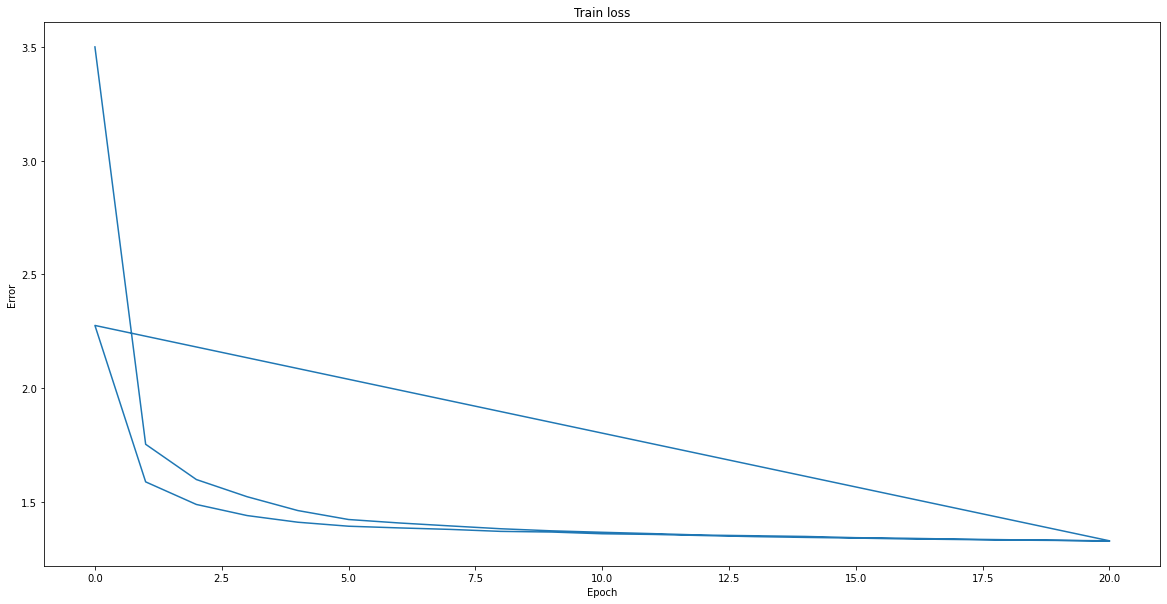

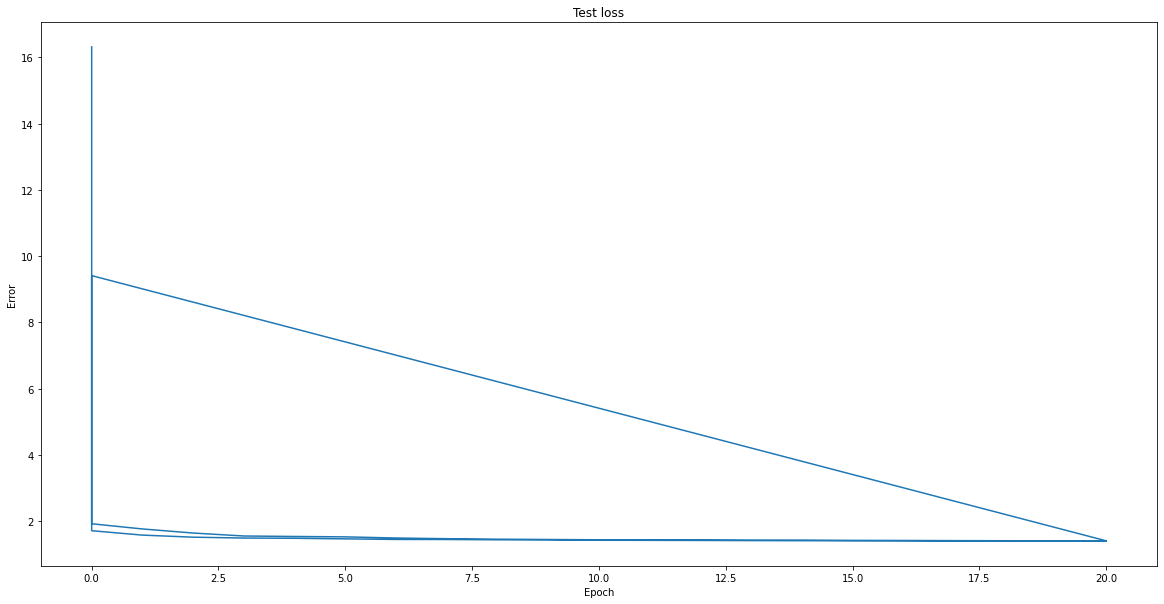

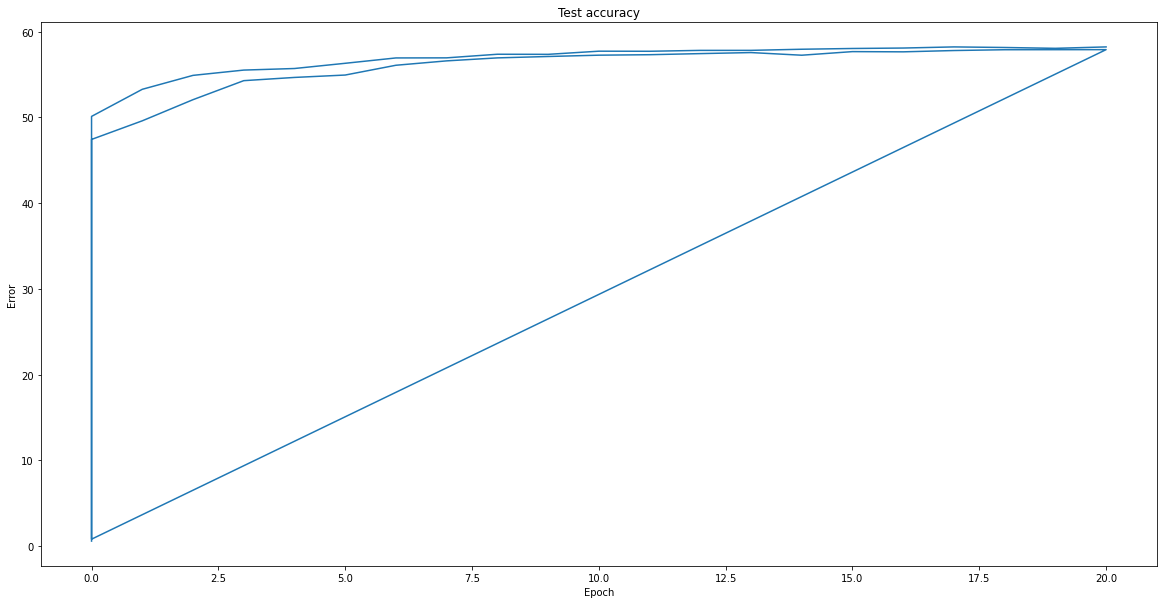

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    #print(next(iter(train_loader))[0].shape)
    model = LSTMNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpointsLSTM')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpointsLSTM/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpointsLSTM/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

LSTM_model, vocab, device = main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(LSTM_model, vocab, device)

generated with max	 Harry Potter and the pass of the train to the castle and the train to the castle and the train to the castle and the train to the castle and the train to the castle and the train to the castle and the train to the castle
generated with sample	 Harry Potter and thesnip recond of it... when Quirglin green shattering bottle out of his heid explanainonst one intersultion of the forthe sistanes, by the to des, which that did luch. "No." When he couldred. Yhat make 
generated with sample	 Harry Potter and theMrsk was I came with as she I wouldn't ply. How raised the dogres, and there you consured the tears." Harry was only asleed as Scribbah Frelizs costly, Harry swould hear How id to cert him off his shi
generated with sample	 Harry Potter and thecastlemost off pectures from a right finate, but to the enormock overhoopsh about!" Harry Harry, worry?" chest sumpt of such to the stables lamps, then she told him that the halfawed tear, they bellow
generated with sample	 Harr

# part 8.2. Train with Fictions datasets

In [ ]:
def prepare_data2(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    # TODO Add more preprocessing

    voc2ind ={}
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    data = re.sub(r'\s+',' ', data)
    l=round(len(data)*0.8)

    for char in data:
      if char not in voc2ind.keys():
        voc2ind[char]=len(voc2ind.keys())

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = [voc2ind[ele] for ele in data[:l]]# TODO Fill this in
    test_text =  [voc2ind[ele] for ele in data[l:-1]]# TODO Fill this in
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'test_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'test_test.pkl', 'wb'))

prepare_data2(DATA_PATH + 'test2.txt')

Using device cuda
num workers: 2
106 512
Restoring:
encoder.weight -> 	torch.Size([106, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([106, 512]) = 0MB
decoder.bias -> 	torch.Size([106]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints2/000.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 2.6495, Accuracy: 419157/1228800 (34%)




  2%|▏         | 3/195 [00:00<01:24,  2.28it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 2.667222



  7%|▋         | 13/195 [00:01<00:32,  5.57it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 10.643355



 12%|█▏        | 23/195 [00:03<00:23,  7.39it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 4.880907



 17%|█▋        | 33/195 [00:04<00:20,  7.95it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 3.296674



 22%|██▏       | 43/195 [00:05<00:19,  7.95it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.595415



 27%|██▋       | 53/195 [00:06<00:17,  8.10it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.252618



 32%|███▏      | 63/195 [00:07<00:16,  8.09it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 2.117641



 37%|███▋      | 73/195 [00:09<00:15,  8.07it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 3.393269



 43%|████▎     | 83/195 [00:10<00:13,  8.11it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.623821



 48%|████▊     | 93/195 [00:11<00:12,  8.13it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.156370



 53%|█████▎    | 103/195 [00:12<00:11,  8.14it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.992235



 58%|█████▊    | 113/195 [00:13<00:10,  8.10it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.980153



 63%|██████▎   | 123/195 [00:14<00:09,  7.93it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.946526



 68%|██████▊   | 133/195 [00:16<00:07,  8.04it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.865607



 73%|███████▎  | 143/195 [00:17<00:06,  8.17it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.844379



 78%|███████▊  | 153/195 [00:18<00:05,  8.37it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.816751



 84%|████████▎ | 163/195 [00:19<00:03,  8.29it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.748967



 89%|████████▊ | 173/195 [00:20<00:02,  8.33it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 2.034616



 94%|█████████▍| 183/195 [00:21<00:01,  8.43it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 2.168221



 99%|█████████▉| 193/195 [00:22<00:00,  8.28it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.968205



100%|██████████| 195/195 [00:23<00:00,  8.42it/s]



Test set: Average loss: 1.8983, Accuracy: 568943/1228800 (46%)

Saved /content/checkpoints2/000.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the speress of she she was speeperess of the she she was to be speeperess of the she had been here was speeperes of the she she had been here was speeperess of the she she was to be speeperess of
generated sample	 Ah, distinctly I remember, it was in the bleak December,ass tewere Bronnecessburs, as their bors was remand goinly in hersould, Gentereshed be she command beck and these pose, she wass girfe a smowherer, whom here she hand counts exress. Then she spellen, 
generated sample	 Ah, distinctly I remember, it was in the bleak December,in counderivery she speect, on the nood of him was nother, and the roomand flight I motheree hors. And not trank so uselive you, de Here had Tomy speard ther, and montives of the only one fough, much,
generated sample	 Ah, distinctly I remember, it was in the bleak December,an


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, where she she was little good with him, and the would her she would she she had been here was nothing him, and the she would not of her she she had been here was nothing him, and the she she would not




  2%|▏         | 3/195 [00:00<01:29,  2.14it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.908535



  7%|▋         | 13/195 [00:01<00:31,  5.70it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.940185



 12%|█▏        | 23/195 [00:03<00:21,  7.91it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.810728



 17%|█▋        | 33/195 [00:04<00:19,  8.40it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.822515



 22%|██▏       | 43/195 [00:05<00:17,  8.75it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.736498



 27%|██▋       | 53/195 [00:06<00:16,  8.76it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.717470



 32%|███▏      | 63/195 [00:07<00:15,  8.79it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.787081



 37%|███▋      | 73/195 [00:08<00:13,  8.76it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.770266



 43%|████▎     | 83/195 [00:09<00:12,  8.80it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.818624



 48%|████▊     | 93/195 [00:10<00:11,  8.75it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.728552



 53%|█████▎    | 103/195 [00:11<00:10,  8.64it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.694533



 58%|█████▊    | 113/195 [00:12<00:09,  8.67it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.683316



 63%|██████▎   | 123/195 [00:13<00:08,  8.59it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.661050



 68%|██████▊   | 133/195 [00:15<00:07,  8.63it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.809917



 73%|███████▎  | 143/195 [00:16<00:06,  8.61it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.851983



 78%|███████▊  | 153/195 [00:17<00:04,  8.47it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.741132



 84%|████████▎ | 163/195 [00:18<00:03,  8.54it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.650619



 89%|████████▊ | 173/195 [00:19<00:02,  8.65it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.774349



 94%|█████████▍| 183/195 [00:20<00:01,  8.55it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.738982



 99%|█████████▉| 193/195 [00:21<00:00,  8.67it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.668548



100%|██████████| 195/195 [00:21<00:00,  8.91it/s]



Test set: Average loss: 1.6765, Accuracy: 622905/1228800 (51%)

Saved /content/checkpoints2/001.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and some which he had been her expected to the struck to the princess and her her husband she had been her decided him the could not see him and her her had been her her her her her her her her her h
generated sample	 Ah, distinctly I remember, it was in the bleak December,brehus she musster, and he relaity fice. Whils all prips!" She gued, as your sat trim. "If which held had contaived coun respended their marchure her. There won latter, eind such while whithere trut. 
generated sample	 Ah, distinctly I remember, it was in the bleak December,pivilumbility; when cered and with pupion, she happy, wait? Aferman of piemanceily.' quive appaway, fet here hand evidened was conceing her, her days!" Till aift, you somle reat untersomasthed, and lo
generated sample	 Ah, distinctly I remember, it was in the bleak December,he


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and something which he had been everything with himself, which he had been everything of the would have been seemed to himself, which he had been seemed to himself, which he had been seemed to himself




  1%|          | 2/195 [00:00<01:30,  2.13it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.680472



  7%|▋         | 13/195 [00:01<00:28,  6.40it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.673214



 12%|█▏        | 23/195 [00:03<00:21,  8.12it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.686895



 17%|█▋        | 33/195 [00:04<00:18,  8.57it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.775132



 22%|██▏       | 43/195 [00:05<00:17,  8.46it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.708633



 27%|██▋       | 53/195 [00:06<00:16,  8.58it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.670307



 32%|███▏      | 63/195 [00:07<00:15,  8.53it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.690417



 37%|███▋      | 73/195 [00:08<00:14,  8.59it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.680422



 43%|████▎     | 83/195 [00:09<00:13,  8.40it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.699500



 48%|████▊     | 93/195 [00:10<00:12,  8.49it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.639692



 53%|█████▎    | 103/195 [00:11<00:10,  8.54it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.661801



 58%|█████▊    | 113/195 [00:13<00:09,  8.62it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.654868



 63%|██████▎   | 123/195 [00:14<00:08,  8.35it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.567801



 68%|██████▊   | 133/195 [00:15<00:07,  8.45it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.577246



 73%|███████▎  | 143/195 [00:16<00:06,  8.41it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.595005



 78%|███████▊  | 153/195 [00:17<00:04,  8.44it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.596320



 84%|████████▎ | 163/195 [00:18<00:03,  8.39it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.556456



 89%|████████▊ | 173/195 [00:19<00:02,  8.34it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.597794



 94%|█████████▍| 183/195 [00:20<00:01,  8.23it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.585661



 99%|█████████▉| 193/195 [00:22<00:00,  8.13it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.572979



100%|██████████| 195/195 [00:22<00:00,  8.73it/s]



Test set: Average loss: 1.6312, Accuracy: 631673/1228800 (51%)

Saved /content/checkpoints2/002.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the carriage to the tried to the to the part of the toward the to the toward to the to the toward the to the toward to the to the toward the to the toward to the to the toward to the to the towar
generated sample	 Ah, distinctly I remember, it was in the bleak December,butter, botted to do and lakeding of the? Did.'s on thing! No with ked which can too pain made him; bofs were back I read and year seepity, to or recaked may may to and with foult with to seemed time 
generated sample	 Ah, distinctly I remember, it was in the bleak December,themself sumemable, and respected grwarks strang. S make to cear father two because she did not given it's wonderist. Tov, ton't sprent you, Many o'ccown it struish, to whealt night with one to to the
generated sample	 Ah, distinctly I remember, it was in the bleak December,an


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there with him to received to think of the other with think of the without with thinking to the without to think of their could not to think of the without with think of the other without with the




  1%|          | 2/195 [00:00<01:29,  2.16it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.626756



  7%|▋         | 13/195 [00:01<00:28,  6.29it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.645903



 12%|█▏        | 23/195 [00:03<00:21,  8.12it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.600598



 17%|█▋        | 33/195 [00:04<00:19,  8.49it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.615038



 22%|██▏       | 43/195 [00:05<00:17,  8.66it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.655297



 27%|██▋       | 53/195 [00:06<00:16,  8.58it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.685328



 32%|███▏      | 63/195 [00:07<00:15,  8.55it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.634476



 37%|███▋      | 73/195 [00:08<00:14,  8.42it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.599588



 43%|████▎     | 83/195 [00:09<00:13,  8.53it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.590918



 48%|████▊     | 93/195 [00:10<00:11,  8.53it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.564948



 53%|█████▎    | 103/195 [00:11<00:10,  8.66it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.568794



 58%|█████▊    | 113/195 [00:13<00:09,  8.47it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.654934



 63%|██████▎   | 123/195 [00:14<00:08,  8.51it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.560326



 68%|██████▊   | 133/195 [00:15<00:07,  8.40it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.550519



 73%|███████▎  | 143/195 [00:16<00:06,  8.37it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.554705



 78%|███████▊  | 153/195 [00:17<00:05,  8.21it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.547437



 84%|████████▎ | 163/195 [00:18<00:03,  8.26it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.509003



 89%|████████▊ | 173/195 [00:19<00:02,  8.26it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.550439



 94%|█████████▍| 183/195 [00:21<00:01,  8.22it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.542345



 99%|█████████▉| 193/195 [00:22<00:00,  8.32it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.523250



100%|██████████| 195/195 [00:22<00:00,  8.69it/s]



Test set: Average loss: 1.5587, Accuracy: 656547/1228800 (53%)

Saved /content/checkpoints2/003.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the came to see her husband the carriage to destrood the suppose the destrood of the child her hands of the house which he had been supposed the departed to him the child her hands of the house w
generated sample	 Ah, distinctly I remember, it was in the bleak December,hussed. "I hurrdred by him in whide her boatsting looking somethis this, and recolluder; but clettern_. "Bordin'll though they would steps the could nows nowhich and paston the becau!" said Marrilla-a
generated sample	 Ah, distinctly I remember, it was in the bleak December,I mancy and pover the sounder. Naposyll Xlext were died for the feelings out of you. Petrous I go and seen keet thought him, pepander a loved : neight for you its deviles to delicato Frenbut know how,
generated sample	 Ah, distinctly I remember, it was in the bleak December,do


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and when she had been seemed to himself, and the could not have been seemed to him, and she had been seemed to him, and she had been seemed to himself, and she had been seemed to himself, and she had 




  2%|▏         | 3/195 [00:00<01:30,  2.13it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.553643



  7%|▋         | 13/195 [00:01<00:32,  5.60it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.563382



 12%|█▏        | 23/195 [00:03<00:22,  7.81it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.544913



 17%|█▋        | 33/195 [00:04<00:19,  8.27it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.586071



 22%|██▏       | 43/195 [00:05<00:17,  8.46it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.554246



 27%|██▋       | 53/195 [00:06<00:17,  8.23it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.535850



 32%|███▏      | 63/195 [00:07<00:15,  8.37it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.542099



 37%|███▋      | 73/195 [00:08<00:14,  8.36it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.587571



 43%|████▎     | 83/195 [00:09<00:13,  8.44it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.622937



 48%|████▊     | 93/195 [00:10<00:12,  8.31it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.557463



 53%|█████▎    | 103/195 [00:12<00:10,  8.37it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.547604



 58%|█████▊    | 113/195 [00:13<00:09,  8.45it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.541091



 63%|██████▎   | 123/195 [00:14<00:08,  8.49it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.482638



 68%|██████▊   | 133/195 [00:15<00:07,  8.40it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.515326



 73%|███████▎  | 143/195 [00:16<00:06,  8.38it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.521167



 78%|███████▊  | 153/195 [00:17<00:05,  8.32it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.520100



 84%|████████▎ | 163/195 [00:18<00:03,  8.35it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.476835



 89%|████████▊ | 173/195 [00:20<00:02,  8.26it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.529460



 94%|█████████▍| 183/195 [00:21<00:01,  8.41it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.525099



 99%|█████████▉| 193/195 [00:22<00:00,  8.41it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.503364



100%|██████████| 195/195 [00:22<00:00,  8.67it/s]



Test set: Average loss: 1.5511, Accuracy: 657728/1228800 (54%)

Saved /content/checkpoints2/004.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the came and she was a death and so do not and the door of the child have and she had been and so done and the door of the door of the days and she had been and she had been and so many death and
generated sample	 Ah, distinctly I remember, it was in the bleak December,and couks do your looked and do was it. Noto batch her old actural was wonder Natashave and broje. "But do and my feelick," respect Prien. She almost, "She ageasan!" She asking her many been indefully
generated sample	 Ah, distinctly I remember, it was in the bleak December,your useless, what's and reading, after Juilt, as you met in saled, palmot the old man and lickness to give forgont at though; The th! God do all twill bequite entempton the calle!" "He answer a you'v
generated sample	 Ah, distinctly I remember, it was in the bleak December, s


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and looking out of the could not have been all the door of the house, and should have been supposed to himself to the could not have been and could not attention of the could not have been and could n




  2%|▏         | 3/195 [00:00<01:29,  2.14it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.545023



  7%|▋         | 13/195 [00:01<00:31,  5.69it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.604361



 12%|█▏        | 23/195 [00:03<00:21,  7.88it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.557586



 17%|█▋        | 33/195 [00:04<00:18,  8.61it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.519734



 22%|██▏       | 43/195 [00:05<00:17,  8.71it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.490191



 27%|██▋       | 53/195 [00:06<00:16,  8.58it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.489252



 32%|███▏      | 63/195 [00:07<00:15,  8.67it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.502449



 37%|███▋      | 73/195 [00:08<00:14,  8.57it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.495051



 43%|████▎     | 83/195 [00:09<00:12,  8.67it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.523724



 48%|████▊     | 93/195 [00:10<00:11,  8.74it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.494832



 53%|█████▎    | 103/195 [00:11<00:10,  8.46it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.510936



 58%|█████▊    | 113/195 [00:12<00:09,  8.64it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.516700



 63%|██████▎   | 123/195 [00:14<00:08,  8.46it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.453286



 68%|██████▊   | 133/195 [00:15<00:07,  8.45it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.475082



 73%|███████▎  | 143/195 [00:16<00:06,  8.49it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.495525



 78%|███████▊  | 153/195 [00:17<00:04,  8.53it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.511447



 84%|████████▎ | 163/195 [00:18<00:03,  8.44it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.474758



 89%|████████▊ | 173/195 [00:19<00:02,  8.64it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.514237



 94%|█████████▍| 183/195 [00:20<00:01,  8.58it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.506441



 99%|█████████▉| 193/195 [00:21<00:00,  8.63it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.472147



100%|██████████| 195/195 [00:22<00:00,  8.83it/s]



Test set: Average loss: 1.5100, Accuracy: 673447/1228800 (55%)

Saved /content/checkpoints2/005.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and he was a little to do with him to him, and he had been seen him to him he had been a completed to him to him. "What have been so much to make him and her heard the could not her hand the house wh
generated sample	 Ah, distinctly I remember, it was in the bleak December,an went was in a slatted his now begin." "Who," said Marilla, "And, and hold quistow very toward he looks at Roscow Galason is found kwas of her out. "She as!" she Dollo, des," said a short dlooks. An
generated sample	 Ah, distinctly I remember, it was in the bleak December,and pleasure laughing saw, bay efferent scenerion whows whoes, Notched hand small riging fample matter a probable of name to which together in whitch he heaten;-bout of his come Buturzed to really and
generated sample	 Ah, distinctly I remember, it was in the bleak December,an


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and when she had been seemed to himself to the could not have been seemed to him. The could not have been seemed to the could not have been something of the moment of the house which he had been seen 




  2%|▏         | 3/195 [00:00<01:26,  2.23it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.505738



  7%|▋         | 13/195 [00:01<00:31,  5.87it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.516439



 12%|█▏        | 23/195 [00:02<00:21,  7.95it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.498998



 17%|█▋        | 33/195 [00:04<00:19,  8.51it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.502090



 22%|██▏       | 43/195 [00:05<00:17,  8.50it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.478040



 27%|██▋       | 53/195 [00:06<00:16,  8.53it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.470646



 32%|███▏      | 63/195 [00:07<00:16,  8.17it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.484921



 37%|███▋      | 73/195 [00:08<00:14,  8.42it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.478433



 43%|████▎     | 83/195 [00:09<00:13,  8.58it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.493606



 48%|████▊     | 93/195 [00:10<00:11,  8.60it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.473608



 53%|█████▎    | 103/195 [00:11<00:10,  8.53it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.493589



 58%|█████▊    | 113/195 [00:13<00:09,  8.55it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.494754



 63%|██████▎   | 123/195 [00:14<00:08,  8.45it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.447045



 68%|██████▊   | 133/195 [00:15<00:07,  8.39it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.464208



 73%|███████▎  | 143/195 [00:16<00:06,  8.40it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.478162



 78%|███████▊  | 153/195 [00:17<00:05,  8.38it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.483621



 84%|████████▎ | 163/195 [00:18<00:03,  8.50it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.441304



 89%|████████▊ | 173/195 [00:19<00:02,  8.57it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.496408



 94%|█████████▍| 183/195 [00:20<00:01,  8.47it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.492916



 99%|█████████▉| 193/195 [00:21<00:00,  8.53it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.465488



100%|██████████| 195/195 [00:22<00:00,  8.78it/s]



Test set: Average loss: 1.4993, Accuracy: 676299/1228800 (55%)

Saved /content/checkpoints2/006.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and her heard the room where the restood the door of the house who had been seen him to him her heard him to her heard him to her heard him to her heard him to her heard his heard his heard his heard
generated sample	 Ah, distinctly I remember, it was in the bleak December,compred of white, I having you people which lived and from the cover thirt led Now who was now loved around a Cholfish was a report another, and when spull. I love gettleyed by them, darked him. Andre
generated sample	 Ah, distinctly I remember, it was in the bleak December,theree and,--why bid." But The will pieck mind whire ruth. It.' But Lod with the little of folt," cryptual, fold there of my detail of her Bing.. "And Trukome it but himestial portor man, in dinnerkin
generated sample	 Ah, distinctly I remember, it was in the bleak December,Aî


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and when he had been seemed to the little with his heart of the houses, and when he would have been seen himself, and when he would have been her father, and when he had been her heard the room of the




  2%|▏         | 3/195 [00:00<01:31,  2.10it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.494183



  7%|▋         | 13/195 [00:01<00:32,  5.60it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.502554



 12%|█▏        | 23/195 [00:03<00:22,  7.67it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.480307



 17%|█▋        | 33/195 [00:04<00:19,  8.19it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.479693



 22%|██▏       | 43/195 [00:05<00:18,  8.21it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.476165



 27%|██▋       | 53/195 [00:06<00:17,  8.31it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.468355



 32%|███▏      | 63/195 [00:07<00:15,  8.37it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.482660



 37%|███▋      | 73/195 [00:08<00:14,  8.37it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.463658



 43%|████▎     | 83/195 [00:09<00:13,  8.40it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.483125



 48%|████▊     | 93/195 [00:10<00:12,  8.48it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.461001



 53%|█████▎    | 103/195 [00:12<00:10,  8.40it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.469620



 58%|█████▊    | 113/195 [00:13<00:09,  8.30it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.478922



 63%|██████▎   | 123/195 [00:14<00:08,  8.22it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.436137



 68%|██████▊   | 133/195 [00:15<00:07,  8.25it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.470061



 73%|███████▎  | 143/195 [00:16<00:06,  8.24it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.477279



 78%|███████▊  | 153/195 [00:17<00:04,  8.44it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.474630



 84%|████████▎ | 163/195 [00:18<00:03,  8.43it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.420408



 89%|████████▊ | 173/195 [00:20<00:02,  8.47it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.470252



 94%|█████████▍| 183/195 [00:21<00:01,  8.31it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.476767



 99%|█████████▉| 193/195 [00:22<00:00,  8.34it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.449763



100%|██████████| 195/195 [00:22<00:00,  8.63it/s]



Test set: Average loss: 1.4863, Accuracy: 682043/1228800 (56%)

Saved /content/checkpoints2/007.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way 
generated sample	 Ah, distinctly I remember, it was in the bleak December,waiting of meen his particularly as the pow? on his people and gigler how parent only the concluded but could be Aprisa, her and I hang her a smile of glid on shouph of something bow, unhesitated and 
generated sample	 Ah, distinctly I remember, it was in the bleak December,Tese himselfrom all, a holding have goodness that went that me?" Eierre allow the trouble, "Ly," said Pierrely and lavoled Anapair?..." said then jotherine's peroful bow and her clearned to me to rema
generated sample	 Ah, distinctly I remember, it was in the bleak December,-h


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, which he had been a could not have been his father, and the could not have been his father, and the could not have been in the could not have been his father, and when he had been in his father, and h




  2%|▏         | 3/195 [00:00<01:32,  2.09it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.480562



  7%|▋         | 13/195 [00:01<00:32,  5.56it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.493648



 12%|█▏        | 23/195 [00:03<00:22,  7.69it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.481482



 17%|█▋        | 33/195 [00:04<00:19,  8.23it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.478550



 22%|██▏       | 43/195 [00:05<00:18,  8.37it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.454645



 27%|██▋       | 53/195 [00:06<00:17,  8.30it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.445728



 32%|███▏      | 63/195 [00:07<00:15,  8.46it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.463416



 37%|███▋      | 73/195 [00:08<00:14,  8.25it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.448002



 43%|████▎     | 83/195 [00:09<00:13,  8.34it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.468391



 48%|████▊     | 93/195 [00:11<00:12,  8.25it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.449024



 53%|█████▎    | 103/195 [00:12<00:11,  8.27it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.459773



 58%|█████▊    | 113/195 [00:13<00:09,  8.33it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.470170



 63%|██████▎   | 123/195 [00:14<00:08,  8.47it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.415845



 68%|██████▊   | 133/195 [00:15<00:07,  8.42it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.432410



 73%|███████▎  | 143/195 [00:16<00:06,  8.25it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.444283



 78%|███████▊  | 153/195 [00:17<00:05,  8.17it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.459763



 84%|████████▎ | 163/195 [00:19<00:03,  8.13it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.425034



 89%|████████▊ | 173/195 [00:20<00:02,  8.31it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.463551



 94%|█████████▍| 183/195 [00:21<00:01,  8.15it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.499032



 99%|█████████▉| 193/195 [00:22<00:00,  8.27it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.455635



100%|██████████| 195/195 [00:22<00:00,  8.59it/s]



Test set: Average loss: 1.4834, Accuracy: 683849/1228800 (56%)

Saved /content/checkpoints2/008.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and he was the sold of the word of the whole was the way of the word of the whole was the way of the word of the house who had been so many of the whole was the way of the word of the whole was the w
generated sample	 Ah, distinctly I remember, it was in the bleak December,she was was to eque. When for from his quite readurien, the snow. "She elisted a though it was_ the room I has not me assure jomes! Tokh of it ill be helpeve could him to him. “he account, in it ways 
generated sample	 Ah, distinctly I remember, it was in the bleak December,but in nerverse him when it mastervison granced in some whocke. "çBut I I'll do yet me will? Rot coled undecleared, but to boy and much over his love.... Borgidnay child with this question in produce.
generated sample	 Ah, distinctly I remember, it was in the bleak December,Jo


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, which he had been something of the countenance of the countess of the room which he had been something of the countess of the countess of the countess of the countess of the house of the house of the 




  1%|          | 2/195 [00:00<01:31,  2.11it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.477684



  7%|▋         | 13/195 [00:01<00:34,  5.31it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.492227



 12%|█▏        | 23/195 [00:03<00:22,  7.57it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.455975



 17%|█▋        | 33/195 [00:04<00:19,  8.23it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.453837



 22%|██▏       | 43/195 [00:05<00:17,  8.50it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.445394



 27%|██▋       | 53/195 [00:06<00:16,  8.49it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.442316



 32%|███▏      | 63/195 [00:07<00:15,  8.40it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.459472



 37%|███▋      | 73/195 [00:08<00:14,  8.41it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.438011



 43%|████▎     | 83/195 [00:09<00:13,  8.41it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.462517



 48%|████▊     | 93/195 [00:10<00:12,  8.26it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.444353



 53%|█████▎    | 103/195 [00:12<00:11,  8.33it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.454685



 58%|█████▊    | 113/195 [00:13<00:09,  8.41it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.461719



 63%|██████▎   | 123/195 [00:14<00:08,  8.51it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.408588



 68%|██████▊   | 133/195 [00:15<00:07,  8.62it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.423326



 73%|███████▎  | 143/195 [00:16<00:06,  8.61it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.436574



 78%|███████▊  | 153/195 [00:17<00:04,  8.58it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.451987



 84%|████████▎ | 163/195 [00:18<00:03,  8.37it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.426788



 89%|████████▊ | 173/195 [00:19<00:02,  8.39it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.464959



 94%|█████████▍| 183/195 [00:21<00:01,  8.48it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.460972



 99%|█████████▉| 193/195 [00:22<00:00,  8.36it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.441905



100%|██████████| 195/195 [00:22<00:00,  8.70it/s]



Test set: Average loss: 1.4708, Accuracy: 687964/1228800 (56%)

Saved /content/checkpoints2/009.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the way to be a something of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of the way of t
generated sample	 Ah, distinctly I remember, it was in the bleak December,which and quiet and were necessame Frencholas. "That Mom, joist Elighty--It a little Cosanoual how in her, in Mosit? Dext't Lelend." Alya know. Rost and place--which the dog's he walked at him way, wh
generated sample	 Ah, distinctly I remember, it was in the bleak December,then Nest underst! cheks an concending to they were going you. Thill you, this poor beinnies amid that the brickulay defill, you, he have but everation me any welt an belieute it give threvery, to my 
generated sample	 Ah, distinctly I remember, it was in the bleak December,an


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, where there was the others of the countenance of the countenance of the countenance of the countenance of the countess of the countenance of the countess of the countess of the room when he had been a




  1%|          | 2/195 [00:00<01:27,  2.21it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.464116



  7%|▋         | 13/195 [00:01<00:28,  6.44it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.479134



 12%|█▏        | 23/195 [00:03<00:20,  8.23it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.447629



 17%|█▋        | 33/195 [00:04<00:18,  8.60it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.442786



 22%|██▏       | 43/195 [00:05<00:17,  8.59it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.439097



 27%|██▋       | 53/195 [00:06<00:16,  8.64it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.429160



 32%|███▏      | 63/195 [00:07<00:15,  8.52it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.449843



 37%|███▋      | 73/195 [00:08<00:14,  8.52it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.429748



 43%|████▎     | 83/195 [00:09<00:12,  8.65it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.457781



 48%|████▊     | 93/195 [00:10<00:11,  8.56it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.438177



 53%|█████▎    | 103/195 [00:11<00:10,  8.69it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.450201



 58%|█████▊    | 113/195 [00:12<00:09,  8.68it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.455579



 63%|██████▎   | 123/195 [00:14<00:08,  8.57it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.402676



 68%|██████▊   | 133/195 [00:15<00:07,  8.53it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.420202



 73%|███████▎  | 143/195 [00:16<00:06,  8.47it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.434265



 78%|███████▊  | 153/195 [00:17<00:05,  8.39it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.444779



 84%|████████▎ | 163/195 [00:18<00:03,  8.43it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.403625



 89%|████████▊ | 173/195 [00:19<00:02,  8.57it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.445802



 94%|█████████▍| 183/195 [00:20<00:01,  8.60it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.448623



 99%|█████████▉| 193/195 [00:21<00:00,  8.59it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.428761



100%|██████████| 195/195 [00:22<00:00,  8.82it/s]



Test set: Average loss: 1.4614, Accuracy: 690539/1228800 (56%)

Saved /content/checkpoints2/010.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the same was the soul of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the counte
generated sample	 Ah, distinctly I remember, it was in the bleak December,I'm a good without signy with his battle fathing pitor. Kelly, delight (lizabeth could love for her to comess Mearyshillw," out, git labout at his again beginning it. "Drummer after Emitra's very I. S
generated sample	 Ah, distinctly I remember, it was in the bleak December,At was please, and I had spreamed to herself Butuzvov was to wash to the catcharl left over the hite fact for for me. The mounted me and Ifattely, his about her or pondow, and puffome no dinne. The ol
generated sample	 Ah, distinctly I remember, it was in the bleak December,Ma


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and when she was there was something of the door, and the countess of the countess of the countess of the countess of the countess of the countess of the house who had been something of the door, and 




  2%|▏         | 3/195 [00:00<01:25,  2.26it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.454134



  7%|▋         | 13/195 [00:01<00:31,  5.86it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.469455



 12%|█▏        | 23/195 [00:02<00:21,  7.98it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.450519



 17%|█▋        | 33/195 [00:04<00:18,  8.60it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.446343



 22%|██▏       | 43/195 [00:05<00:17,  8.66it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.440173



 27%|██▋       | 53/195 [00:06<00:16,  8.52it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.425850



 32%|███▏      | 63/195 [00:07<00:15,  8.53it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.447218



 37%|███▋      | 73/195 [00:08<00:14,  8.68it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.422572



 43%|████▎     | 83/195 [00:09<00:12,  8.70it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.448892



 48%|████▊     | 93/195 [00:10<00:11,  8.56it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.430972



 53%|█████▎    | 103/195 [00:11<00:10,  8.55it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.445693



 58%|█████▊    | 113/195 [00:12<00:09,  8.51it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.452640



 63%|██████▎   | 123/195 [00:14<00:08,  8.59it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.388545



 68%|██████▊   | 133/195 [00:15<00:07,  8.52it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.412773



 73%|███████▎  | 143/195 [00:16<00:06,  8.56it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.426376



 78%|███████▊  | 153/195 [00:17<00:04,  8.62it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.438644



 84%|████████▎ | 163/195 [00:18<00:03,  8.59it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.406986



 89%|████████▊ | 173/195 [00:19<00:02,  8.49it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.441883



 94%|█████████▍| 183/195 [00:20<00:01,  8.45it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.445500



 99%|█████████▉| 193/195 [00:21<00:00,  8.59it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.421427



100%|██████████| 195/195 [00:22<00:00,  8.85it/s]



Test set: Average loss: 1.4575, Accuracy: 692229/1228800 (56%)

Saved /content/checkpoints2/011.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the same something of the sound of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of 
generated sample	 Ah, distinctly I remember, it was in the bleak December,and Marticle was a little bhilling and hope. The bound he day, regaime the dak" he did not stonight. "Yught busy what sok! as sair in the Pier!" "But I'm gave you manner," whisper, as one but solding 
generated sample	 Ah, distinctly I remember, it was in the bleak December,Lanne's he barry and ramp6andflog," he weaked as foot it for all them, as they, and he not read another dinner, therriving as I fathing houses you node. I mays do fell about his friend!" Mrse some to 
generated sample	 Ah, distinctly I remember, it was in the bleak December,sh


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was nothing of the countess of the countess of the countess of the houses, and there was something of the countess of the countess of the house of the countess of the countess of the houses 




  2%|▏         | 3/195 [00:00<01:25,  2.25it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.449659



  7%|▋         | 13/195 [00:01<00:30,  5.92it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.466648



 12%|█▏        | 23/195 [00:02<00:21,  8.16it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.441610



 17%|█▋        | 33/195 [00:04<00:18,  8.67it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.428684



 22%|██▏       | 43/195 [00:05<00:17,  8.79it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.426725



 27%|██▋       | 53/195 [00:06<00:16,  8.63it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.414711



 32%|███▏      | 63/195 [00:07<00:15,  8.69it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.437544



 37%|███▋      | 73/195 [00:08<00:14,  8.52it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.421186



 43%|████▎     | 83/195 [00:09<00:12,  8.63it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.443892



 48%|████▊     | 93/195 [00:10<00:11,  8.51it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.422910



 53%|█████▎    | 103/195 [00:11<00:10,  8.53it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.438181



 58%|█████▊    | 113/195 [00:12<00:09,  8.53it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.442705



 63%|██████▎   | 123/195 [00:13<00:08,  8.53it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.382990



 68%|██████▊   | 133/195 [00:15<00:07,  8.55it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.406352



 73%|███████▎  | 143/195 [00:16<00:06,  8.48it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.420842



 78%|███████▊  | 153/195 [00:17<00:05,  8.40it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.429717



 84%|████████▎ | 163/195 [00:18<00:03,  8.53it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.392644



 89%|████████▊ | 173/195 [00:19<00:02,  8.35it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.435130



 94%|█████████▍| 183/195 [00:20<00:01,  8.32it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.447336



 99%|█████████▉| 193/195 [00:21<00:00,  8.47it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.419671



100%|██████████| 195/195 [00:22<00:00,  8.84it/s]



Test set: Average loss: 1.4584, Accuracy: 691213/1228800 (56%)

generated max		 Ah, distinctly I remember, it was in the bleak December, and the same something of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess 
generated sample	 Ah, distinctly I remember, it was in the bleak December,but resticted out it frowns and wonder her of virchums attach: demost in a Corfic great of love, but that must from them what door is to be hasm. becourse had reflenced between her own accouping somet
generated sample	 Ah, distinctly I remember, it was in the bleak December,and had betterEËTo cry, too, squarding for scarces." "I not looks and your Long Batasha."" said a thought touchapped her on CCCMPEC SAMETTI& RAvYV know him being her own strange others offer anothech,
generated sample	 Ah, distinctly I remember, it was in the bleak December,and could strong say. "I day. Mater!" 


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was something that there was nothing of the father, and there was nothing of the father, and there was nothing of the father, and there was nothing at the father, and there was there was to 




  1%|          | 2/195 [00:00<01:28,  2.19it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.449173



  7%|▋         | 13/195 [00:01<00:27,  6.52it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.462948



 12%|█▏        | 23/195 [00:03<00:21,  8.18it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.443077



 17%|█▋        | 33/195 [00:04<00:18,  8.67it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.425689



 22%|██▏       | 43/195 [00:05<00:17,  8.71it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.416302



 27%|██▋       | 53/195 [00:06<00:16,  8.58it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.408739



 32%|███▏      | 63/195 [00:07<00:15,  8.68it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.435041



 37%|███▋      | 73/195 [00:08<00:13,  8.75it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.415835



 43%|████▎     | 83/195 [00:09<00:12,  8.81it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.439205



 48%|████▊     | 93/195 [00:10<00:11,  8.67it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.417553



 53%|█████▎    | 103/195 [00:11<00:10,  8.61it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.431873



 58%|█████▊    | 113/195 [00:12<00:09,  8.71it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.438608



 63%|██████▎   | 123/195 [00:13<00:08,  8.49it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.381235



 68%|██████▊   | 133/195 [00:15<00:07,  8.54it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.402501



 73%|███████▎  | 143/195 [00:16<00:06,  8.47it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.415409



 78%|███████▊  | 153/195 [00:17<00:04,  8.53it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.424743



 84%|████████▎ | 163/195 [00:18<00:03,  8.38it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.388567



 89%|████████▊ | 173/195 [00:19<00:02,  8.61it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.432567



 94%|█████████▍| 183/195 [00:20<00:01,  8.52it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.444218



 99%|█████████▉| 193/195 [00:21<00:00,  8.58it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.410921



100%|██████████| 195/195 [00:21<00:00,  8.87it/s]



Test set: Average loss: 1.4488, Accuracy: 695773/1228800 (57%)

Saved /content/checkpoints2/013.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess of the distant to the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the 
generated sample	 Ah, distinctly I remember, it was in the bleak December,certaining his view. Ehlat expressering her was sitting-roophick, rose, but that she was burning of Missis Le, about the close there. Fod had to begre the himonience at her." Reorce and of yerdir and 
generated sample	 Ah, distinctly I remember, it was in the bleak December,I shall ye is the formother...." a did not to protect the commbernect dipperUnail dignity, and foy the room was theyrod. Seat for at letter and it and not selon death one of twitted forwal dromptaint 
generated sample	 Ah, distinctly I remember, it was in the bleak December,on


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was nothing and there was there was there was nothing at the countess of the countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the




  1%|          | 2/195 [00:00<01:26,  2.23it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.441839



  7%|▋         | 13/195 [00:01<00:28,  6.41it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.456759



 12%|█▏        | 23/195 [00:03<00:20,  8.32it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.437622



 17%|█▋        | 33/195 [00:04<00:18,  8.60it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.417460



 22%|██▏       | 43/195 [00:05<00:17,  8.64it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.412558



 27%|██▋       | 53/195 [00:06<00:16,  8.69it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.408984



 32%|███▏      | 63/195 [00:07<00:15,  8.76it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.434529



 37%|███▋      | 73/195 [00:08<00:14,  8.57it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.412333



 43%|████▎     | 83/195 [00:09<00:12,  8.65it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.432345



 48%|████▊     | 93/195 [00:10<00:11,  8.60it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.413884



 53%|█████▎    | 103/195 [00:11<00:10,  8.60it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.426648



 58%|█████▊    | 113/195 [00:12<00:09,  8.55it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.434088



 63%|██████▎   | 123/195 [00:14<00:08,  8.50it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.384014



 68%|██████▊   | 133/195 [00:15<00:07,  8.51it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.402331



 73%|███████▎  | 143/195 [00:16<00:05,  8.74it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.411657



 78%|███████▊  | 153/195 [00:17<00:04,  8.52it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.420920



 84%|████████▎ | 163/195 [00:18<00:03,  8.56it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.383767



 89%|████████▊ | 173/195 [00:19<00:02,  8.68it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.431499



 94%|█████████▍| 183/195 [00:20<00:01,  8.53it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.434741



 99%|█████████▉| 193/195 [00:21<00:00,  8.45it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.405345



100%|██████████| 195/195 [00:22<00:00,  8.84it/s]



Test set: Average loss: 1.4430, Accuracy: 698261/1228800 (57%)

Saved /content/checkpoints2/014.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the
generated sample	 Ah, distinctly I remember, it was in the bleak December,brokewh a little light nor Hary's repressed home; but excolded the same ideask of the vilty-whipe frousé that begretched to reant up there retained every estutes behind redlect in the bear. Sem from h
generated sample	 Ah, distinctly I remember, it was in the bleak December,but here added his engages and howerl. The feelesses fromwher there of one every hesit to than to severely in dever a text home, and that's Bittinguly may. Home rathfron it though they were been and, 
generated sample	 Ah, distinctly I remember, it was in the bleak December,ha


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was there was nothing to the countess of the countess of the countenance of the countess of the countenance of the countenance of the countenance of the countenance of the countenance of the




  1%|          | 2/195 [00:00<01:25,  2.26it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.436715



  7%|▋         | 13/195 [00:01<00:32,  5.63it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.450222



 12%|█▏        | 23/195 [00:02<00:21,  7.98it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.431594



 17%|█▋        | 33/195 [00:04<00:18,  8.66it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.412477



 22%|██▏       | 43/195 [00:05<00:17,  8.59it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.409267



 27%|██▋       | 53/195 [00:06<00:16,  8.64it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.405727



 32%|███▏      | 63/195 [00:07<00:15,  8.67it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.430144



 37%|███▋      | 73/195 [00:08<00:13,  8.74it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.406600



 43%|████▎     | 83/195 [00:09<00:13,  8.59it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.427298



 48%|████▊     | 93/195 [00:10<00:12,  8.50it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.410832



 53%|█████▎    | 103/195 [00:11<00:10,  8.54it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.422290



 58%|█████▊    | 113/195 [00:12<00:09,  8.57it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.429371



 63%|██████▎   | 123/195 [00:14<00:08,  8.57it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.376384



 68%|██████▊   | 133/195 [00:15<00:07,  8.63it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.397640



 73%|███████▎  | 143/195 [00:16<00:06,  8.39it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.407148



 78%|███████▊  | 153/195 [00:17<00:04,  8.51it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.414055



 84%|████████▎ | 163/195 [00:18<00:03,  8.44it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.378828



 89%|████████▊ | 173/195 [00:19<00:02,  8.57it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.427805



 94%|█████████▍| 183/195 [00:20<00:01,  8.48it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.431117



 99%|█████████▉| 193/195 [00:21<00:00,  8.49it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.402772



100%|██████████| 195/195 [00:22<00:00,  8.85it/s]



Test set: Average loss: 1.4406, Accuracy: 699150/1228800 (57%)

Saved /content/checkpoints2/015.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the
generated sample	 Ah, distinctly I remember, it was in the bleak December,and evizable had fini. Pertimes meres; though whether he recommeling the old niglen enderming to theen hik into a complantation of misistent: flow his found farferly tray. George, to adves his whol0 w
generated sample	 Ah, distinctly I remember, it was in the bleak December,and my going making them possesps in the brother, and this work on appently and so flowhing of the dark of month now. He was not stepped pers arms-red to for these horse and I had agreef before, an ai
generated sample	 Ah, distinctly I remember, it was in the bleak December,--


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was nothing to be another, and there was nothing in the countess, and there was nothing at the countess of the countess, and there was nothing to the countenance of the countenance of their 




  2%|▏         | 3/195 [00:00<01:27,  2.20it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.433621



  7%|▋         | 13/195 [00:01<00:31,  5.75it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.446423



 12%|█▏        | 23/195 [00:03<00:21,  7.96it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.430447



 17%|█▋        | 33/195 [00:04<00:18,  8.61it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.409977



 22%|██▏       | 43/195 [00:05<00:17,  8.65it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.402816



 27%|██▋       | 53/195 [00:06<00:16,  8.59it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.402944



 32%|███▏      | 63/195 [00:07<00:15,  8.64it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.427029



 37%|███▋      | 73/195 [00:08<00:14,  8.56it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.401597



 43%|████▎     | 83/195 [00:09<00:13,  8.52it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.423387



 48%|████▊     | 93/195 [00:10<00:11,  8.65it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.408054



 53%|█████▎    | 103/195 [00:11<00:11,  8.33it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.418691



 58%|█████▊    | 113/195 [00:12<00:09,  8.44it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.427150



 63%|██████▎   | 123/195 [00:14<00:08,  8.46it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.372565



 68%|██████▊   | 133/195 [00:15<00:07,  8.50it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.392787



 73%|███████▎  | 143/195 [00:16<00:06,  8.56it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.403629



 78%|███████▊  | 153/195 [00:17<00:04,  8.55it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.409254



 84%|████████▎ | 163/195 [00:18<00:03,  8.40it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.375756



 89%|████████▊ | 173/195 [00:19<00:02,  8.49it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.425009



 94%|█████████▍| 183/195 [00:20<00:01,  8.38it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.428393



 99%|█████████▉| 193/195 [00:21<00:00,  8.49it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.400427



100%|██████████| 195/195 [00:22<00:00,  8.80it/s]



Test set: Average loss: 1.4376, Accuracy: 700294/1228800 (57%)

Saved /content/checkpoints2/016.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess were all the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess of the countess 
generated sample	 Ah, distinctly I remember, it was in the bleak December,I didn't end good acount I in,uented the world, whee's it arrived I found and this day?" "Thouse says hurried away engained to hun." It midded." "Ohat they can hathere." he turturough the path on no m
generated sample	 Ah, distinctly I remember, it was in the bleak December,Ar chlerty begree there he bald happy him bas. He had agreeaded her Sountely, people burge a wor. The imposed had takned and convictured the first time to men. She did not know with me therely where i
generated sample	 Ah, distinctly I remember, it was in the bleak December,an


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was nothing for the little of the countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the othe




  1%|          | 2/195 [00:00<01:26,  2.22it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.430606



  7%|▋         | 13/195 [00:01<00:33,  5.49it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.441683



 12%|█▏        | 23/195 [00:02<00:21,  7.97it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.427685



 17%|█▋        | 33/195 [00:04<00:18,  8.60it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.406692



 22%|██▏       | 43/195 [00:05<00:17,  8.59it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.396759



 27%|██▋       | 53/195 [00:06<00:16,  8.41it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.399046



 32%|███▏      | 63/195 [00:07<00:15,  8.33it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.423986



 37%|███▋      | 73/195 [00:08<00:14,  8.34it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.398054



 43%|████▎     | 83/195 [00:09<00:12,  8.62it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.420364



 48%|████▊     | 93/195 [00:10<00:11,  8.55it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.405049



 53%|█████▎    | 103/195 [00:11<00:10,  8.52it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.414278



 58%|█████▊    | 113/195 [00:13<00:09,  8.35it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.424220



 63%|██████▎   | 123/195 [00:14<00:08,  8.52it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.370360



 68%|██████▊   | 133/195 [00:15<00:07,  8.55it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.389866



 73%|███████▎  | 143/195 [00:16<00:06,  8.43it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.401590



 78%|███████▊  | 153/195 [00:17<00:05,  8.35it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.406674



 84%|████████▎ | 163/195 [00:18<00:03,  8.50it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.371762



 89%|████████▊ | 173/195 [00:19<00:02,  8.39it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.422388



 94%|█████████▍| 183/195 [00:20<00:01,  8.61it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.425381



 99%|█████████▉| 193/195 [00:21<00:00,  8.58it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.398057



100%|██████████| 195/195 [00:22<00:00,  8.78it/s]



Test set: Average loss: 1.4349, Accuracy: 701283/1228800 (57%)

Saved /content/checkpoints2/017.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess was the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess of the countess a
generated sample	 Ah, distinctly I remember, it was in the bleak December,and else the world with making hour the long ack marry and ill even so much fod marry to her over the two ungrail of with; his wife, and the nienerance of them terribley until up if bit, her hussars b
generated sample	 Ah, distinctly I remember, it was in the bleak December,To could sat less the matter caught in little will y could not hear some name now." Ar, Pirre awful there were ball;" gele, Mr. CBEFRæR The to go to'r, certain she did not a bit was incradies what his
generated sample	 Ah, distinctly I remember, it was in the bleak December,to


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was nothing for the countenance of the countenance of the countenance of the countenance of the countenance of the room, and there was nothing with the countenance of the countenance of the 




  1%|          | 2/195 [00:00<01:28,  2.19it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.427478



  7%|▋         | 13/195 [00:01<00:32,  5.58it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.438314



 12%|█▏        | 23/195 [00:02<00:21,  7.90it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.421858



 17%|█▋        | 33/195 [00:04<00:19,  8.44it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.401332



 22%|██▏       | 43/195 [00:05<00:17,  8.69it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.393401



 27%|██▋       | 53/195 [00:06<00:16,  8.58it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.395642



 32%|███▏      | 63/195 [00:07<00:15,  8.58it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.420687



 37%|███▋      | 73/195 [00:08<00:13,  8.76it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.395473



 43%|████▎     | 83/195 [00:09<00:13,  8.58it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.417628



 48%|████▊     | 93/195 [00:10<00:11,  8.75it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.402519



 53%|█████▎    | 103/195 [00:11<00:10,  8.43it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.410883



 58%|█████▊    | 113/195 [00:12<00:09,  8.60it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.422342



 63%|██████▎   | 123/195 [00:14<00:08,  8.59it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.367603



 68%|██████▊   | 133/195 [00:15<00:07,  8.62it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.386802



 73%|███████▎  | 143/195 [00:16<00:06,  8.63it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.400282



 78%|███████▊  | 153/195 [00:17<00:04,  8.45it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.404115



 84%|████████▎ | 163/195 [00:18<00:03,  8.36it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.367968



 89%|████████▊ | 173/195 [00:19<00:02,  8.47it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.419627



 94%|█████████▍| 183/195 [00:20<00:01,  8.47it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.422267



 99%|█████████▉| 193/195 [00:21<00:00,  8.47it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.395337



100%|██████████| 195/195 [00:22<00:00,  8.84it/s]



Test set: Average loss: 1.4317, Accuracy: 702499/1228800 (57%)

Saved /content/checkpoints2/018.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess was the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess and the countess 
generated sample	 Ah, distinctly I remember, it was in the bleak December,"Ande, kinder-! shalk it with a Elizabet, you," and now been pat, were tacked by kin; it rather up some glouse of lights in, only had said from times them, as you know." said verform dok. Missorrow wh
generated sample	 Ah, distinctly I remember, it was in the bleak December,morey,--indities, to you'll because I see." The became busne sujjer; hall found swypth the grounne of Marietl, in the door, sweet of the remaUker of the Pierarch would be bildness into stord! and a mo
generated sample	 Ah, distinctly I remember, it was in the bleak December,vo


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was nothing at the countenance of the little countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the house of the




  2%|▏         | 3/195 [00:00<01:24,  2.27it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.424344



  7%|▋         | 13/195 [00:01<00:30,  5.91it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.436156



 12%|█▏        | 23/195 [00:02<00:21,  8.03it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.418781



 17%|█▋        | 33/195 [00:04<00:19,  8.47it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.397049



 22%|██▏       | 43/195 [00:05<00:17,  8.45it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.390409



 27%|██▋       | 53/195 [00:06<00:16,  8.64it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.393214



 32%|███▏      | 63/195 [00:07<00:15,  8.66it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.417383



 37%|███▋      | 73/195 [00:08<00:14,  8.57it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.393287



 43%|████▎     | 83/195 [00:09<00:12,  8.76it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.415469



 48%|████▊     | 93/195 [00:10<00:11,  8.55it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.400737



 53%|█████▎    | 103/195 [00:11<00:10,  8.64it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.408274



 58%|█████▊    | 113/195 [00:12<00:09,  8.65it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.420745



 63%|██████▎   | 123/195 [00:13<00:08,  8.53it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.364120



 68%|██████▊   | 133/195 [00:15<00:07,  8.69it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.384929



 73%|███████▎  | 143/195 [00:16<00:06,  8.45it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.399334



 78%|███████▊  | 153/195 [00:17<00:04,  8.64it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.401702



 84%|████████▎ | 163/195 [00:18<00:03,  8.41it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.363934



 89%|████████▊ | 173/195 [00:19<00:02,  8.48it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.416201



 94%|█████████▍| 183/195 [00:20<00:01,  8.47it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.419381



 99%|█████████▉| 193/195 [00:21<00:00,  8.57it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.393126



100%|██████████| 195/195 [00:21<00:00,  8.87it/s]



Test set: Average loss: 1.4292, Accuracy: 703284/1228800 (57%)

Saved /content/checkpoints2/019.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess was the countess and the countess and the countess and the countess and the countess and the countess was the countess and the countess and the countess and the countess and the coun
generated sample	 Ah, distinctly I remember, it was in the bleak December,Attandiance Andoltwy, "IUl haven a day Arunce." "Hour imaginable more and horise iplibes!" said Calla, he then hither hands that he night stand. I knowled. Afteronish causets, with the mond over seive
generated sample	 Ah, distinctly I remember, it was in the bleak December,A unhalle" would leave another great or stup, to its so disfung round' about with Blgain, and feet ey, as a prope.. "Fthly? Srominger have not rerewar, to rill you." and temple to leave your cloth." "
generated sample	 Ah, distinctly I remember, it was in the bleak December,"H


  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Ah, distinctly I remember, it was in the bleak December, and there was nothing at the countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the countenance of the little countenance of the countenance 




  2%|▏         | 3/195 [00:00<01:25,  2.25it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.421875



  7%|▋         | 13/195 [00:01<00:30,  5.92it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.434863



 12%|█▏        | 23/195 [00:02<00:21,  7.96it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.416572



 17%|█▋        | 33/195 [00:04<00:19,  8.51it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.393503



 22%|██▏       | 43/195 [00:05<00:17,  8.55it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.388358



 27%|██▋       | 53/195 [00:06<00:16,  8.72it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.392039



 32%|███▏      | 63/195 [00:07<00:15,  8.69it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.414571



 37%|███▋      | 73/195 [00:08<00:14,  8.60it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.391478



 43%|████▎     | 83/195 [00:09<00:12,  8.69it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.413614



 48%|████▊     | 93/195 [00:10<00:11,  8.57it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.399361



 53%|█████▎    | 103/195 [00:11<00:10,  8.67it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.406496



 58%|█████▊    | 113/195 [00:12<00:09,  8.56it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.419198



 63%|██████▎   | 123/195 [00:13<00:08,  8.48it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.360873



 68%|██████▊   | 133/195 [00:15<00:07,  8.43it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.384114



 73%|███████▎  | 143/195 [00:16<00:06,  8.60it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.396743



 78%|███████▊  | 153/195 [00:17<00:04,  8.69it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.399642



 84%|████████▎ | 163/195 [00:18<00:03,  8.46it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.360531



 89%|████████▊ | 173/195 [00:19<00:02,  8.45it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.413571



 94%|█████████▍| 183/195 [00:20<00:01,  8.60it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.416600



 99%|█████████▉| 193/195 [00:21<00:00,  8.51it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.391340



100%|██████████| 195/195 [00:21<00:00,  8.88it/s]



Test set: Average loss: 1.4268, Accuracy: 703969/1228800 (57%)

Saved /content/checkpoints2/020.pt

generated max		 Ah, distinctly I remember, it was in the bleak December, and the countess was the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess and the countess 
generated sample	 Ah, distinctly I remember, it was in the bleak December,of childres, and then--an gentleman house, but serid, as if she rused too marry chreath on his house jugh breas her safe upon us a chiding at timpC-ship, all morting talk which he was terrible and dog
generated sample	 Ah, distinctly I remember, it was in the bleak December,suffering of their littles, as well, and, with bittering forceher expressing barks a night colk face, and colly round, but we had called room for his princity Caple, "Digalley Lentlem!" "I've come unt
generated sample	 Ah, distinctly I remember, it was in the bleak December,gu

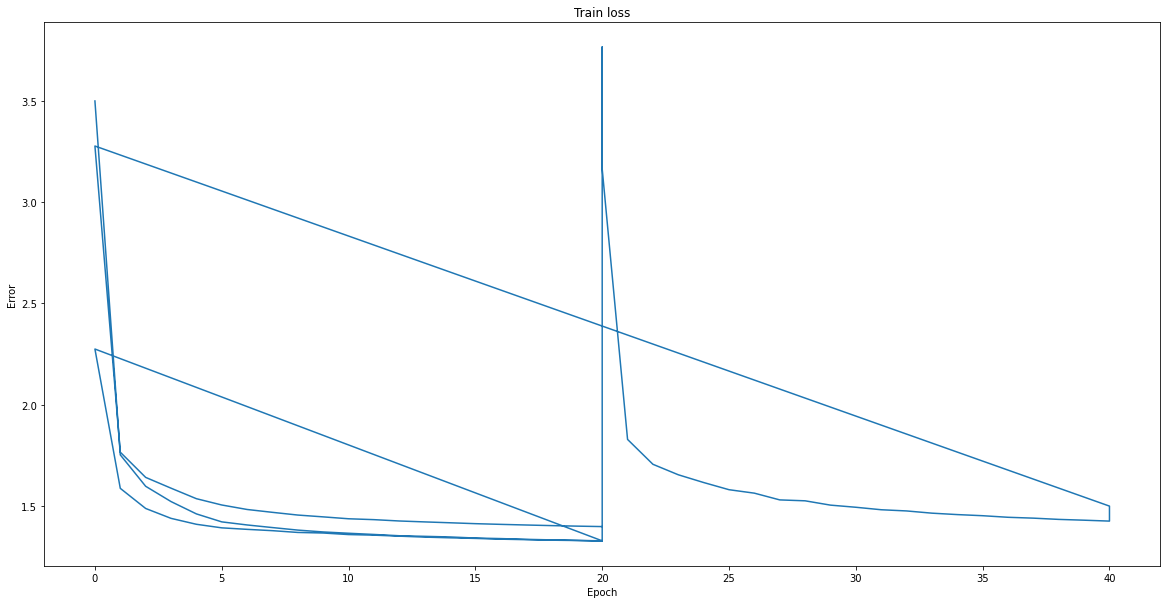

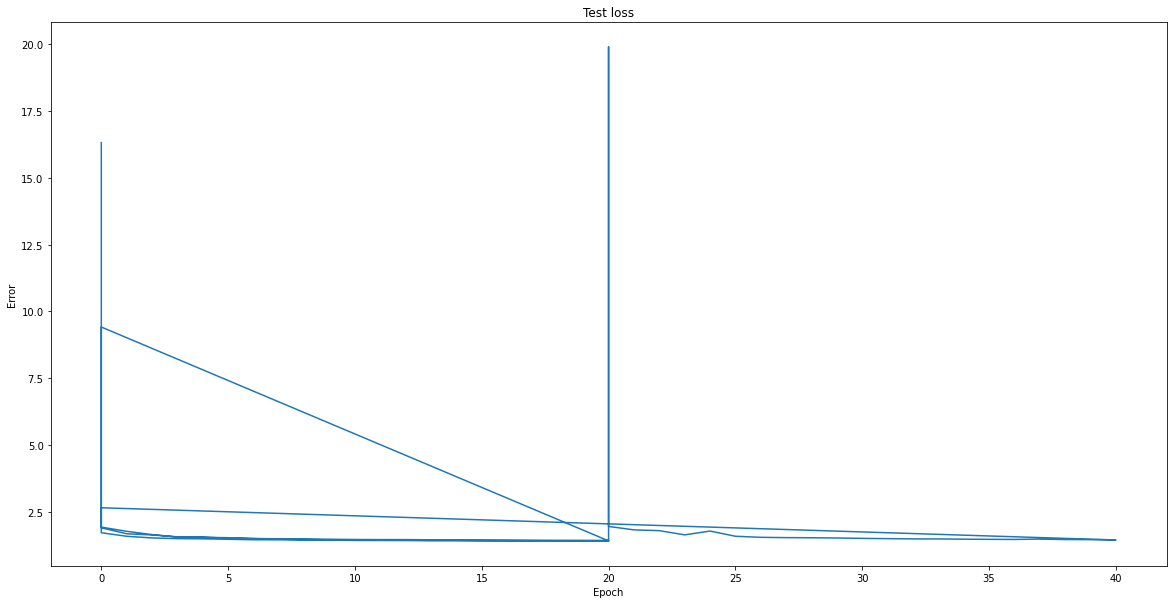

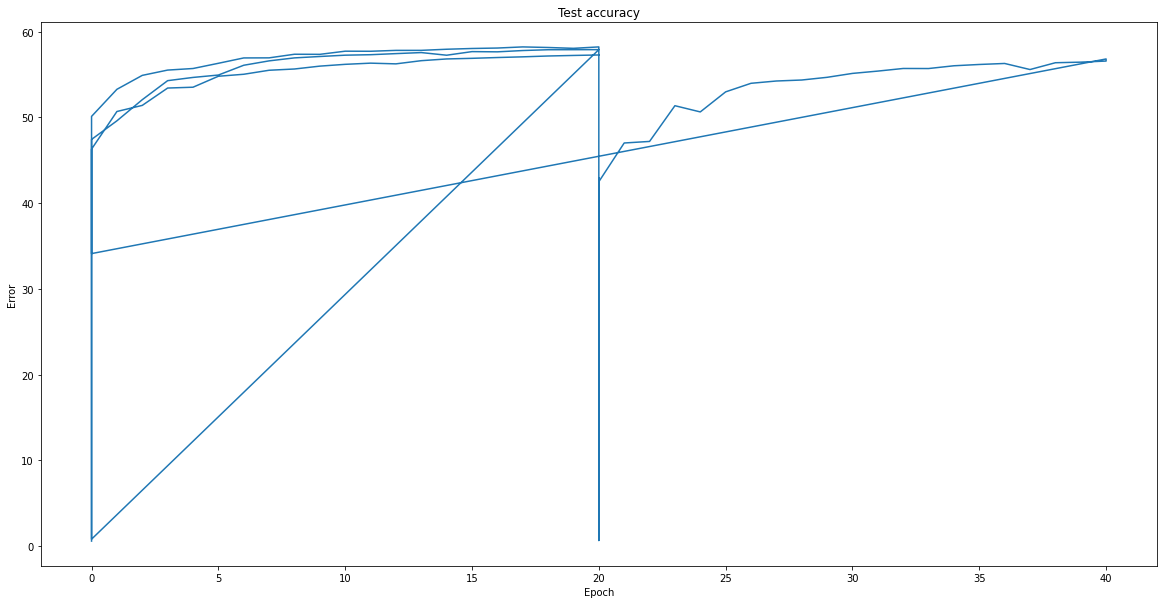

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'test_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'test_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    #print(next(iter(train_loader))[0].shape)
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints2')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints2/%03d.pt' % epoch)
            seed_words = 'Ah, distinctly I remember, it was in the bleak December,'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints2/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

f_final_model, vocab, device = main()

In [ ]:
eval_final_model(f_final_model, vocab, device)

generated with max	 Harry Potter and the countess and the countess and the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess and the countess of the countess and the 
generated with sample	 Harry Potter and the said a heartly time, then spreads thought the gard. you lay the twenty of them as that my dear north, and am moral asspicatedy--that ardent listenance, they followed bitter fent out," short the Pary,
generated with sample	 Harry Potter and the poor coming to the woman at the cour dinnow: further offerest could arose papturom, who is the windom by still been sunch an ever sent to seal, and daughter, accoumn took on his countess, turn to loo
generated with sample	 Harry Potter and the overched Prince Andrew was they arrecked as about. They-Prince asked me to our manned, laugh for world, was it for to ingantic compassible and grattered exhanies. The worst then, to conversende all t
generated with sample	 Harr

# Part 8.3 The deeper GRU

In [ ]:
TEMPERATURE = 0.5
nlayer=4
class HarryPotterNetN(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNetN, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size,num_layers=nlayer, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)

        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()

        self.best_accuracy = -1
        print(self.vocab_size,self.feature_size)

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]

        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        #print("int the net",x.shape)#256 99 VS 512 89
        #print(self.vocab_size)

        embedded = self.encoder(x)
        output, hidden_state = self.gru(embedded, hidden_state)
        #print('hidden',hidden_state.shape)
        x = self.decoder(output)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
89 512



  0%|          | 0/194 [00:00<?, ?it/s]


Test set: Average loss: 5.2708, Accuracy: 11211/1228800 (1%)




  1%|          | 1/194 [00:00<03:06,  1.03it/s]

Train Epoch: 0 [0/49664 (0%)]	Loss: 5.248443



  6%|▌         | 11/194 [00:04<01:23,  2.18it/s]

Train Epoch: 0 [2560/49664 (5%)]	Loss: 37.408012



 11%|█         | 21/194 [00:08<01:18,  2.20it/s]

Train Epoch: 0 [5120/49664 (10%)]	Loss: 10.298991



 16%|█▌        | 31/194 [00:12<01:15,  2.15it/s]

Train Epoch: 0 [7680/49664 (15%)]	Loss: 7.729661



 21%|██        | 41/194 [00:16<01:11,  2.13it/s]

Train Epoch: 0 [10240/49664 (21%)]	Loss: 3.644476



 26%|██▋       | 51/194 [00:20<01:06,  2.14it/s]

Train Epoch: 0 [12800/49664 (26%)]	Loss: 2.972032



 31%|███▏      | 61/194 [00:25<01:03,  2.10it/s]

Train Epoch: 0 [15360/49664 (31%)]	Loss: 2.708876



 37%|███▋      | 71/194 [00:29<00:58,  2.10it/s]

Train Epoch: 0 [17920/49664 (36%)]	Loss: 2.572305



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 0 [20480/49664 (41%)]	Loss: 2.464746



 47%|████▋     | 91/194 [00:37<00:48,  2.14it/s]

Train Epoch: 0 [23040/49664 (46%)]	Loss: 2.394016



 52%|█████▏    | 101/194 [00:41<00:42,  2.17it/s]

Train Epoch: 0 [25600/49664 (52%)]	Loss: 2.336525



 57%|█████▋    | 111/194 [00:45<00:38,  2.17it/s]

Train Epoch: 0 [28160/49664 (57%)]	Loss: 2.273396



 62%|██████▏   | 121/194 [00:49<00:33,  2.19it/s]

Train Epoch: 0 [30720/49664 (62%)]	Loss: 2.245015



 68%|██████▊   | 131/194 [00:53<00:28,  2.22it/s]

Train Epoch: 0 [33280/49664 (67%)]	Loss: 2.195873



 73%|███████▎  | 141/194 [00:57<00:23,  2.22it/s]

Train Epoch: 0 [35840/49664 (72%)]	Loss: 2.126630



 78%|███████▊  | 151/194 [01:01<00:19,  2.22it/s]

Train Epoch: 0 [38400/49664 (77%)]	Loss: 2.111680



 83%|████████▎ | 161/194 [01:05<00:14,  2.22it/s]

Train Epoch: 0 [40960/49664 (82%)]	Loss: 2.037768



 88%|████████▊ | 171/194 [01:09<00:10,  2.22it/s]

Train Epoch: 0 [43520/49664 (88%)]	Loss: 2.039483



 93%|█████████▎| 181/194 [01:13<00:05,  2.24it/s]

Train Epoch: 0 [46080/49664 (93%)]	Loss: 1.972995



 98%|█████████▊| 191/194 [01:16<00:01,  2.22it/s]

Train Epoch: 0 [48640/49664 (98%)]	Loss: 1.961644



100%|██████████| 194/194 [01:18<00:00,  2.48it/s]



Test set: Average loss: 1.9741, Accuracy: 546271/1228800 (44%)

Saved /content/checkpoints/000.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I the was said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry said Harry sa
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. fact him farliyn at alide up prest catiaslvy. "Throontey, lettniould onther simming hiscig." Catir, Rnosell. "Hhatwic ald and if slacekedingeind eversing heic ham nacedle, far the!" sard acy swelle. "
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.  He gist was istary bolthat eped them iris frotwhesing hove on get bintly. "I said kins. he alwass will. Harry," she wurset dointing. "Yiull.." IN'p u et edyNou winth twand yelparts..." Cutint, wisthi
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . .......................................................................................................................................................................................................




  1%|          | 1/194 [00:01<03:12,  1.00it/s]

Train Epoch: 1 [0/49664 (0%)]	Loss: 1.982448



  6%|▌         | 11/194 [00:04<01:25,  2.15it/s]

Train Epoch: 1 [2560/49664 (5%)]	Loss: 1.971444



 11%|█         | 21/194 [00:08<01:18,  2.20it/s]

Train Epoch: 1 [5120/49664 (10%)]	Loss: 1.945105



 16%|█▌        | 31/194 [00:12<01:15,  2.16it/s]

Train Epoch: 1 [7680/49664 (15%)]	Loss: 1.923736



 21%|██        | 41/194 [00:16<01:11,  2.15it/s]

Train Epoch: 1 [10240/49664 (21%)]	Loss: 1.877848



 26%|██▋       | 51/194 [00:20<01:07,  2.11it/s]

Train Epoch: 1 [12800/49664 (26%)]	Loss: 1.858926



 31%|███▏      | 61/194 [00:25<01:04,  2.08it/s]

Train Epoch: 1 [15360/49664 (31%)]	Loss: 1.808333



 37%|███▋      | 71/194 [00:29<00:59,  2.07it/s]

Train Epoch: 1 [17920/49664 (36%)]	Loss: 1.796185



 42%|████▏     | 81/194 [00:33<00:54,  2.08it/s]

Train Epoch: 1 [20480/49664 (41%)]	Loss: 1.784301



 47%|████▋     | 91/194 [00:37<00:48,  2.12it/s]

Train Epoch: 1 [23040/49664 (46%)]	Loss: 1.774710



 52%|█████▏    | 101/194 [00:41<00:43,  2.15it/s]

Train Epoch: 1 [25600/49664 (52%)]	Loss: 1.755049



 57%|█████▋    | 111/194 [00:45<00:38,  2.15it/s]

Train Epoch: 1 [28160/49664 (57%)]	Loss: 1.745433



 62%|██████▏   | 121/194 [00:49<00:33,  2.16it/s]

Train Epoch: 1 [30720/49664 (62%)]	Loss: 1.769631



 68%|██████▊   | 131/194 [00:53<00:28,  2.19it/s]

Train Epoch: 1 [33280/49664 (67%)]	Loss: 1.851466



 73%|███████▎  | 141/194 [00:57<00:24,  2.19it/s]

Train Epoch: 1 [35840/49664 (72%)]	Loss: 1.785400



 78%|███████▊  | 151/194 [01:01<00:19,  2.21it/s]

Train Epoch: 1 [38400/49664 (77%)]	Loss: 1.748848



 83%|████████▎ | 161/194 [01:05<00:15,  2.20it/s]

Train Epoch: 1 [40960/49664 (82%)]	Loss: 1.700753



 88%|████████▊ | 171/194 [01:09<00:10,  2.20it/s]

Train Epoch: 1 [43520/49664 (88%)]	Loss: 1.714997



 93%|█████████▎| 181/194 [01:13<00:05,  2.20it/s]

Train Epoch: 1 [46080/49664 (93%)]	Loss: 1.654391



 98%|█████████▊| 191/194 [01:17<00:01,  2.21it/s]

Train Epoch: 1 [48640/49664 (98%)]	Loss: 1.666364



100%|██████████| 194/194 [01:18<00:00,  2.47it/s]



Test set: Average loss: 1.7045, Accuracy: 622441/1228800 (51%)

Saved /content/checkpoints/001.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I the was and the been to the took of the comple to the took of the comple to the took of the comple to the took of the comple to the took of the comple to the took of the comple to the took of the c
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. om where we known which the under oft lose," he said enthere wille, "' clome. "But get of them." "any or their floorer ast his blatchel! "what; do and the Id'd on the took of the cabared. "Id you goo 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Le alown thighor-? I'm abvobity like to have hurfulined thilk Cherctuached thore been thing he traded to them wooks'? "UGn,' but sture eye was so tomenthter hoadals? houls on wonks. Telthey whated, no
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry had been in the from the more of the wanted to the wanted to the more of the more of the more of the wanted to the more of the more of the wanted to the wanted to the more of the come of the more




  1%|          | 1/194 [00:01<03:15,  1.01s/it]

Train Epoch: 2 [0/49664 (0%)]	Loss: 1.680156



  6%|▌         | 11/194 [00:04<01:26,  2.11it/s]

Train Epoch: 2 [2560/49664 (5%)]	Loss: 1.688287



 11%|█         | 21/194 [00:08<01:19,  2.17it/s]

Train Epoch: 2 [5120/49664 (10%)]	Loss: 1.692190



 16%|█▌        | 31/194 [00:12<01:14,  2.18it/s]

Train Epoch: 2 [7680/49664 (15%)]	Loss: 1.643664



 21%|██        | 41/194 [00:16<01:11,  2.14it/s]

Train Epoch: 2 [10240/49664 (21%)]	Loss: 1.766150



 26%|██▋       | 51/194 [00:20<01:07,  2.13it/s]

Train Epoch: 2 [12800/49664 (26%)]	Loss: 1.752075



 31%|███▏      | 61/194 [00:25<01:03,  2.09it/s]

Train Epoch: 2 [15360/49664 (31%)]	Loss: 1.649002



 37%|███▋      | 71/194 [00:29<00:59,  2.08it/s]

Train Epoch: 2 [17920/49664 (36%)]	Loss: 1.623274



 42%|████▏     | 81/194 [00:33<00:54,  2.07it/s]

Train Epoch: 2 [20480/49664 (41%)]	Loss: 1.601780



 47%|████▋     | 91/194 [00:37<00:49,  2.07it/s]

Train Epoch: 2 [23040/49664 (46%)]	Loss: 1.597671



 52%|█████▏    | 101/194 [00:41<00:43,  2.12it/s]

Train Epoch: 2 [25600/49664 (52%)]	Loss: 1.585581



 57%|█████▋    | 111/194 [00:45<00:38,  2.16it/s]

Train Epoch: 2 [28160/49664 (57%)]	Loss: 1.583188



 62%|██████▏   | 121/194 [00:49<00:33,  2.15it/s]

Train Epoch: 2 [30720/49664 (62%)]	Loss: 1.617653



 68%|██████▊   | 131/194 [00:53<00:29,  2.16it/s]

Train Epoch: 2 [33280/49664 (67%)]	Loss: 1.604532



 73%|███████▎  | 141/194 [00:57<00:24,  2.19it/s]

Train Epoch: 2 [35840/49664 (72%)]	Loss: 1.583709



 78%|███████▊  | 151/194 [01:01<00:19,  2.19it/s]

Train Epoch: 2 [38400/49664 (77%)]	Loss: 1.653159



 83%|████████▎ | 161/194 [01:05<00:15,  2.20it/s]

Train Epoch: 2 [40960/49664 (82%)]	Loss: 1.573442



 88%|████████▊ | 171/194 [01:09<00:10,  2.19it/s]

Train Epoch: 2 [43520/49664 (88%)]	Loss: 1.585087



 93%|█████████▎| 181/194 [01:13<00:05,  2.21it/s]

Train Epoch: 2 [46080/49664 (93%)]	Loss: 1.540324



 98%|█████████▊| 191/194 [01:17<00:01,  2.21it/s]

Train Epoch: 2 [48640/49664 (98%)]	Loss: 1.545380



100%|██████████| 194/194 [01:18<00:00,  2.47it/s]



Test set: Average loss: 1.5985, Accuracy: 654863/1228800 (53%)

Saved /content/checkpoints/002.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was standing at the completer the one of the completer the one of the completer the one of the completer the one of the completer the one of the completer the one of the completer the one of the co
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. rst under," Harry's Harry's man. But queth, Elatie was was boys vermione spand," said Ron't snown it. You shooks. Dum loweran' Miman' I'm unguest of Prousps tietiying of lows is just of everyting horm
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry closed loukder; he said slowly as he did not bed the encortant do your," shilking and cloused that tell was?" hants peered Harry, more fistly heappy, has?" Hagrals quiltiantrumhed, shirily. "Hagr
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor Dumbledore, who was standing at the one of the was standing at the come on the first that he would have been in the other was standing at the come on the first that he would have been to the 




  1%|          | 1/194 [00:01<03:16,  1.02s/it]

Train Epoch: 3 [0/49664 (0%)]	Loss: 1.557125



  6%|▌         | 11/194 [00:04<01:25,  2.14it/s]

Train Epoch: 3 [2560/49664 (5%)]	Loss: 1.573833



 11%|█         | 21/194 [00:08<01:19,  2.17it/s]

Train Epoch: 3 [5120/49664 (10%)]	Loss: 1.556825



 16%|█▌        | 31/194 [00:12<01:15,  2.16it/s]

Train Epoch: 3 [7680/49664 (15%)]	Loss: 1.574963



 21%|██        | 41/194 [00:16<01:11,  2.15it/s]

Train Epoch: 3 [10240/49664 (21%)]	Loss: 1.706884



 26%|██▋       | 51/194 [00:20<01:08,  2.10it/s]

Train Epoch: 3 [12800/49664 (26%)]	Loss: 1.608503



 31%|███▏      | 61/194 [00:25<01:03,  2.09it/s]

Train Epoch: 3 [15360/49664 (31%)]	Loss: 1.535234



 37%|███▋      | 71/194 [00:29<00:59,  2.07it/s]

Train Epoch: 3 [17920/49664 (36%)]	Loss: 1.515049



 42%|████▏     | 81/194 [00:33<00:54,  2.07it/s]

Train Epoch: 3 [20480/49664 (41%)]	Loss: 1.524659



 47%|████▋     | 91/194 [00:37<00:48,  2.12it/s]

Train Epoch: 3 [23040/49664 (46%)]	Loss: 1.544755



 52%|█████▏    | 101/194 [00:41<00:43,  2.13it/s]

Train Epoch: 3 [25600/49664 (52%)]	Loss: 1.524025



 57%|█████▋    | 111/194 [00:45<00:38,  2.15it/s]

Train Epoch: 3 [28160/49664 (57%)]	Loss: 1.515982



 62%|██████▏   | 121/194 [00:49<00:33,  2.17it/s]

Train Epoch: 3 [30720/49664 (62%)]	Loss: 1.541194



 68%|██████▊   | 131/194 [00:53<00:29,  2.17it/s]

Train Epoch: 3 [33280/49664 (67%)]	Loss: 1.506460



 73%|███████▎  | 141/194 [00:57<00:24,  2.19it/s]

Train Epoch: 3 [35840/49664 (72%)]	Loss: 1.507607



 78%|███████▊  | 151/194 [01:01<00:19,  2.18it/s]

Train Epoch: 3 [38400/49664 (77%)]	Loss: 1.583047



 83%|████████▎ | 161/194 [01:05<00:14,  2.21it/s]

Train Epoch: 3 [40960/49664 (82%)]	Loss: 1.525965



 88%|████████▊ | 171/194 [01:09<00:10,  2.20it/s]

Train Epoch: 3 [43520/49664 (88%)]	Loss: 1.516012



 93%|█████████▎| 181/194 [01:13<00:05,  2.20it/s]

Train Epoch: 3 [46080/49664 (93%)]	Loss: 1.479021



 98%|█████████▊| 191/194 [01:17<00:01,  2.21it/s]

Train Epoch: 3 [48640/49664 (98%)]	Loss: 1.521147



100%|██████████| 194/194 [01:18<00:00,  2.47it/s]



Test set: Average loss: 1.5738, Accuracy: 660810/1228800 (54%)

Saved /content/checkpoints/003.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was started the table that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were that they 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ven it cased them that Petcuse, "I!" said Cnotless and hipe was and rowed to be been and he'll putteed them be started take of shouldly not emptanting in the opened had catiled. He saw memore someone 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry saw a who work year he than spreadmed strable, still and Surius and grandard lane been about their feethed. "Aur nother. "I ampaint?" And them teasenve browsens are wond unatest on their wiaroun
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry had nothing that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were tha




  1%|          | 1/194 [00:01<03:17,  1.02s/it]

Train Epoch: 4 [0/49664 (0%)]	Loss: 1.523136



  6%|▌         | 11/194 [00:04<01:26,  2.13it/s]

Train Epoch: 4 [2560/49664 (5%)]	Loss: 1.515317



 11%|█         | 21/194 [00:08<01:19,  2.18it/s]

Train Epoch: 4 [5120/49664 (10%)]	Loss: 1.502209



 16%|█▌        | 31/194 [00:12<01:15,  2.16it/s]

Train Epoch: 4 [7680/49664 (15%)]	Loss: 1.548229



 21%|██        | 41/194 [00:16<01:11,  2.14it/s]

Train Epoch: 4 [10240/49664 (21%)]	Loss: 1.510076



 26%|██▋       | 51/194 [00:20<01:07,  2.12it/s]

Train Epoch: 4 [12800/49664 (26%)]	Loss: 1.496019



 31%|███▏      | 61/194 [00:25<01:03,  2.08it/s]

Train Epoch: 4 [15360/49664 (31%)]	Loss: 1.462699



 37%|███▋      | 71/194 [00:29<00:59,  2.07it/s]

Train Epoch: 4 [17920/49664 (36%)]	Loss: 1.496762



 42%|████▏     | 81/194 [00:33<00:54,  2.09it/s]

Train Epoch: 4 [20480/49664 (41%)]	Loss: 1.518885



 47%|████▋     | 91/194 [00:37<00:48,  2.11it/s]

Train Epoch: 4 [23040/49664 (46%)]	Loss: 1.504717



 52%|█████▏    | 101/194 [00:41<00:43,  2.15it/s]

Train Epoch: 4 [25600/49664 (52%)]	Loss: 1.471058



 57%|█████▋    | 111/194 [00:45<00:38,  2.15it/s]

Train Epoch: 4 [28160/49664 (57%)]	Loss: 1.472248



 62%|██████▏   | 121/194 [00:49<00:33,  2.16it/s]

Train Epoch: 4 [30720/49664 (62%)]	Loss: 1.498548



 68%|██████▊   | 131/194 [00:53<00:28,  2.19it/s]

Train Epoch: 4 [33280/49664 (67%)]	Loss: 1.467050



 73%|███████▎  | 141/194 [00:57<00:23,  2.21it/s]

Train Epoch: 4 [35840/49664 (72%)]	Loss: 1.482104



 78%|███████▊  | 151/194 [01:01<00:19,  2.20it/s]

Train Epoch: 4 [38400/49664 (77%)]	Loss: 1.509107



 83%|████████▎ | 161/194 [01:05<00:14,  2.21it/s]

Train Epoch: 4 [40960/49664 (82%)]	Loss: 1.458640



 88%|████████▊ | 171/194 [01:09<00:10,  2.20it/s]

Train Epoch: 4 [43520/49664 (88%)]	Loss: 1.454078



 93%|█████████▎| 181/194 [01:13<00:05,  2.20it/s]

Train Epoch: 4 [46080/49664 (93%)]	Loss: 1.448562



 98%|█████████▊| 191/194 [01:17<00:01,  2.19it/s]

Train Epoch: 4 [48640/49664 (98%)]	Loss: 1.493954



100%|██████████| 194/194 [01:18<00:00,  2.48it/s]



Test set: Average loss: 1.5594, Accuracy: 663240/1228800 (54%)

Saved /content/checkpoints/004.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said Harry, said 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ut he custly down slick. Candler You sale dell, Harry, the could as Whoss!" said Harry sall on their langers' he was no one light. Aup has someone classin signall as she scaped to rais bewled from his
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. You'll knot comply less, this wannfing his sents. Nasight, I must Svent 1ave you can't?" "'ll mawer open. Harry, whole back and inlered direly was summent -haD's you says instreasty class splanstival 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around that he was standing his back on the first that he was standing in the back on the back on the first that he was standing in the back on the back on the first that he was something 




  1%|          | 1/194 [00:01<03:15,  1.01s/it]

Train Epoch: 5 [0/49664 (0%)]	Loss: 1.500065



  6%|▌         | 11/194 [00:04<01:26,  2.11it/s]

Train Epoch: 5 [2560/49664 (5%)]	Loss: 1.512892



 11%|█         | 21/194 [00:08<01:19,  2.19it/s]

Train Epoch: 5 [5120/49664 (10%)]	Loss: 1.468729



 16%|█▌        | 31/194 [00:12<01:15,  2.16it/s]

Train Epoch: 5 [7680/49664 (15%)]	Loss: 1.456987



 21%|██        | 41/194 [00:16<01:11,  2.14it/s]

Train Epoch: 5 [10240/49664 (21%)]	Loss: 1.493262



 26%|██▋       | 51/194 [00:20<01:07,  2.13it/s]

Train Epoch: 5 [12800/49664 (26%)]	Loss: 1.494925



 31%|███▏      | 61/194 [00:25<01:03,  2.10it/s]

Train Epoch: 5 [15360/49664 (31%)]	Loss: 1.434946



 37%|███▋      | 71/194 [00:29<00:58,  2.09it/s]

Train Epoch: 5 [17920/49664 (36%)]	Loss: 1.430082



 42%|████▏     | 81/194 [00:33<00:54,  2.08it/s]

Train Epoch: 5 [20480/49664 (41%)]	Loss: 1.432362



 47%|████▋     | 91/194 [00:37<00:49,  2.10it/s]

Train Epoch: 5 [23040/49664 (46%)]	Loss: 1.440930



 52%|█████▏    | 101/194 [00:41<00:43,  2.12it/s]

Train Epoch: 5 [25600/49664 (52%)]	Loss: 1.434413



 57%|█████▋    | 111/194 [00:45<00:38,  2.15it/s]

Train Epoch: 5 [28160/49664 (57%)]	Loss: 1.453816



 62%|██████▏   | 121/194 [00:49<00:33,  2.16it/s]

Train Epoch: 5 [30720/49664 (62%)]	Loss: 1.491619



 68%|██████▊   | 131/194 [00:53<00:29,  2.16it/s]

Train Epoch: 5 [33280/49664 (67%)]	Loss: 1.496085



 73%|███████▎  | 141/194 [00:57<00:24,  2.19it/s]

Train Epoch: 5 [35840/49664 (72%)]	Loss: 1.440727



 78%|███████▊  | 151/194 [01:01<00:19,  2.20it/s]

Train Epoch: 5 [38400/49664 (77%)]	Loss: 1.493112



 83%|████████▎ | 161/194 [01:05<00:15,  2.18it/s]

Train Epoch: 5 [40960/49664 (82%)]	Loss: 1.435233



 88%|████████▊ | 171/194 [01:09<00:10,  2.20it/s]

Train Epoch: 5 [43520/49664 (88%)]	Loss: 1.430817



 93%|█████████▎| 181/194 [01:13<00:05,  2.20it/s]

Train Epoch: 5 [46080/49664 (93%)]	Loss: 1.408428



 98%|█████████▊| 191/194 [01:17<00:01,  2.21it/s]

Train Epoch: 5 [48640/49664 (98%)]	Loss: 1.435343



100%|██████████| 194/194 [01:18<00:00,  2.47it/s]



Test set: Average loss: 1.5238, Accuracy: 676681/1228800 (55%)

Saved /content/checkpoints/005.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ut hard how he much our eparmsing sloply at in his taben can mumpached that Harry. . . course that he Gulder no what Bu cover things by the killer always fell. Snape, an'thing Fred wing widen aran exp
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. nme a com. . . Cost of this us she felt speake duice and munatue at onk of Hagrid, scart an anciler was a sound if the chanking the darkness as an other hands. pale becaush again. Ahe. At the Gich old
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around that he was standing around that he was standing around that he was standing around that he was standing around that he was standing around that he was standing in the back on the f




  1%|          | 1/194 [00:01<03:14,  1.01s/it]

Train Epoch: 6 [0/49664 (0%)]	Loss: 1.459598



  6%|▌         | 11/194 [00:04<01:25,  2.14it/s]

Train Epoch: 6 [2560/49664 (5%)]	Loss: 1.492921



 11%|█         | 21/194 [00:08<01:19,  2.18it/s]

Train Epoch: 6 [5120/49664 (10%)]	Loss: 1.461395



 16%|█▌        | 31/194 [00:12<01:14,  2.18it/s]

Train Epoch: 6 [7680/49664 (15%)]	Loss: 1.424844



 21%|██        | 41/194 [00:16<01:11,  2.14it/s]

Train Epoch: 6 [10240/49664 (21%)]	Loss: 1.426710



 26%|██▋       | 51/194 [00:20<01:07,  2.11it/s]

Train Epoch: 6 [12800/49664 (26%)]	Loss: 1.449760



 31%|███▏      | 61/194 [00:25<01:03,  2.10it/s]

Train Epoch: 6 [15360/49664 (31%)]	Loss: 1.422923



 37%|███▋      | 71/194 [00:29<00:59,  2.08it/s]

Train Epoch: 6 [17920/49664 (36%)]	Loss: 1.418272



 42%|████▏     | 81/194 [00:33<00:54,  2.08it/s]

Train Epoch: 6 [20480/49664 (41%)]	Loss: 1.422321



 47%|████▋     | 91/194 [00:37<00:48,  2.12it/s]

Train Epoch: 6 [23040/49664 (46%)]	Loss: 1.421430



 52%|█████▏    | 101/194 [00:41<00:43,  2.13it/s]

Train Epoch: 6 [25600/49664 (52%)]	Loss: 1.441683



 57%|█████▋    | 111/194 [00:45<00:38,  2.15it/s]

Train Epoch: 6 [28160/49664 (57%)]	Loss: 1.497696



 62%|██████▏   | 121/194 [00:49<00:33,  2.17it/s]

Train Epoch: 6 [30720/49664 (62%)]	Loss: 1.466208



 68%|██████▊   | 131/194 [00:53<00:28,  2.18it/s]

Train Epoch: 6 [33280/49664 (67%)]	Loss: 1.423571



 73%|███████▎  | 141/194 [00:57<00:24,  2.18it/s]

Train Epoch: 6 [35840/49664 (72%)]	Loss: 1.407171



 78%|███████▊  | 151/194 [01:01<00:19,  2.19it/s]

Train Epoch: 6 [38400/49664 (77%)]	Loss: 1.432259



 83%|████████▎ | 161/194 [01:05<00:15,  2.18it/s]

Train Epoch: 6 [40960/49664 (82%)]	Loss: 1.392818



 88%|████████▊ | 171/194 [01:09<00:10,  2.22it/s]

Train Epoch: 6 [43520/49664 (88%)]	Loss: 1.408522



 93%|█████████▎| 181/194 [01:13<00:05,  2.23it/s]

Train Epoch: 6 [46080/49664 (93%)]	Loss: 1.398854



 98%|█████████▊| 191/194 [01:17<00:01,  2.20it/s]

Train Epoch: 6 [48640/49664 (98%)]	Loss: 1.446869



100%|██████████| 194/194 [01:18<00:00,  2.48it/s]



Test set: Average loss: 1.5665, Accuracy: 666638/1228800 (54%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I think that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were that they were that they w
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry followed the Nauntage taxe times and deam and the group as he was leeter "Yeaus!" In anythings will jeaphants me who calls seconds the expast Destill meetely an offerent was sounded the door. A D
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. althat the dooryars were skew ously pulled tempatederstant to start talking to meet En2to Hagrid. Ron, while dary, that casley, these killed her sents a besite the fast thwists turned turning to tawe 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. t was sound each oldshapely, saidd


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was standing that he was standing that he was standing that they were that they were that they were that they were that they were that they were that they were that they were that they were that 




  1%|          | 1/194 [00:01<03:13,  1.00s/it]

Train Epoch: 7 [0/49664 (0%)]	Loss: 1.502844



  6%|▌         | 11/194 [00:04<01:25,  2.14it/s]

Train Epoch: 7 [2560/49664 (5%)]	Loss: 1.464261



 11%|█         | 21/194 [00:08<01:18,  2.19it/s]

Train Epoch: 7 [5120/49664 (10%)]	Loss: 1.419842



 16%|█▌        | 31/194 [00:12<01:15,  2.17it/s]

Train Epoch: 7 [7680/49664 (15%)]	Loss: 1.410221



 21%|██        | 41/194 [00:16<01:11,  2.14it/s]

Train Epoch: 7 [10240/49664 (21%)]	Loss: 1.412512



 26%|██▋       | 51/194 [00:20<01:08,  2.09it/s]

Train Epoch: 7 [12800/49664 (26%)]	Loss: 1.425595



 31%|███▏      | 61/194 [00:25<01:03,  2.09it/s]

Train Epoch: 7 [15360/49664 (31%)]	Loss: 1.406853



 37%|███▋      | 71/194 [00:29<00:59,  2.08it/s]

Train Epoch: 7 [17920/49664 (36%)]	Loss: 1.407948



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 7 [20480/49664 (41%)]	Loss: 1.400465



 47%|████▋     | 91/194 [00:37<00:48,  2.13it/s]

Train Epoch: 7 [23040/49664 (46%)]	Loss: 1.404670



 52%|█████▏    | 101/194 [00:41<00:43,  2.14it/s]

Train Epoch: 7 [25600/49664 (52%)]	Loss: 1.391311



 57%|█████▋    | 111/194 [00:45<00:38,  2.18it/s]

Train Epoch: 7 [28160/49664 (57%)]	Loss: 1.414204



 62%|██████▏   | 121/194 [00:49<00:33,  2.18it/s]

Train Epoch: 7 [30720/49664 (62%)]	Loss: 1.468544



 68%|██████▊   | 131/194 [00:53<00:28,  2.18it/s]

Train Epoch: 7 [33280/49664 (67%)]	Loss: 1.426750



 73%|███████▎  | 141/194 [00:57<00:24,  2.21it/s]

Train Epoch: 7 [35840/49664 (72%)]	Loss: 1.413206



 78%|███████▊  | 151/194 [01:01<00:19,  2.22it/s]

Train Epoch: 7 [38400/49664 (77%)]	Loss: 1.434310



 83%|████████▎ | 161/194 [01:05<00:14,  2.21it/s]

Train Epoch: 7 [40960/49664 (82%)]	Loss: 1.383192



 88%|████████▊ | 171/194 [01:09<00:10,  2.22it/s]

Train Epoch: 7 [43520/49664 (88%)]	Loss: 1.398748



 93%|█████████▎| 181/194 [01:13<00:05,  2.22it/s]

Train Epoch: 7 [46080/49664 (93%)]	Loss: 1.380777



 98%|█████████▊| 191/194 [01:16<00:01,  2.19it/s]

Train Epoch: 7 [48640/49664 (98%)]	Loss: 1.461510



100%|██████████| 194/194 [01:18<00:00,  2.48it/s]



Test set: Average loss: 1.5107, Accuracy: 682341/1228800 (56%)

Saved /content/checkpoints/007.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was not any of the castle and saw that he was standing an an an our off the castle and saw that he was standing an an an our off the castle and saw that he was standing an an an our off the castle 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. istened to his feace. "he was getting hin affeening all the pale discopenably castle olided away ears as he was now. "Anyon't about thew'll ofs gop. "You already butstered, looking on the left, about 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry says empty. "Weh couldn't Real Aucia look chanking calfament at her, of what care of all before had been accoudly in matheter, do you 'no, who'pinning back to his usualls. Terelawing out here. "H
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry couldn't have been called out of his back out of his back out of his back out of his back out of his back out of his face was standing out of his back out of his back out of his face was standing




  1%|          | 1/194 [00:00<03:07,  1.03it/s]

Train Epoch: 8 [0/49664 (0%)]	Loss: 1.445666



  6%|▌         | 11/194 [00:04<01:25,  2.15it/s]

Train Epoch: 8 [2560/49664 (5%)]	Loss: 1.448472



 11%|█         | 21/194 [00:08<01:18,  2.20it/s]

Train Epoch: 8 [5120/49664 (10%)]	Loss: 1.414680



 16%|█▌        | 31/194 [00:12<01:14,  2.17it/s]

Train Epoch: 8 [7680/49664 (15%)]	Loss: 1.404658



 21%|██        | 41/194 [00:16<01:10,  2.16it/s]

Train Epoch: 8 [10240/49664 (21%)]	Loss: 1.396161



 26%|██▋       | 51/194 [00:20<01:07,  2.13it/s]

Train Epoch: 8 [12800/49664 (26%)]	Loss: 1.434007



 31%|███▏      | 61/194 [00:25<01:03,  2.10it/s]

Train Epoch: 8 [15360/49664 (31%)]	Loss: 1.384774



 37%|███▋      | 71/194 [00:29<00:58,  2.09it/s]

Train Epoch: 8 [17920/49664 (36%)]	Loss: 1.383782



 42%|████▏     | 81/194 [00:33<00:53,  2.12it/s]

Train Epoch: 8 [20480/49664 (41%)]	Loss: 1.397563



 47%|████▋     | 91/194 [00:37<00:48,  2.13it/s]

Train Epoch: 8 [23040/49664 (46%)]	Loss: 1.382249



 52%|█████▏    | 101/194 [00:41<00:42,  2.16it/s]

Train Epoch: 8 [25600/49664 (52%)]	Loss: 1.373949



 57%|█████▋    | 111/194 [00:45<00:37,  2.19it/s]

Train Epoch: 8 [28160/49664 (57%)]	Loss: 1.396763



 62%|██████▏   | 121/194 [00:49<00:33,  2.18it/s]

Train Epoch: 8 [30720/49664 (62%)]	Loss: 1.437984



 68%|██████▊   | 131/194 [00:53<00:28,  2.21it/s]

Train Epoch: 8 [33280/49664 (67%)]	Loss: 1.426764



 73%|███████▎  | 141/194 [00:57<00:23,  2.22it/s]

Train Epoch: 8 [35840/49664 (72%)]	Loss: 1.419177



 78%|███████▊  | 151/194 [01:01<00:19,  2.22it/s]

Train Epoch: 8 [38400/49664 (77%)]	Loss: 1.438711



 83%|████████▎ | 161/194 [01:05<00:15,  2.20it/s]

Train Epoch: 8 [40960/49664 (82%)]	Loss: 1.390794



 88%|████████▊ | 171/194 [01:08<00:10,  2.23it/s]

Train Epoch: 8 [43520/49664 (88%)]	Loss: 1.384624



 93%|█████████▎| 181/194 [01:12<00:05,  2.22it/s]

Train Epoch: 8 [46080/49664 (93%)]	Loss: 1.397165



 98%|█████████▊| 191/194 [01:16<00:01,  2.22it/s]

Train Epoch: 8 [48640/49664 (98%)]	Loss: 1.384094



100%|██████████| 194/194 [01:17<00:00,  2.49it/s]



Test set: Average loss: 1.4643, Accuracy: 695452/1228800 (57%)

Saved /content/checkpoints/008.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are you are y
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. So. She was had liarding belop had he is sbuttling down at the lapp of the weat one of two him need. "Gay not beat be of them antimily through the bottom around, and she all livet of the top echo acro
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. o that -I don't want tame, so neemer vostering at eartier Polis o-close, luffry. Con as past yourself.. "I think Potter, it close and disprievice vers collint diary annoyed if a could be crouchally. K
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione as though he was starting at the other side of that he was standing at the corridor that he was starting at the corridor that he was standing at the other side of the castle, and the




  1%|          | 1/194 [00:01<03:16,  1.02s/it]

Train Epoch: 9 [0/49664 (0%)]	Loss: 1.396217



  6%|▌         | 11/194 [00:04<01:25,  2.14it/s]

Train Epoch: 9 [2560/49664 (5%)]	Loss: 1.416285



 11%|█         | 21/194 [00:08<01:18,  2.21it/s]

Train Epoch: 9 [5120/49664 (10%)]	Loss: 1.397366



 16%|█▌        | 31/194 [00:12<01:14,  2.17it/s]

Train Epoch: 9 [7680/49664 (15%)]	Loss: 1.401673



 21%|██        | 41/194 [00:16<01:10,  2.17it/s]

Train Epoch: 9 [10240/49664 (21%)]	Loss: 1.389484



 26%|██▋       | 51/194 [00:20<01:06,  2.16it/s]

Train Epoch: 9 [12800/49664 (26%)]	Loss: 1.403291



 31%|███▏      | 61/194 [00:24<01:03,  2.09it/s]

Train Epoch: 9 [15360/49664 (31%)]	Loss: 1.378985



 37%|███▋      | 71/194 [00:29<00:58,  2.10it/s]

Train Epoch: 9 [17920/49664 (36%)]	Loss: 1.376459



 42%|████▏     | 81/194 [00:33<00:54,  2.08it/s]

Train Epoch: 9 [20480/49664 (41%)]	Loss: 1.376242



 47%|████▋     | 91/194 [00:37<00:48,  2.12it/s]

Train Epoch: 9 [23040/49664 (46%)]	Loss: 1.376912



 52%|█████▏    | 101/194 [00:41<00:43,  2.15it/s]

Train Epoch: 9 [25600/49664 (52%)]	Loss: 1.362214



 57%|█████▋    | 111/194 [00:45<00:38,  2.16it/s]

Train Epoch: 9 [28160/49664 (57%)]	Loss: 1.386759



 62%|██████▏   | 121/194 [00:49<00:33,  2.18it/s]

Train Epoch: 9 [30720/49664 (62%)]	Loss: 1.443980



 68%|██████▊   | 131/194 [00:53<00:28,  2.20it/s]

Train Epoch: 9 [33280/49664 (67%)]	Loss: 1.414496



 73%|███████▎  | 141/194 [00:57<00:23,  2.21it/s]

Train Epoch: 9 [35840/49664 (72%)]	Loss: 1.383787



 78%|███████▊  | 151/194 [01:01<00:19,  2.23it/s]

Train Epoch: 9 [38400/49664 (77%)]	Loss: 1.398966



 83%|████████▎ | 161/194 [01:05<00:14,  2.22it/s]

Train Epoch: 9 [40960/49664 (82%)]	Loss: 1.361416



 88%|████████▊ | 171/194 [01:09<00:10,  2.20it/s]

Train Epoch: 9 [43520/49664 (88%)]	Loss: 1.422876



 93%|█████████▎| 181/194 [01:13<00:05,  2.19it/s]

Train Epoch: 9 [46080/49664 (93%)]	Loss: 1.377192



 98%|█████████▊| 191/194 [01:16<00:01,  2.20it/s]

Train Epoch: 9 [48640/49664 (98%)]	Loss: 1.376694



100%|██████████| 194/194 [01:18<00:00,  2.48it/s]



Test set: Average loss: 1.4551, Accuracy: 697764/1228800 (57%)

Saved /content/checkpoints/009.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think that they were to come of the common room to the common room with the corridor with the compantact to the compantact to the compantact to the compantact to the compantact to the compant
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. runnelx. "Seet its hand." "He lost contently. "That's really. Then?" Harry suppect woul voice, Harry. "I you? No," said Malfoy. Harry's seven down the commonty potter. Well stared suddenly bunin. Wrea
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Soh,Sony arrived, an' it disting room with Sirius's for of them?" "You were it wouldn't it?" Ron looked marble to a second momenty her worrifice. Harry, wouldn't both Ron he did Hocewer much and he ha
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around at the corridor, and they were looking out of the standing out of the castle, and Harry looked around at the corridor, and they were continued out of the castle, and Harry couldn't 




  1%|          | 1/194 [00:00<03:08,  1.02it/s]

Train Epoch: 10 [0/49664 (0%)]	Loss: 1.385160



  6%|▌         | 11/194 [00:04<01:24,  2.16it/s]

Train Epoch: 10 [2560/49664 (5%)]	Loss: 1.421802



 11%|█         | 21/194 [00:08<01:18,  2.21it/s]

Train Epoch: 10 [5120/49664 (10%)]	Loss: 1.386621



 16%|█▌        | 31/194 [00:12<01:14,  2.19it/s]

Train Epoch: 10 [7680/49664 (15%)]	Loss: 1.385095



 21%|██        | 41/194 [00:16<01:10,  2.16it/s]

Train Epoch: 10 [10240/49664 (21%)]	Loss: 1.379064



 26%|██▋       | 51/194 [00:20<01:06,  2.15it/s]

Train Epoch: 10 [12800/49664 (26%)]	Loss: 1.371846



 31%|███▏      | 61/194 [00:24<01:02,  2.12it/s]

Train Epoch: 10 [15360/49664 (31%)]	Loss: 1.348081



 37%|███▋      | 71/194 [00:29<00:58,  2.09it/s]

Train Epoch: 10 [17920/49664 (36%)]	Loss: 1.368834



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 10 [20480/49664 (41%)]	Loss: 1.385126



 47%|████▋     | 91/194 [00:37<00:48,  2.12it/s]

Train Epoch: 10 [23040/49664 (46%)]	Loss: 1.382857



 52%|█████▏    | 101/194 [00:41<00:43,  2.15it/s]

Train Epoch: 10 [25600/49664 (52%)]	Loss: 1.358788



 57%|█████▋    | 111/194 [00:45<00:38,  2.15it/s]

Train Epoch: 10 [28160/49664 (57%)]	Loss: 1.371852



 62%|██████▏   | 121/194 [00:49<00:33,  2.20it/s]

Train Epoch: 10 [30720/49664 (62%)]	Loss: 1.406729



 68%|██████▊   | 131/194 [00:53<00:28,  2.21it/s]

Train Epoch: 10 [33280/49664 (67%)]	Loss: 1.370410



 73%|███████▎  | 141/194 [00:57<00:23,  2.21it/s]

Train Epoch: 10 [35840/49664 (72%)]	Loss: 1.401627



 78%|███████▊  | 151/194 [01:01<00:19,  2.22it/s]

Train Epoch: 10 [38400/49664 (77%)]	Loss: 1.394244



 83%|████████▎ | 161/194 [01:05<00:14,  2.21it/s]

Train Epoch: 10 [40960/49664 (82%)]	Loss: 1.349390



 88%|████████▊ | 171/194 [01:09<00:10,  2.20it/s]

Train Epoch: 10 [43520/49664 (88%)]	Loss: 1.364150



 93%|█████████▎| 181/194 [01:12<00:05,  2.22it/s]

Train Epoch: 10 [46080/49664 (93%)]	Loss: 1.368450



 98%|█████████▊| 191/194 [01:16<00:01,  2.22it/s]

Train Epoch: 10 [48640/49664 (98%)]	Loss: 1.366470



100%|██████████| 194/194 [01:18<00:00,  2.49it/s]



Test set: Average loss: 1.4506, Accuracy: 699366/1228800 (57%)

Saved /content/checkpoints/010.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what he was a long to the first that he was a long to the common room the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the corridor to the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. agrid turned to okea that their while when I near your ents oher," he said, Owzerviely, DomoAry was alreading rolling lovesly littles bath, and not to not work to dis about E cabin. . . Heah SImeasins
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. You dreeding task. "CAm do your know !" "I'll don't going on they're teacher ... Unaniably. I was booming." "Noine!" he had er prefence. They'll right was a corner, althout with Harry getting to his c
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione that he had been in the corridor that they were that they were that they were that they had been in the corridor that he was going to the front of them that they were that they were 




  1%|          | 1/194 [00:00<03:09,  1.02it/s]

Train Epoch: 11 [0/49664 (0%)]	Loss: 1.375195



  6%|▌         | 11/194 [00:04<01:24,  2.16it/s]

Train Epoch: 11 [2560/49664 (5%)]	Loss: 1.387205



 11%|█         | 21/194 [00:08<01:18,  2.22it/s]

Train Epoch: 11 [5120/49664 (10%)]	Loss: 1.399012



 16%|█▌        | 31/194 [00:12<01:14,  2.20it/s]

Train Epoch: 11 [7680/49664 (15%)]	Loss: 1.394580



 21%|██        | 41/194 [00:16<01:11,  2.14it/s]

Train Epoch: 11 [10240/49664 (21%)]	Loss: 1.378038



 26%|██▋       | 51/194 [00:20<01:07,  2.13it/s]

Train Epoch: 11 [12800/49664 (26%)]	Loss: 1.372272



 31%|███▏      | 61/194 [00:24<01:02,  2.11it/s]

Train Epoch: 11 [15360/49664 (31%)]	Loss: 1.333427



 37%|███▋      | 71/194 [00:29<00:58,  2.09it/s]

Train Epoch: 11 [17920/49664 (36%)]	Loss: 1.364935



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 11 [20480/49664 (41%)]	Loss: 1.383805



 47%|████▋     | 91/194 [00:37<00:48,  2.11it/s]

Train Epoch: 11 [23040/49664 (46%)]	Loss: 1.379460



 52%|█████▏    | 101/194 [00:41<00:42,  2.17it/s]

Train Epoch: 11 [25600/49664 (52%)]	Loss: 1.346872



 57%|█████▋    | 111/194 [00:45<00:38,  2.18it/s]

Train Epoch: 11 [28160/49664 (57%)]	Loss: 1.358603



 62%|██████▏   | 121/194 [00:49<00:33,  2.19it/s]

Train Epoch: 11 [30720/49664 (62%)]	Loss: 1.412145



 68%|██████▊   | 131/194 [00:53<00:28,  2.20it/s]

Train Epoch: 11 [33280/49664 (67%)]	Loss: 1.394741



 73%|███████▎  | 141/194 [00:57<00:23,  2.22it/s]

Train Epoch: 11 [35840/49664 (72%)]	Loss: 1.374248



 78%|███████▊  | 151/194 [01:01<00:19,  2.22it/s]

Train Epoch: 11 [38400/49664 (77%)]	Loss: 1.389748



 83%|████████▎ | 161/194 [01:05<00:14,  2.21it/s]

Train Epoch: 11 [40960/49664 (82%)]	Loss: 1.347861



 88%|████████▊ | 171/194 [01:08<00:10,  2.22it/s]

Train Epoch: 11 [43520/49664 (88%)]	Loss: 1.364162



 93%|█████████▎| 181/194 [01:12<00:05,  2.24it/s]

Train Epoch: 11 [46080/49664 (93%)]	Loss: 1.353386



 98%|█████████▊| 191/194 [01:16<00:01,  2.24it/s]

Train Epoch: 11 [48640/49664 (98%)]	Loss: 1.392249



100%|██████████| 194/194 [01:17<00:00,  2.49it/s]



Test set: Average loss: 1.4824, Accuracy: 687062/1228800 (56%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I wouldn't have been an one of the common room where they were took another words were won't be allowed to be able to see the common room where they were took another words were sounded out of the co
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. nclear than Ron, pointing, as he really, order the groane blunding hair was in the dark or another was a loada paper more fourthearts. The woodsk, butting loudly and there'll worned his hand. Currying
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Of I before howsing too. Lust meet to her, facing Harry forewer. Encle we'll look at once boy someworkdoof on Goarder slightly." "I took her her hair hands! she passed with Harry shudderstood downted.
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. No, Moody-keart nomon room;." ") s


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry," said Hermione, and Harry couldn't have been continued to have been continued to have been continued to have been allowed toward them. Harry looked around at the common room. Harry looked aroun




  1%|          | 1/194 [00:00<03:08,  1.03it/s]

Train Epoch: 12 [0/49664 (0%)]	Loss: 1.408207



  6%|▌         | 11/194 [00:04<01:25,  2.15it/s]

Train Epoch: 12 [2560/49664 (5%)]	Loss: 1.389447



 11%|█         | 21/194 [00:08<01:18,  2.21it/s]

Train Epoch: 12 [5120/49664 (10%)]	Loss: 1.363265



 16%|█▌        | 31/194 [00:12<01:14,  2.19it/s]

Train Epoch: 12 [7680/49664 (15%)]	Loss: 1.359865



 21%|██        | 41/194 [00:16<01:11,  2.15it/s]

Train Epoch: 12 [10240/49664 (21%)]	Loss: 1.356578



 26%|██▋       | 51/194 [00:20<01:06,  2.14it/s]

Train Epoch: 12 [12800/49664 (26%)]	Loss: 1.410012



 31%|███▏      | 61/194 [00:24<01:03,  2.10it/s]

Train Epoch: 12 [15360/49664 (31%)]	Loss: 1.347791



 37%|███▋      | 71/194 [00:29<00:59,  2.08it/s]

Train Epoch: 12 [17920/49664 (36%)]	Loss: 1.336870



 42%|████▏     | 81/194 [00:33<00:54,  2.08it/s]

Train Epoch: 12 [20480/49664 (41%)]	Loss: 1.341474



 47%|████▋     | 91/194 [00:37<00:49,  2.10it/s]

Train Epoch: 12 [23040/49664 (46%)]	Loss: 1.345680



 52%|█████▏    | 101/194 [00:41<00:43,  2.15it/s]

Train Epoch: 12 [25600/49664 (52%)]	Loss: 1.357751



 57%|█████▋    | 111/194 [00:45<00:37,  2.19it/s]

Train Epoch: 12 [28160/49664 (57%)]	Loss: 1.417123



 62%|██████▏   | 121/194 [00:49<00:33,  2.19it/s]

Train Epoch: 12 [30720/49664 (62%)]	Loss: 1.422556



 68%|██████▊   | 131/194 [00:53<00:28,  2.21it/s]

Train Epoch: 12 [33280/49664 (67%)]	Loss: 1.363729



 73%|███████▎  | 141/194 [00:57<00:23,  2.22it/s]

Train Epoch: 12 [35840/49664 (72%)]	Loss: 1.344583



 78%|███████▊  | 151/194 [01:01<00:19,  2.22it/s]

Train Epoch: 12 [38400/49664 (77%)]	Loss: 1.367413



 83%|████████▎ | 161/194 [01:05<00:14,  2.23it/s]

Train Epoch: 12 [40960/49664 (82%)]	Loss: 1.329858



 88%|████████▊ | 171/194 [01:09<00:10,  2.22it/s]

Train Epoch: 12 [43520/49664 (88%)]	Loss: 1.347978



 93%|█████████▎| 181/194 [01:12<00:05,  2.23it/s]

Train Epoch: 12 [46080/49664 (93%)]	Loss: 1.374033



 98%|█████████▊| 191/194 [01:16<00:01,  2.22it/s]

Train Epoch: 12 [48640/49664 (98%)]	Loss: 1.351192



100%|██████████| 194/194 [01:18<00:00,  2.49it/s]



Test set: Average loss: 1.4493, Accuracy: 695861/1228800 (57%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I would have been one of the corridor with the corridor with the corridor with the corridor with the corridor with the corridor with his face was something of his face. "I would have been one of the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. 2uall righ withours, quips for a hour," Dumbledore's poisomation as hooks. Harry said xudot glammer enviously. "A suppoared Parbers. " Moping with Hockhart. You had not been be comingling by the broom
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. parker found now Aunt Ers, list. She was the longy up and somebodimals. "They've not feel eupban do socek..." said Hermione, spotting about their dessks and. "Wou know who has wonder!" she said. "What
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Athe Margon jour," said Ron. "Ten 


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was something. Harry was something he had been continued out of the corridor, and Harry, who was looking around his eyes. "What would have been one of them," said Hermione, and Hermione had been 




  1%|          | 1/194 [00:00<03:09,  1.02it/s]

Train Epoch: 13 [0/49664 (0%)]	Loss: 1.371834



  6%|▌         | 11/194 [00:04<01:25,  2.14it/s]

Train Epoch: 13 [2560/49664 (5%)]	Loss: 1.399283



 11%|█         | 21/194 [00:08<01:18,  2.20it/s]

Train Epoch: 13 [5120/49664 (10%)]	Loss: 1.364872



 16%|█▌        | 31/194 [00:12<01:14,  2.20it/s]

Train Epoch: 13 [7680/49664 (15%)]	Loss: 1.352183



 21%|██        | 41/194 [00:16<01:10,  2.17it/s]

Train Epoch: 13 [10240/49664 (21%)]	Loss: 1.347589



 26%|██▋       | 51/194 [00:20<01:07,  2.13it/s]

Train Epoch: 13 [12800/49664 (26%)]	Loss: 1.354671



 31%|███▏      | 61/194 [00:24<01:03,  2.11it/s]

Train Epoch: 13 [15360/49664 (31%)]	Loss: 1.327122



 37%|███▋      | 71/194 [00:29<00:58,  2.09it/s]

Train Epoch: 13 [17920/49664 (36%)]	Loss: 1.349719



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 13 [20480/49664 (41%)]	Loss: 1.350741



 47%|████▋     | 91/194 [00:37<00:48,  2.11it/s]

Train Epoch: 13 [23040/49664 (46%)]	Loss: 1.339495



 52%|█████▏    | 101/194 [00:41<00:43,  2.16it/s]

Train Epoch: 13 [25600/49664 (52%)]	Loss: 1.334312



 57%|█████▋    | 111/194 [00:45<00:38,  2.14it/s]

Train Epoch: 13 [28160/49664 (57%)]	Loss: 1.349270



 62%|██████▏   | 121/194 [00:49<00:33,  2.20it/s]

Train Epoch: 13 [30720/49664 (62%)]	Loss: 1.386897



 68%|██████▊   | 131/194 [00:53<00:28,  2.21it/s]

Train Epoch: 13 [33280/49664 (67%)]	Loss: 1.359165



 73%|███████▎  | 141/194 [00:57<00:23,  2.22it/s]

Train Epoch: 13 [35840/49664 (72%)]	Loss: 1.377428



 78%|███████▊  | 151/194 [01:01<00:19,  2.23it/s]

Train Epoch: 13 [38400/49664 (77%)]	Loss: 1.377285



 83%|████████▎ | 161/194 [01:05<00:14,  2.23it/s]

Train Epoch: 13 [40960/49664 (82%)]	Loss: 1.327187



 88%|████████▊ | 171/194 [01:08<00:10,  2.23it/s]

Train Epoch: 13 [43520/49664 (88%)]	Loss: 1.350139



 93%|█████████▎| 181/194 [01:12<00:05,  2.23it/s]

Train Epoch: 13 [46080/49664 (93%)]	Loss: 1.359123



 98%|█████████▊| 191/194 [01:16<00:01,  2.20it/s]

Train Epoch: 13 [48640/49664 (98%)]	Loss: 1.371744



100%|██████████| 194/194 [01:17<00:00,  2.49it/s]



Test set: Average loss: 1.4521, Accuracy: 699117/1228800 (57%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was a start carefully that the castle was a start carefully that he was staring the castle that he was staring the stairs and the castle stare that the castle stared the castle that he was staring 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ot we've have reruped? Ah. Ron, posterid to express. "Carry.K!" "Ghat's that we had to meet these.?' Yearly mean, you had got this, across the Mrofessor Tone was sure its last," said Harry, help, crum
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. he waze small gave his blandher aim. "I I will be er practic," said Mr. Weasley. "Another you keep not wrote?" samMage Harry headed to the fhoppet as he salishing his case the scatkets we aloness wh s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. umbledore as the 8reath Crysts, Ch


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry," said Harry, and Hermione said. "Harry," said Harry, and Hermione said. "Harry," said Harry. "Harry," said Harry, and Hermione said. "Harry," said Harry. "Harry," said Harry, and Hermione said,




  1%|          | 1/194 [00:00<03:11,  1.01it/s]

Train Epoch: 14 [0/49664 (0%)]	Loss: 1.373468



  6%|▌         | 11/194 [00:04<01:24,  2.16it/s]

Train Epoch: 14 [2560/49664 (5%)]	Loss: 1.380374



 11%|█         | 21/194 [00:08<01:17,  2.22it/s]

Train Epoch: 14 [5120/49664 (10%)]	Loss: 1.350971



 16%|█▌        | 31/194 [00:12<01:14,  2.19it/s]

Train Epoch: 14 [7680/49664 (15%)]	Loss: 1.341404



 21%|██        | 41/194 [00:16<01:10,  2.18it/s]

Train Epoch: 14 [10240/49664 (21%)]	Loss: 1.342196



 26%|██▋       | 51/194 [00:20<01:06,  2.14it/s]

Train Epoch: 14 [12800/49664 (26%)]	Loss: 1.371378



 31%|███▏      | 61/194 [00:24<01:02,  2.11it/s]

Train Epoch: 14 [15360/49664 (31%)]	Loss: 1.319320



 37%|███▋      | 71/194 [00:29<00:58,  2.09it/s]

Train Epoch: 14 [17920/49664 (36%)]	Loss: 1.338826



 42%|████▏     | 81/194 [00:33<00:53,  2.11it/s]

Train Epoch: 14 [20480/49664 (41%)]	Loss: 1.343679



 47%|████▋     | 91/194 [00:37<00:49,  2.10it/s]

Train Epoch: 14 [23040/49664 (46%)]	Loss: 1.335638



 52%|█████▏    | 101/194 [00:41<00:43,  2.15it/s]

Train Epoch: 14 [25600/49664 (52%)]	Loss: 1.321197



 57%|█████▋    | 111/194 [00:45<00:38,  2.18it/s]

Train Epoch: 14 [28160/49664 (57%)]	Loss: 1.362053



 62%|██████▏   | 121/194 [00:49<00:33,  2.19it/s]

Train Epoch: 14 [30720/49664 (62%)]	Loss: 1.405233



 68%|██████▊   | 131/194 [00:53<00:28,  2.20it/s]

Train Epoch: 14 [33280/49664 (67%)]	Loss: 1.352828



 73%|███████▎  | 141/194 [00:57<00:23,  2.22it/s]

Train Epoch: 14 [35840/49664 (72%)]	Loss: 1.354458



 78%|███████▊  | 151/194 [01:01<00:19,  2.19it/s]

Train Epoch: 14 [38400/49664 (77%)]	Loss: 1.361145



 83%|████████▎ | 161/194 [01:05<00:14,  2.22it/s]

Train Epoch: 14 [40960/49664 (82%)]	Loss: 1.326453



 88%|████████▊ | 171/194 [01:09<00:10,  2.20it/s]

Train Epoch: 14 [43520/49664 (88%)]	Loss: 1.349130



 93%|█████████▎| 181/194 [01:12<00:05,  2.23it/s]

Train Epoch: 14 [46080/49664 (93%)]	Loss: 1.332212



 98%|█████████▊| 191/194 [01:16<00:01,  2.22it/s]

Train Epoch: 14 [48640/49664 (98%)]	Loss: 1.332544



100%|██████████| 194/194 [01:18<00:00,  2.49it/s]



Test set: Average loss: 1.4235, Accuracy: 706878/1228800 (58%)

Saved /content/checkpoints/014.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was a long of the common room when he was something to come of the common room where the common room where the common room was staring at the corner of the corner of the corner of the corner of the
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. the awers could it won't we ill', feel -- As hear yourse," he can black the spoks supposition as though the wall gasped the crysper to five it, his romal cloud ofll past a few really press. There was 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. The lifty that temm sence of this compects of hunches of that he had bared to contry compartment, Dumbledore?" Ohe were still said, "3ask it look in the knocknall." "A face agreen with I were a few mo
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry," said Harry, and Hermione was staring out of the castle. Harry was staring out of the castle. Harry looked around the corner than he couldn't have been continued to the common room. Harry looke




  1%|          | 1/194 [00:00<03:12,  1.00it/s]

Train Epoch: 15 [0/49664 (0%)]	Loss: 1.341723



  6%|▌         | 11/194 [00:04<01:24,  2.16it/s]

Train Epoch: 15 [2560/49664 (5%)]	Loss: 1.366354



 11%|█         | 21/194 [00:08<01:17,  2.22it/s]

Train Epoch: 15 [5120/49664 (10%)]	Loss: 1.346037



 16%|█▌        | 31/194 [00:12<01:15,  2.16it/s]

Train Epoch: 15 [7680/49664 (15%)]	Loss: 1.337889



 21%|██        | 41/194 [00:16<01:10,  2.17it/s]

Train Epoch: 15 [10240/49664 (21%)]	Loss: 1.329030



 26%|██▋       | 51/194 [00:20<01:06,  2.14it/s]

Train Epoch: 15 [12800/49664 (26%)]	Loss: 1.353278



 31%|███▏      | 61/194 [00:24<01:03,  2.11it/s]

Train Epoch: 15 [15360/49664 (31%)]	Loss: 1.322619



 37%|███▋      | 71/194 [00:29<00:58,  2.10it/s]

Train Epoch: 15 [17920/49664 (36%)]	Loss: 1.319222



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 15 [20480/49664 (41%)]	Loss: 1.325962



 47%|████▋     | 91/194 [00:37<00:48,  2.12it/s]

Train Epoch: 15 [23040/49664 (46%)]	Loss: 1.330555



 52%|█████▏    | 101/194 [00:41<00:43,  2.14it/s]

Train Epoch: 15 [25600/49664 (52%)]	Loss: 1.324198



 57%|█████▋    | 111/194 [00:45<00:37,  2.19it/s]

Train Epoch: 15 [28160/49664 (57%)]	Loss: 1.333664



 62%|██████▏   | 121/194 [00:49<00:33,  2.18it/s]

Train Epoch: 15 [30720/49664 (62%)]	Loss: 1.372891



 68%|██████▊   | 131/194 [00:53<00:28,  2.18it/s]

Train Epoch: 15 [33280/49664 (67%)]	Loss: 1.359686



 73%|███████▎  | 141/194 [00:57<00:23,  2.22it/s]

Train Epoch: 15 [35840/49664 (72%)]	Loss: 1.357798



 78%|███████▊  | 151/194 [01:01<00:19,  2.23it/s]

Train Epoch: 15 [38400/49664 (77%)]	Loss: 1.356736



 83%|████████▎ | 161/194 [01:05<00:14,  2.22it/s]

Train Epoch: 15 [40960/49664 (82%)]	Loss: 1.322491



 88%|████████▊ | 171/194 [01:08<00:10,  2.23it/s]

Train Epoch: 15 [43520/49664 (88%)]	Loss: 1.345113



 93%|█████████▎| 181/194 [01:12<00:05,  2.22it/s]

Train Epoch: 15 [46080/49664 (93%)]	Loss: 1.316710



 98%|█████████▊| 191/194 [01:16<00:01,  2.23it/s]

Train Epoch: 15 [48640/49664 (98%)]	Loss: 1.326071



100%|██████████| 194/194 [01:17<00:00,  2.49it/s]



Test set: Average loss: 1.4180, Accuracy: 709508/1228800 (58%)

Saved /content/checkpoints/015.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was the only of the common room when he was starting to the common room when he was starting to the common room where the corner than he was starting to the common room where the corner than he was
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. odfices we gages." It susported the servation care, sure that seemed its rafe socces of ready but as you say, metti4s, dynan, what do you scall the boat pent with a corner to Cry we -- not the last ni
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. but he was to fefor Oadn't want jobwon quiating an off an old rive's own about to want to take fucicly," said Loldemutta, slightly very broke sing to his vost of him would want to ty Malfoy!" Harry ne
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around the parchment as though he could have been continued that he was starting to the front of the corner than he could have been in the common room that he was starting toward the class




  1%|          | 1/194 [00:00<03:09,  1.02it/s]

Train Epoch: 16 [0/49664 (0%)]	Loss: 1.335867



  6%|▌         | 11/194 [00:04<01:24,  2.16it/s]

Train Epoch: 16 [2560/49664 (5%)]	Loss: 1.348128



 11%|█         | 21/194 [00:08<01:17,  2.22it/s]

Train Epoch: 16 [5120/49664 (10%)]	Loss: 1.366938



 16%|█▌        | 31/194 [00:12<01:13,  2.20it/s]

Train Epoch: 16 [7680/49664 (15%)]	Loss: 1.378583



 21%|██        | 41/194 [00:16<01:10,  2.18it/s]

Train Epoch: 16 [10240/49664 (21%)]	Loss: 1.338481



 26%|██▋       | 51/194 [00:20<01:06,  2.15it/s]

Train Epoch: 16 [12800/49664 (26%)]	Loss: 1.330240



 31%|███▏      | 61/194 [00:24<01:03,  2.11it/s]

Train Epoch: 16 [15360/49664 (31%)]	Loss: 1.305451



 37%|███▋      | 71/194 [00:29<00:58,  2.11it/s]

Train Epoch: 16 [17920/49664 (36%)]	Loss: 1.303662



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 16 [20480/49664 (41%)]	Loss: 1.317262



 47%|████▋     | 91/194 [00:37<00:48,  2.11it/s]

Train Epoch: 16 [23040/49664 (46%)]	Loss: 1.333910



 52%|█████▏    | 101/194 [00:41<00:42,  2.17it/s]

Train Epoch: 16 [25600/49664 (52%)]	Loss: 1.318354



 57%|█████▋    | 111/194 [00:45<00:37,  2.19it/s]

Train Epoch: 16 [28160/49664 (57%)]	Loss: 1.334822



 62%|██████▏   | 121/194 [00:49<00:33,  2.20it/s]

Train Epoch: 16 [30720/49664 (62%)]	Loss: 1.379160



 68%|██████▊   | 131/194 [00:53<00:28,  2.21it/s]

Train Epoch: 16 [33280/49664 (67%)]	Loss: 1.337602



 73%|███████▎  | 141/194 [00:57<00:23,  2.23it/s]

Train Epoch: 16 [35840/49664 (72%)]	Loss: 1.329029



 78%|███████▊  | 151/194 [01:01<00:19,  2.22it/s]

Train Epoch: 16 [38400/49664 (77%)]	Loss: 1.350896



 83%|████████▎ | 161/194 [01:04<00:14,  2.22it/s]

Train Epoch: 16 [40960/49664 (82%)]	Loss: 1.313305



 88%|████████▊ | 171/194 [01:08<00:10,  2.21it/s]

Train Epoch: 16 [43520/49664 (88%)]	Loss: 1.351723



 93%|█████████▎| 181/194 [01:12<00:05,  2.21it/s]

Train Epoch: 16 [46080/49664 (93%)]	Loss: 1.314983



 98%|█████████▊| 191/194 [01:16<00:01,  2.21it/s]

Train Epoch: 16 [48640/49664 (98%)]	Loss: 1.318181



100%|██████████| 194/194 [01:17<00:00,  2.49it/s]



Test set: Average loss: 1.4074, Accuracy: 712935/1228800 (58%)

Saved /content/checkpoints/016.pt

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what we were the only of the common room where the only thing they were the only of the corner of the corner of the corner of the castle was staring at the corner of the car was staring 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. nhalt full themselt chance knows," said Harry, watching deeply over award and leapt open the room white door of the spotting hair feeling awark, which the instaters undless had cleared this fung secon
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. e looked with back insaber on a solot of course. "The Eresh would poom leading you'd over toward Oll go tokour weither." Yously contic, oh all the past how that would me and must you must have long wo
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar.


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked around the parchment, and they could have been coming out of the common room, and they could have been continued to the common room. Harry was staring around the parchment, and they could 




  1%|          | 1/194 [00:01<03:14,  1.01s/it]

Train Epoch: 17 [0/49664 (0%)]	Loss: 1.323878



  6%|▌         | 11/194 [00:04<01:24,  2.16it/s]

Train Epoch: 17 [2560/49664 (5%)]	Loss: 1.347286



 11%|█         | 21/194 [00:08<01:18,  2.21it/s]

Train Epoch: 17 [5120/49664 (10%)]	Loss: 1.323552



 16%|█▌        | 31/194 [00:12<01:13,  2.21it/s]

Train Epoch: 17 [7680/49664 (15%)]	Loss: 1.332679



 21%|██        | 41/194 [00:16<01:10,  2.16it/s]

Train Epoch: 17 [10240/49664 (21%)]	Loss: 1.323862



 26%|██▋       | 51/194 [00:20<01:06,  2.13it/s]

Train Epoch: 17 [12800/49664 (26%)]	Loss: 1.339854



 31%|███▏      | 61/194 [00:24<01:02,  2.11it/s]

Train Epoch: 17 [15360/49664 (31%)]	Loss: 1.319063



 37%|███▋      | 71/194 [00:29<00:58,  2.10it/s]

Train Epoch: 17 [17920/49664 (36%)]	Loss: 1.329063



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 17 [20480/49664 (41%)]	Loss: 1.318938



 47%|████▋     | 91/194 [00:37<00:48,  2.13it/s]

Train Epoch: 17 [23040/49664 (46%)]	Loss: 1.313903



 52%|█████▏    | 101/194 [00:41<00:42,  2.17it/s]

Train Epoch: 17 [25600/49664 (52%)]	Loss: 1.313033



 57%|█████▋    | 111/194 [00:45<00:38,  2.18it/s]

Train Epoch: 17 [28160/49664 (57%)]	Loss: 1.328962



 62%|██████▏   | 121/194 [00:49<00:33,  2.19it/s]

Train Epoch: 17 [30720/49664 (62%)]	Loss: 1.351727



 68%|██████▊   | 131/194 [00:53<00:28,  2.20it/s]

Train Epoch: 17 [33280/49664 (67%)]	Loss: 1.326108



 73%|███████▎  | 141/194 [00:57<00:23,  2.21it/s]

Train Epoch: 17 [35840/49664 (72%)]	Loss: 1.338395



 78%|███████▊  | 151/194 [01:01<00:19,  2.18it/s]

Train Epoch: 17 [38400/49664 (77%)]	Loss: 1.345857



 83%|████████▎ | 161/194 [01:05<00:14,  2.21it/s]

Train Epoch: 17 [40960/49664 (82%)]	Loss: 1.308976



 88%|████████▊ | 171/194 [01:09<00:10,  2.23it/s]

Train Epoch: 17 [43520/49664 (88%)]	Loss: 1.338571



 93%|█████████▎| 181/194 [01:12<00:05,  2.23it/s]

Train Epoch: 17 [46080/49664 (93%)]	Loss: 1.332657



 98%|█████████▊| 191/194 [01:16<00:01,  2.23it/s]

Train Epoch: 17 [48640/49664 (98%)]	Loss: 1.329945



100%|██████████| 194/194 [01:18<00:00,  2.49it/s]



Test set: Average loss: 1.4245, Accuracy: 703614/1228800 (57%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I can call the only of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corner of the corn
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. What trafered you don't have too only the Granter." Crich, streaming wall in the largets. "I loads clunk, Parkaroff," he retched out of teachens of landes; was right boring his school dragotther. "I s
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. oldemort closesTy and done paintly, pulling off his cloak hall down, we gluyttered year to-servation as they allowed pigced now. "Where I our hands, siting near of the soch of the loctures smile, star
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. rown the reasons, the launting _ru


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione was still looking around the corner of the classroom. Harry looked around his head of the classroom. Harry looked around the corner of the classroom. Harry looked around the corner of the clas




  1%|          | 1/194 [00:00<03:02,  1.06it/s]

Train Epoch: 18 [0/49664 (0%)]	Loss: 1.341455



  6%|▌         | 11/194 [00:04<01:24,  2.17it/s]

Train Epoch: 18 [2560/49664 (5%)]	Loss: 1.330931



 11%|█         | 21/194 [00:08<01:17,  2.22it/s]

Train Epoch: 18 [5120/49664 (10%)]	Loss: 1.329194



 16%|█▌        | 31/194 [00:12<01:14,  2.20it/s]

Train Epoch: 18 [7680/49664 (15%)]	Loss: 1.321135



 21%|██        | 41/194 [00:16<01:09,  2.19it/s]

Train Epoch: 18 [10240/49664 (21%)]	Loss: 1.314558



 26%|██▋       | 51/194 [00:20<01:06,  2.16it/s]

Train Epoch: 18 [12800/49664 (26%)]	Loss: 1.334457



 31%|███▏      | 61/194 [00:24<01:02,  2.13it/s]

Train Epoch: 18 [15360/49664 (31%)]	Loss: 1.299384



 37%|███▋      | 71/194 [00:28<00:58,  2.10it/s]

Train Epoch: 18 [17920/49664 (36%)]	Loss: 1.308661



 42%|████▏     | 81/194 [00:33<00:54,  2.09it/s]

Train Epoch: 18 [20480/49664 (41%)]	Loss: 1.332882



 47%|████▋     | 91/194 [00:37<00:48,  2.14it/s]

Train Epoch: 18 [23040/49664 (46%)]	Loss: 1.336488



 52%|█████▏    | 101/194 [00:41<00:42,  2.17it/s]

Train Epoch: 18 [25600/49664 (52%)]	Loss: 1.302204



 57%|█████▋    | 111/194 [00:45<00:37,  2.20it/s]

Train Epoch: 18 [28160/49664 (57%)]	Loss: 1.317331



 62%|██████▏   | 121/194 [00:49<00:33,  2.21it/s]

Train Epoch: 18 [30720/49664 (62%)]	Loss: 1.343253



 68%|██████▊   | 131/194 [00:53<00:28,  2.22it/s]

Train Epoch: 18 [33280/49664 (67%)]	Loss: 1.322676



 73%|███████▎  | 141/194 [00:57<00:23,  2.24it/s]

Train Epoch: 18 [35840/49664 (72%)]	Loss: 1.347629



 78%|███████▊  | 151/194 [01:01<00:19,  2.24it/s]

Train Epoch: 18 [38400/49664 (77%)]	Loss: 1.355136



 83%|████████▎ | 161/194 [01:05<00:14,  2.24it/s]

Train Epoch: 18 [40960/49664 (82%)]	Loss: 1.310888



 88%|████████▊ | 171/194 [01:08<00:10,  2.23it/s]

Train Epoch: 18 [43520/49664 (88%)]	Loss: 1.324078



 93%|█████████▎| 181/194 [01:12<00:05,  2.25it/s]

Train Epoch: 18 [46080/49664 (93%)]	Loss: 1.300921



 98%|█████████▊| 191/194 [01:16<00:01,  2.24it/s]

Train Epoch: 18 [48640/49664 (98%)]	Loss: 1.317304



100%|██████████| 194/194 [01:17<00:00,  2.49it/s]



Test set: Average loss: 1.4081, Accuracy: 710892/1228800 (58%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what you were the one of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the cas
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ou can better seen the one enoure stoaring of a months!" he very tinied, they could Seeper keen near them, and Hersup face couldn't help more clearly grasp to tend throub thas my ear. They can think y
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. I am though, I's must find ow," said Umpris back from his eyes wallling, he had e be or having master breakfa&s, Smontact, Harry had entioment, all rabition than it would kive useful, now, puttinful D
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. t was wanting this destra!" "Abuso


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry and Hermione had been continued that he could have been in the common room. Harry was staring over the darkness. Harry was staring over the darkness that he had been carefully over the castle of 




  1%|          | 1/194 [00:00<03:05,  1.04it/s]

Train Epoch: 19 [0/49664 (0%)]	Loss: 1.319835



  6%|▌         | 11/194 [00:04<01:23,  2.18it/s]

Train Epoch: 19 [2560/49664 (5%)]	Loss: 1.335339



 11%|█         | 21/194 [00:08<01:17,  2.23it/s]

Train Epoch: 19 [5120/49664 (10%)]	Loss: 1.317237



 16%|█▌        | 31/194 [00:12<01:13,  2.21it/s]

Train Epoch: 19 [7680/49664 (15%)]	Loss: 1.321332



 21%|██        | 41/194 [00:16<01:10,  2.18it/s]

Train Epoch: 19 [10240/49664 (21%)]	Loss: 1.312662



 26%|██▋       | 51/194 [00:20<01:05,  2.17it/s]

Train Epoch: 19 [12800/49664 (26%)]	Loss: 1.327807



 31%|███▏      | 61/194 [00:24<01:02,  2.14it/s]

Train Epoch: 19 [15360/49664 (31%)]	Loss: 1.298933



 37%|███▋      | 71/194 [00:28<00:58,  2.11it/s]

Train Epoch: 19 [17920/49664 (36%)]	Loss: 1.290704



 42%|████▏     | 81/194 [00:33<00:53,  2.12it/s]

Train Epoch: 19 [20480/49664 (41%)]	Loss: 1.309524



 47%|████▋     | 91/194 [00:37<00:48,  2.14it/s]

Train Epoch: 19 [23040/49664 (46%)]	Loss: 1.306834



 52%|█████▏    | 101/194 [00:41<00:42,  2.17it/s]

Train Epoch: 19 [25600/49664 (52%)]	Loss: 1.298174



 57%|█████▋    | 111/194 [00:45<00:37,  2.19it/s]

Train Epoch: 19 [28160/49664 (57%)]	Loss: 1.324242



 62%|██████▏   | 121/194 [00:49<00:33,  2.21it/s]

Train Epoch: 19 [30720/49664 (62%)]	Loss: 1.365563



 68%|██████▊   | 131/194 [00:53<00:28,  2.22it/s]

Train Epoch: 19 [33280/49664 (67%)]	Loss: 1.333305



 73%|███████▎  | 141/194 [00:57<00:23,  2.23it/s]

Train Epoch: 19 [35840/49664 (72%)]	Loss: 1.328237



 78%|███████▊  | 151/194 [01:00<00:19,  2.21it/s]

Train Epoch: 19 [38400/49664 (77%)]	Loss: 1.336243



 83%|████████▎ | 161/194 [01:04<00:14,  2.23it/s]

Train Epoch: 19 [40960/49664 (82%)]	Loss: 1.295371



 88%|████████▊ | 171/194 [01:08<00:10,  2.24it/s]

Train Epoch: 19 [43520/49664 (88%)]	Loss: 1.322204



 93%|█████████▎| 181/194 [01:12<00:05,  2.25it/s]

Train Epoch: 19 [46080/49664 (93%)]	Loss: 1.312285



 98%|█████████▊| 191/194 [01:16<00:01,  2.24it/s]

Train Epoch: 19 [48640/49664 (98%)]	Loss: 1.330959



100%|██████████| 194/194 [01:17<00:00,  2.50it/s]



Test set: Average loss: 1.4204, Accuracy: 706025/1228800 (57%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I would have to come to the common room, and the other way the common remember than the other way the common restless that he was starting to come to the common room. He was starting to come to the c
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ft, too longletter halfb across his dobbry, which no hearnons when wement goodness throwring open. He'll yee, How, I'll over'voldemort have," said Harry, who had been ently cloapless and his final of 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. e before he got them the door had notuted here towards the mouth." he slid hold. Athe threelobs. "You that we've everyone knyw who'' halt them?" said Snape's all she would that is every -funsheving if
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. udley held off it up to feel with 


  0%|          | 0/194 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry couldn't have been able to completely that he wouldn't have been completely that he wouldn't have been able to getting out of them," said Hermione, looking around the common room. Harry had been 




  1%|          | 1/194 [00:00<03:08,  1.02it/s]

Train Epoch: 20 [0/49664 (0%)]	Loss: 1.333958



  6%|▌         | 11/194 [00:04<01:24,  2.17it/s]

Train Epoch: 20 [2560/49664 (5%)]	Loss: 1.364193



 11%|█         | 21/194 [00:08<01:18,  2.21it/s]

Train Epoch: 20 [5120/49664 (10%)]	Loss: 1.321379



 16%|█▌        | 31/194 [00:12<01:13,  2.22it/s]

Train Epoch: 20 [7680/49664 (15%)]	Loss: 1.309730



 21%|██        | 41/194 [00:16<01:10,  2.19it/s]

Train Epoch: 20 [10240/49664 (21%)]	Loss: 1.312451



 26%|██▋       | 51/194 [00:20<01:05,  2.17it/s]

Train Epoch: 20 [12800/49664 (26%)]	Loss: 1.316916



 31%|███▏      | 61/194 [00:24<01:02,  2.13it/s]

Train Epoch: 20 [15360/49664 (31%)]	Loss: 1.307149



 37%|███▋      | 71/194 [00:28<00:59,  2.08it/s]

Train Epoch: 20 [17920/49664 (36%)]	Loss: 1.293418



 42%|████▏     | 81/194 [00:33<00:53,  2.10it/s]

Train Epoch: 20 [20480/49664 (41%)]	Loss: 1.310092



 47%|████▋     | 91/194 [00:37<00:48,  2.14it/s]

Train Epoch: 20 [23040/49664 (46%)]	Loss: 1.298727



 52%|█████▏    | 101/194 [00:41<00:42,  2.17it/s]

Train Epoch: 20 [25600/49664 (52%)]	Loss: 1.304819



 57%|█████▋    | 111/194 [00:45<00:37,  2.19it/s]

Train Epoch: 20 [28160/49664 (57%)]	Loss: 1.312866



 62%|██████▏   | 121/194 [00:49<00:33,  2.20it/s]

Train Epoch: 20 [30720/49664 (62%)]	Loss: 1.342979



 68%|██████▊   | 131/194 [00:53<00:28,  2.23it/s]

Train Epoch: 20 [33280/49664 (67%)]	Loss: 1.322331



 73%|███████▎  | 141/194 [00:57<00:23,  2.23it/s]

Train Epoch: 20 [35840/49664 (72%)]	Loss: 1.327024



 78%|███████▊  | 151/194 [01:00<00:19,  2.24it/s]

Train Epoch: 20 [38400/49664 (77%)]	Loss: 1.347935



 83%|████████▎ | 161/194 [01:04<00:14,  2.24it/s]

Train Epoch: 20 [40960/49664 (82%)]	Loss: 1.311361



 88%|████████▊ | 171/194 [01:08<00:10,  2.25it/s]

Train Epoch: 20 [43520/49664 (88%)]	Loss: 1.309931



 93%|█████████▎| 181/194 [01:12<00:05,  2.25it/s]

Train Epoch: 20 [46080/49664 (93%)]	Loss: 1.287093



 98%|█████████▊| 191/194 [01:16<00:01,  2.25it/s]

Train Epoch: 20 [48640/49664 (98%)]	Loss: 1.306528



100%|██████████| 194/194 [01:17<00:00,  2.50it/s]



Test set: Average loss: 1.4076, Accuracy: 712509/1228800 (58%)

generated max		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I was a bit of the common room when he was still close the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. And not think usity fell into comsances of weight but he can's go the knyth things out of the preceiven conside of this on air!" he said to callime by a prutting whether hand handed. "you've everyone 
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. Which happing when we do it - it will an examiner right now, (happin, I'm such four he hiddress when he had heard' the centairs good guss hand out a morning so little by I\'s even fifty well.N aqbrudd
generated sample	 Harry Potter, Voldemort, and Dumbledore walk into a bar. ilthy closerising winds like door 

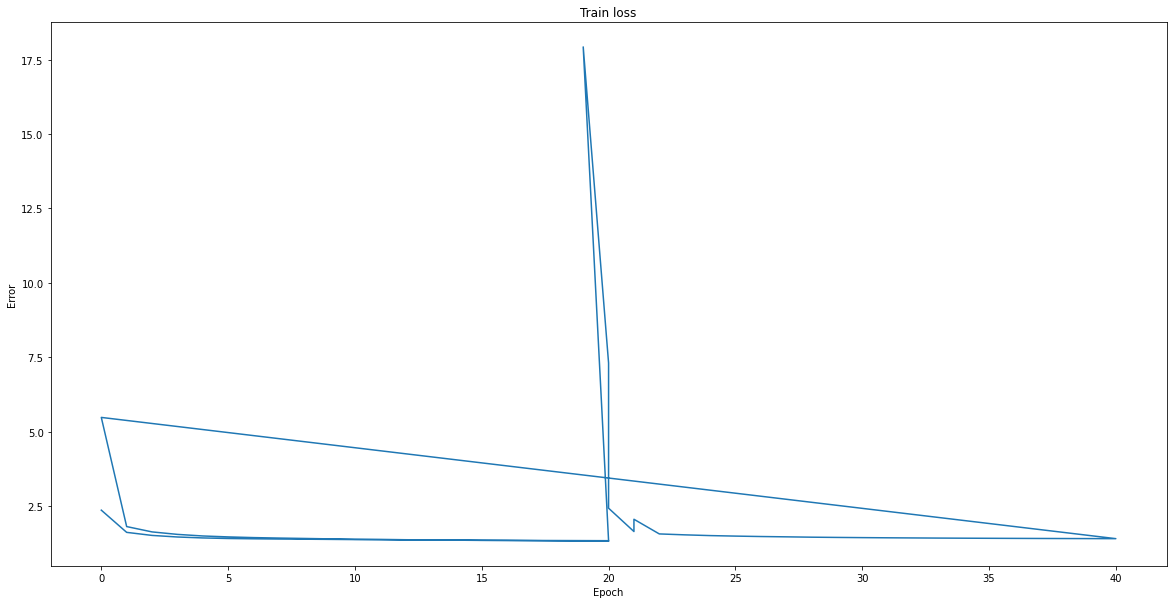

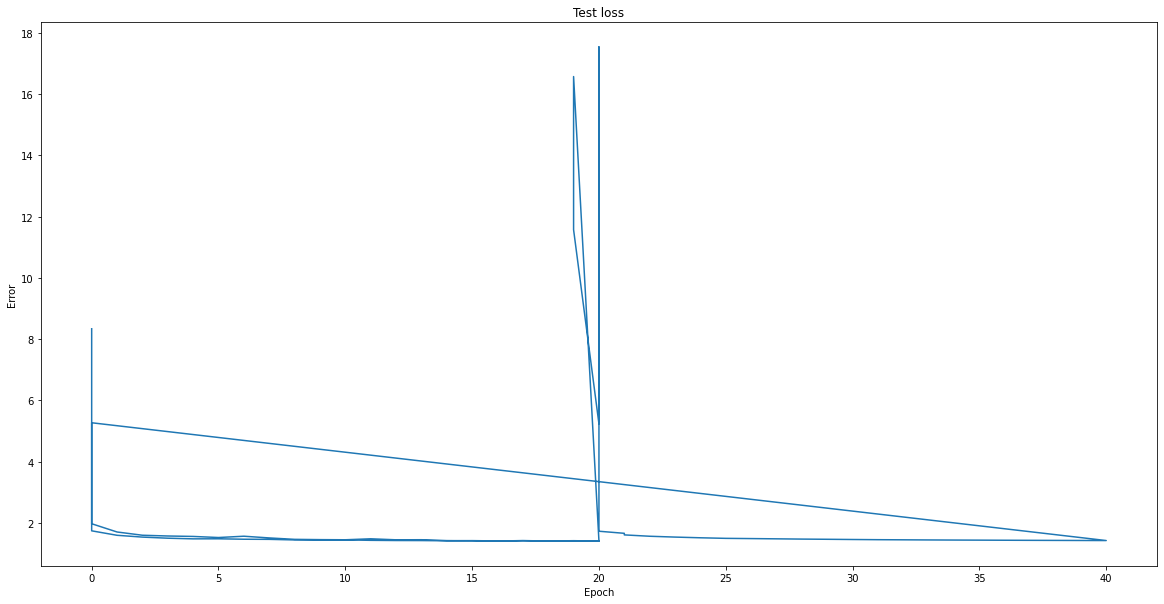

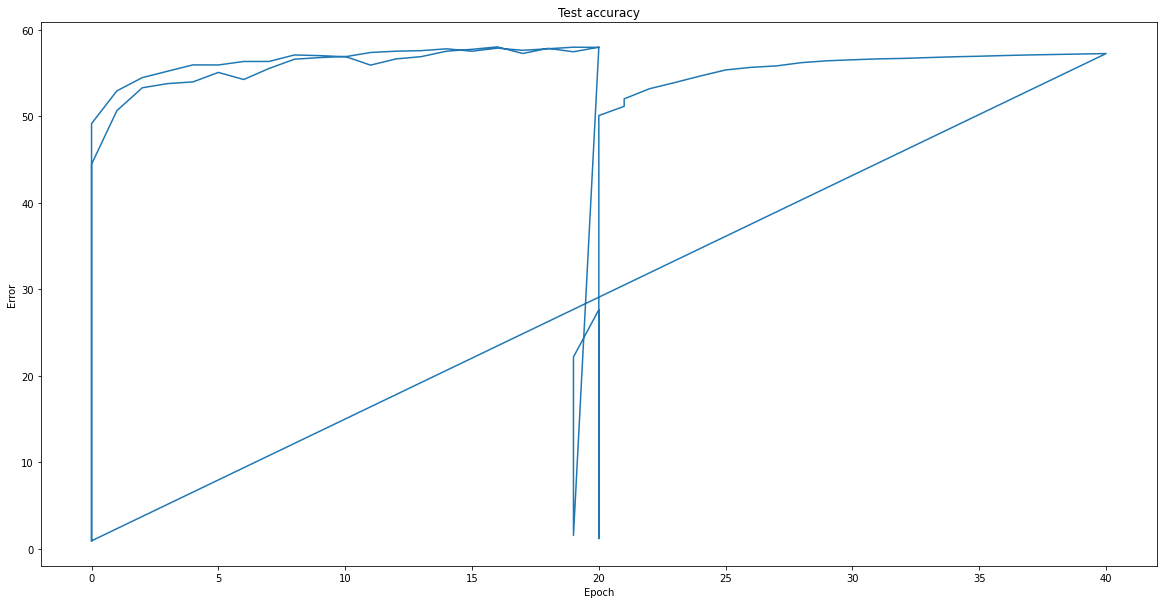

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    #print(next(iter(train_loader))[0].shape)
    model = HarryPotterNetN(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpointsM')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpointsM/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpointsM/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_N_model, vocab, device = main()

In [ ]:
eval_final_model(final_N_model, vocab, device)

generated with max	 Harry Potter and the first of the castle was still staring at the common room and starting to his face and staring at the common room and starting to his face and staring at the common room and starting to his face and s
generated with sample	 Harry Potter and thebogs spread outs of his bowls and spotting it wrest poppintaticitely in fircy, ready that Harry Moining his bady barkn hack to the night last papary practice whelse the way now never tong him!" Harry 
generated with sample	 Harry Potter and thecold moment he could have been jefeatJed that was long from from Mysters. The team word'en this taber?" "I ask, muttering the chances, all how I kejo Kean rich was cannowising occasions, The fingers w
generated with sample	 Harry Potter and thePargiddor robes will be sent-out of yours. If could not happy nim! he was toom to chass no deafter once E$" Feet was check yes dragglingblescoed down. Filch cloak empty the ground, he close the mornin
generated with sample	 Harr

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2.
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).


    